## JOKE RECOMMENDATION SYSTEM

### 1. BUISNESS PROBLEM

### 1.1 Description

**Imagine sitting bored and tired on your laptop after all the binge watching , social media etc. What if I tell you that there is a system that can put a smile on your face based on your humour? Yes we are talking about a joke reader system containing different varieties of jokes for every user to have fun with. Well on the outset it does not look that interesting in today's world where we have tons of online streaming services, but another way to look at it is as an exercise for your humor. Since humor is a key in understanding any joke , based on your humour you would like one joke funny and other not that funny. Also as humans humor is key in every interaction we make with others, so improving our humor would help in better interactions also.**


**Ok , even if people are ready to try such a system still people would not like to search for jokes, as it puts an extra effort for them. This is where our system would recommend jokes to a user based on their likes/humour. Like any other recommendation system the more user-item interaction one captures the better the system becomes. Here also for the same reason we would like the user to give a rating between -10 (not funny) to +10 (very funny) after reading the joke.
So in all, we would like to build a system which would give users some  jokes to read based on their humour or other interactions and to record the rating given to the joke by the user.**

### 1.2 Usefull Links / Sources

**1. Data source: https://www.kaggle.com/vikashrajluhaniwal/jester-17m-jokes-ratings-dataset?select=jester_ratings.csv**

**2. Related paper 1: https://goldberg.berkeley.edu/pubs/eigentaste.pdf**

**3. Related paper 2: https://arxiv.org/pdf/1804.08891.pdf**

**4. Related paper 3: https://datajobs.com/data-science-repo/Recommender-Systems-[Netflix].pdf**

**5. Related paper 4: https://arxiv.org/pdf/1708.05031.pdf**

**6. Related blog: https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/**

### 1.3 Buisness Objectives / Constraints

**1. We want to recommend top 5 jokes to a user currently reading a joke in our system.**


**2. No low latency is required.**

### 2. MACHINE LEARNING PROBLEM

### 2.1 Data

#### 2.1.1 Data Overview

**1. Data is distributed across two CSV files:- jester_ratings.csv containing three columns [userID],[jokeID],[Ratngs] and other jester_items.csv mapping ratings to the actual jokes.**




**2. Ratings are real values ranging between -10 to +10.**



**3. There are few jokes rated by almost every user . These jokes are 7, 8, 13, 15, 16, 17, 18, 19**

### 2.2 Mapping Real World Problem to ML Problem

#### 2.2.1 Type Of Machine Learning Problem

**We need to build a recommender system which gives a user with top 5 jokes recommendations given that the user is currently onto the system reading a joke.**

#### 2.2.2 Performance Metrics

**1. MAP@k Mean Average pricision: Since we want to recommend jokes to a user it makes sense to measure how good our recommendations are. We can measure this using this metric which measures how relevant our recommendations are to a user.**

**2. MAR@k MEan average recall: This metrics measures how much relevant items our system can recommend to a user. Since we want to recommend relevat and usefull jokes to our users we can keep a track of this metric also**

**3. NDCG (Normalized discounted cummulative gain): While recommending items order of the items also matter , if more important items comes on top of recommendation it makes our system more genralized. To measure the ordering of our jokes we can use this metric. More about the metric can be foound here https://en.wikipedia.org/wiki/Discounted_cumulative_gain**

**4. MAE(Mean absolute error): If we apply a technique like matrix factorization then this metric can be useful because it will give us an idea of how good our predicted ratings are from the actual ratings.**




### 3. EXPLORATORY DATA ANALYSIS

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import re
import os
from scipy import sparse
from scipy.sparse import csr_matrix
from datetime import datetime
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.utils.extmath import randomized_svd
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from collections import defaultdict
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import SGDRegressor
from sklearn.svm import LinearSVR
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
import pickle
import math
import joblib
import random
import xgboost as xgb
import lightgbm as lgb


In [2]:
'''Getting data from the files'''

jokes = pd.read_csv('jester_items.csv')
ratings = pd.read_csv('jester_ratings.csv')
print(jokes.columns)
print(ratings.columns)
print('\n**** Number of Unique Jokes are {} *****'.format(len(jokes['jokeText'].values)))
print('\n**** Number of Unique Users are {} *****'.format(len(pd.unique(ratings['userId'].values))))

Index(['jokeId', 'jokeText'], dtype='object')
Index(['userId', 'jokeId', 'rating'], dtype='object')

**** Number of Unique Jokes are 150 *****

**** Number of Unique Users are 59132 *****


### 3.1 Preprocessing

#### 3.1.1 Checking for Nan values

In [18]:
print('Number of nan values in jokes table are: {}'.format(sum(jokes.isnull().any())))
print('Number of nan values in ratings table are: {}'.format(sum(ratings.isnull().any())))

Number of nan values in jokes table are: 0
Number of nan values in ratings table are: 0


#### 3.1.2 Preprocessing Joke Text

In [19]:
jokes.iloc[10]['jokeText']

"Q. What do a hurricane, a tornado, and a redneck\ndivorce all have in common? \nA. Someone's going to lose their trailer...\n"

In [20]:
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

def preprocess_text(text_data):
    preprocessed_text = []
    # tqdm is for printing the status bar
    'Replacing \n \t \r and any other character apart from english characters to space'
    for sentance in tqdm(text_data):
        sent = decontracted(sentance)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\n', ' ')
        sent = sent.replace('\\"', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        # https://gist.github.com/sebleier/554280
        sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
        preprocessed_text.append(sent.lower().strip())
    return preprocessed_text

In [21]:
preprocessed_jokes = preprocess_text(jokes['jokeText'].values)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 6723.80it/s]


In [22]:
print(preprocessed_jokes[10])

q hurricane tornado redneck divorce common someone going lose trailer


In [106]:
print(train_data.shape,test_data.shape)

(1409151, 3) (352288, 3)


### 3.2 Plot between Number of Joke vs Number of ratings

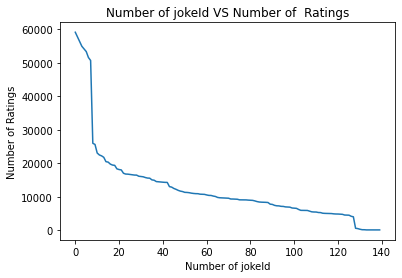

****************************************************************************************************
10 percent Jokes got number of rating below 4529.2
20 percent Jokes got number of rating below 5355.6
30 percent Jokes got number of rating below 6977.7
40 percent Jokes got number of rating below 8568.4
50 percent Jokes got number of rating below 9644.5
60 percent Jokes got number of rating below 10975.0
70 percent Jokes got number of rating below 14340.3
80 percent Jokes got number of rating below 16513.8
90 percent Jokes got number of rating below 20653.80000000001
94 percent Jokes got number of rating below 25882.44
100 percent Jokes got number of rating below 59122.0
****************************************************************************************************

Total number of unrated jokes are: 10


In [8]:

def plot_1(key):
    
    '''This plot plots number of jokes/users vs number of ratings plot'''
    
    '''getting a grouped dataframe based on the input either groupby joke or user along with count'''
    joke_groups = ratings[['userId','jokeId']].groupby([key],as_index=False).count()
    if(key == 'jokeId'):
        sort_by = 'userId'
        name = 'Jokes got'
    else:
        sort_by = 'jokeId'
        name = 'Users gave'
    
    '''Sorting the DF based on input provided'''
    joke_groups = joke_groups.sort_values(by=sort_by,ascending=False)    

    '''plotting the plot'''
    plt.plot(joke_groups[sort_by].values)
    plt.title('Number of '+key+ ' VS Number of  Ratings')
    plt.xlabel('Number of '+key)
    plt.ylabel('Number of Ratings')
    plt.show()
    print('*'*100)
    
    '''Calculating percentiles for the jokes/user ratings'''
    ratings_count = joke_groups.sort_values(by=sort_by)[sort_by].values
    for i in range(10,100,10):
        print(str(i)+' percent '+name+' number of rating below {}'.format(np.percentile(ratings_count,i)))
    print('94 percent '+name+' number of rating below {}'.format(np.percentile(ratings_count,94))) 
    print('100 percent '+name+' number of rating below {}'.format(np.percentile(ratings_count,100)))
    
    print('*'*100)
    
    if(key == 'jokeId'):
        '''Checking for nonrated jokes'''

        total_jokes = jokes['jokeId'].values
        non_rated_jokes = list(filter(lambda x: x not in joke_groups['jokeId'].values,total_jokes))
        print('\nTotal number of unrated jokes are: {}'.format(len(non_rated_jokes)))
        
    else:
        number_users = len(joke_groups[joke_groups['jokeId']>=140]['userId'])
        print('Number of users rating every joke are {}'.format(number_users))
        
plot_1('jokeId')

**1. In the above plot on the X axis we have total number of jokes and on the Y axis we have the total number of ratings. We are trying to find out the number of ratings which each joke got.**




**2. The plot tries to catch the behaviour of jokes in our dataset. As expected from any internet related data there are few jokes which are popular and has been given ratings by almost every user. Almost 94 percent of our jokes got around 25k ratings and only 6 percent of our jokes which are popular got almost 59k ratings.**


**3. There are a total of 10 jokes which are not rated by any user.**

### 3.3 Plot between Number of Users VS Number of Ratings

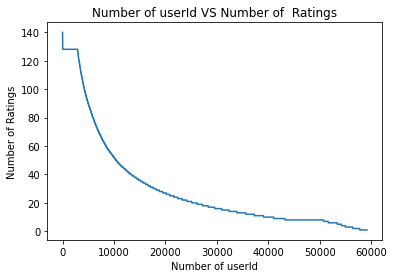

****************************************************************************************************
10 percent Users gave number of rating below 6.0
20 percent Users gave number of rating below 8.0
30 percent Users gave number of rating below 9.0
40 percent Users gave number of rating below 13.0
50 percent Users gave number of rating below 16.0
60 percent Users gave number of rating below 22.0
70 percent Users gave number of rating below 30.0
80 percent Users gave number of rating below 45.0
90 percent Users gave number of rating below 80.0
94 percent Users gave number of rating below 112.0
100 percent Users gave number of rating below 140.0
****************************************************************************************************
Number of users rating every joke are 5


In [9]:
plot_1('userId')

**1. The above plot is between number of users on X axis and number of ratings given on Y axis. we are trying to find out users rating behaviour.**


**2. Seeing the plot we can say that there are very few users that gave many ratings i.e. > 120 , while many users gave an average of 40 ratings. This is an expected trend in general also because the plot is similar to power law distribution which depicts user behaviour for any system.**

**3. Also from the perentile data we can see that 90 percent of users have rated less than 80 jokes and only 10 percent have rated above 80. There are 5 users who have rated every joke**


**4. By seeing above two plots we can also say that our user-item matrix will be sparse , since almost both plots are power law distributed. This is important because we will require a user-item interaction matrix to build our recommender system.**

### 3.4 PDF and CDF of number of ratings

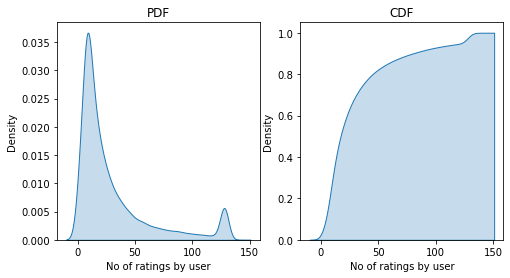

In [20]:
no_of_rated_jokes_per_user = ratings[['userId','jokeId']].groupby(by='userId').count().sort_values(
    by='jokeId',ascending=False)['jokeId'].values
fig = plt.figure(figsize=plt.figaspect(.5))

ax1 = plt.subplot(121)
sns.kdeplot(no_of_rated_jokes_per_user, shade=True, ax=ax1)
plt.xlabel('No of ratings by user')
plt.title("PDF")

ax2 = plt.subplot(122)
sns.kdeplot(no_of_rated_jokes_per_user, shade=True, cumulative=True,ax=ax2)
plt.xlabel('No of ratings by user')
plt.title('CDF')

plt.show()

**Using the above plot we can get an estimate about the percentage of users based on the ratings given. Looking at the cdf we can say that the about 85% of our users gave <=100 ratings.**

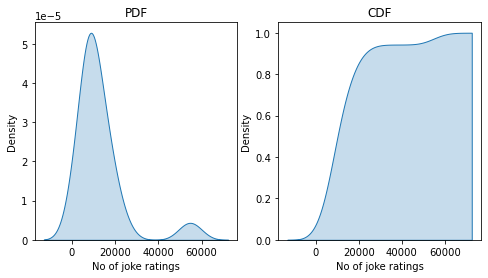

In [22]:
no_of_ratings_per_joke = ratings[['userId','jokeId']].groupby(by='jokeId').count().sort_values(by='userId',ascending=False)['userId'].values
fig = plt.figure(figsize=plt.figaspect(.5))

ax1 = plt.subplot(121)
sns.kdeplot(no_of_ratings_per_joke, shade=True, ax=ax1)
plt.xlabel('No of joke ratings')
plt.title("PDF")

ax2 = plt.subplot(122)
sns.kdeplot(no_of_ratings_per_joke, shade=True, cumulative=True,ax=ax2)
plt.xlabel('No of joke ratings')
plt.title('CDF')

plt.show()

**We can see the density of ratings recieved by each joke in our system, with most of the jokes recieving around 15k ratings , however ther are some popular jokes also which recieve almost close to 50k ratings.**

### 3.4 Distribution Of Ratings

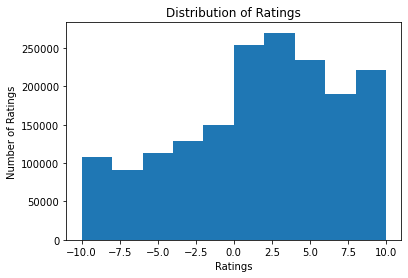

In [3]:
'''getting ratings'''
ratings_only = ratings['rating'].values

'''plotting the plot'''
plt.hist(ratings_only)
plt.title('Distribution of Ratings')
plt.xlabel('Ratings')
plt.ylabel('Number of Ratings')
plt.show()

Text(0.5, 1.0, 'Pdf')

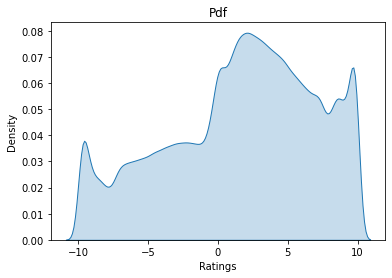

In [5]:
ax1 = plt.subplot()
sns.kdeplot(ratings_only, shade=True,label='Pdf',ax=ax1)
plt.xlabel('Ratings')
plt.title('Pdf')

**1. The above plot shows us the distribution of actual ratings in our data.**


**2. The ratings vary between -10 and +10. Most of the users have given fairly good ratings to the jokes , since the distribution seems to be more on the right side.**


**3. Overall the distribution seems widely spread, telling us that we have all sort of jokes in our system from not funny to very funny also. This is good thing because our system will get trained on large variety of data ,hence in general might predict well.**

### 3.5 Distribution of average ratings for each joke

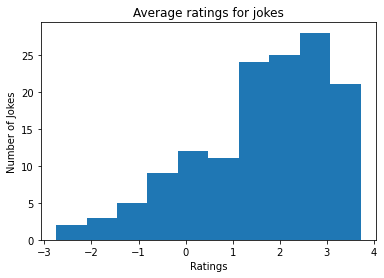

Text(0.5, 1.0, 'Cdf')

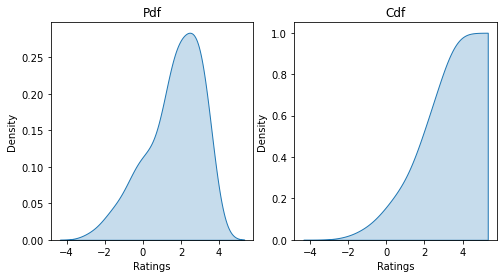

In [32]:
'''getting average joke ratings'''
average_joke_ratings = []
for i in np.unique(ratings['jokeId'].values):
    average_joke_ratings.append(np.mean(ratings[ratings['jokeId'] == i]['rating'].values))

'''plotting'''
plt.hist(average_joke_ratings)
plt.title('Average ratings for jokes')
plt.xlabel('Ratings')
plt.ylabel('Number of Jokes')
plt.show()
   
    
fig = plt.figure(figsize=plt.figaspect(.5))

ax1 = plt.subplot(121)
sns.kdeplot(average_joke_ratings, shade=True,label='Pdf',ax=ax1)
plt.xlabel('Ratings')
plt.title('Pdf')

ax2 = plt.subplot(122)
sns.kdeplot(average_joke_ratings, shade=True,label='Pdf',cumulative=True,ax=ax2)
plt.xlabel('Ratings')
plt.title('Cdf')


**1. The plot shows the distribution of average ratings for each joke.**

**2. All of our ratings lie between -2.8 to +3.7 approximately. With most of our jokes getting fairly good ratings indicating that jokes were found to be funny to users. Or it could also be the case that our users are biased towards giving good ratings and we might have to remove this bias while predicting.**

### 3.6 Distribution of average ratings by each user

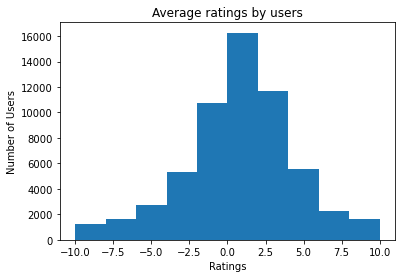

Text(0.5, 1.0, 'Cdf')

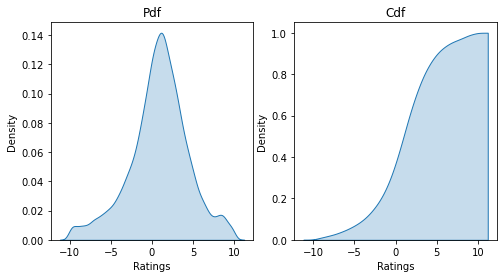

In [33]:
'''Getting avg user ratings'''
average_user_ratings = []
for i in np.unique(ratings['userId'].values):
    average_user_ratings.append(np.mean(ratings[ratings['userId'] == i]['rating'].values))

'''Plotting'''
plt.hist(average_user_ratings)
plt.title('Average ratings by users')
plt.xlabel('Ratings')
plt.ylabel('Number of Users')
plt.show()

fig = plt.figure(figsize=plt.figaspect(.5))

ax1 = plt.subplot(121)
sns.kdeplot(average_user_ratings, shade=True,label='Pdf',ax=ax1)
plt.xlabel('Ratings')
plt.title('Pdf')

ax2 = plt.subplot(122)
sns.kdeplot(average_user_ratings, shade=True,label='Pdf',cumulative=True,ax=ax2)
plt.xlabel('Ratings')
plt.title('Cdf')

**1. The above plot tells us the distribution of average ratings given by users.**

**2. Looking at the distribution it looks like a normal distribution. It tells us that there are all kinds of users in our data highly crirtc users also and overly lenient user also. This is a good thing beacuse we can train our recommender system on all sort of users and can capture more user behaviours which will make our system to recommend better in general also.**

### 3.7 Distribution of length of jokes (in words)

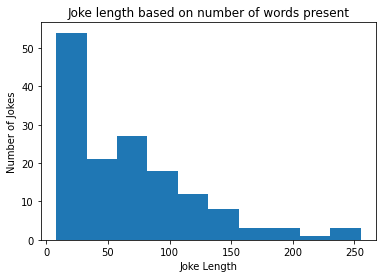

Text(0.5, 1.0, 'Cdf')

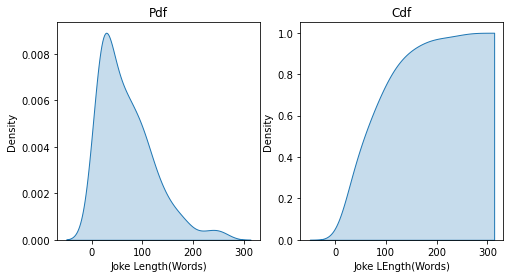

In [35]:
'''Getting each jokes length based on number of words'''
joke_length = []
for joke in jokes['jokeText'].values:
    joke_length.append(len(joke.split()))
    

'''plotting'''
plt.hist(joke_length)
plt.title('Joke length based on number of words present')
plt.xlabel('Joke Length')
plt.ylabel('Number of Jokes')
plt.show()    


fig = plt.figure(figsize=plt.figaspect(.5))

ax1 = plt.subplot(121)
sns.kdeplot(joke_length, shade=True,label='Pdf',ax=ax1)
plt.xlabel('Joke Length(Words)')
plt.title('Pdf')

ax2 = plt.subplot(122)
sns.kdeplot(joke_length, shade=True,label='Pdf',cumulative=True,ax=ax2)
plt.xlabel('Joke LEngth(Words)')
plt.title('Cdf')

**1. Above plot tells us about the length of jokes present, with X axis indicating the number of words and Y axis representing number of jokes.**

**2. It is clear from the plot that majority of our jokes are of less than 200 words. It makes sense to have shorter jokes because it takes less of the time of user which enhances user experience.Longer jokes may tire the user resulting in bad user experience**

### 3.8 Relationship between joke length and rating

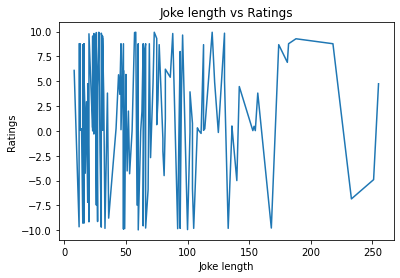

In [17]:
'''Getting lengths of rated jokes'''
rated_joke_length = [joke_length[joke_id-1] for joke_id in np.unique(ratings['jokeId'].values)]
joke_ratings = ratings['rating'].values
zipped = list(zip(rated_joke_length,joke_ratings))

'''Sorting based on joke length'''
zipped = sorted(zipped,key=lambda x: x[0])
x = []
y = []
for tup in zipped:
    x.append(tup[0])
    y.append(tup[1])

'''plotting'''
plt.plot(x,y)
plt.title('Joke length vs Ratings')
plt.xlabel('Joke length')
plt.ylabel('Ratings')
plt.show()


**1. Above plot tries to see if there is any relatioship between ratings and length of joke.** 



**2. Initially i thought that it might be some relationship between length of joke and ratings where i expected shorter jokes to get better ratings because maybe they have higher chance of interacting well with the user , But as you can see there is hardly any relationship as our plot is completelty random. It tells us that ratings to our joke is not in any way dependent on the length of the joke. Which means there definitely some humor and funniness in the jokes which is actually influencing the ratings.**


**3. Although one interesting observation is as follows : if we focus on joke length < 50 region we find that the density of our plot is very high . zooming in on this region we can see that if our jokes are of length < 25 they are rated between -2.5 to +2.5 on average and for jokes of length > 25 our jokes are getting much higher ratings . Thus medium sized jokes tend to perform better as comapred to shorter and longer jokes on average in terms of ratings. However this cannot be the ground truth beacuse our plot is very zig zagged in nature, but its just an observation from the plot.**

## Splitting data into (80:20) split

In [107]:
# ratings.iloc[:int(ratings.shape[0]*0.80)].to_csv('train.csv',index=False)
# ratings.iloc[int(ratings.shape[0]*0.80):].to_csv('test.csv',index=False)

# train_data = pd.read_csv('train.csv')
# test_data = pd.read_csv('test.csv')

In [112]:
# print(train_data.shape,test_data.shape)

(1409151, 3) (352288, 3)


## 4 converting train data into sparse matrix

In [23]:
def convert_to_matrix():
    '''This function converts the given ratings DF into a user item 
    ratings matrix'''
    
    #getting total users
    users = len(np.unique(ratings['userId'].values))
    #getting total jokes
    items = len(np.unique(jokes['jokeId'].values))
    
    #user and item dic to fill out our matrix
    user_dic = {user_id:i for i,user_id in enumerate(np.unique(ratings['userId'].values))}
    item_dic = {item_id:i for i,item_id in enumerate(np.unique(jokes['jokeId'].values))}
    #creating matrix of (user,items) shape
    matrix = np.array([np.array([99.]*items) for i in range(users)])
    #filling matrix with user ratings, 99 value represents no interaction
    for tup in tqdm(ratings.values):
        matrix[user_dic[tup[0]]][item_dic[tup[1]]] = float(tup[2])
    
    return csr_matrix(matrix)   

    

In [24]:
ratings_matrix = convert_to_matrix()
ratings_matrix.shape

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1761439/1761439 [00:03<00:00, 520634.27it/s]


(59132, 150)

### 5 Models 


### 5.1 BOW representaion of Jokes

In [129]:
preprocessed_jokes #contains jokes with basic preprocessing done

['man visits doctor doctor says bad news cancer alzheimer disease man replies well thank god not cancer',
 'couple excellent relationship going one day came home work find girlfriend packing asked leaving told heard awful things could possibly said make move told pedophile replied awfully big word ten year old',
 'q 200 feet long 4 teeth front row willie nelson concert',
 'q difference man toilet toilet not follow around use',
 'q j simpson internet address slash slash backslash slash slash escape',
 'bill hillary trip back arkansas almost gas bill pulls service station outskirts town attendant runs station serve hillary realizes old boyfriend high school attendant chat gases car cleans windows say good bye bill pulls car onto road turns hillary says not glad married not could wife grease monkey hillary replied no bill would married would pumping gas would president',
 'many feminists take screw light bulb not funny',
 'q hear dyslexic devil worshiper sold soul santa',
 'country guy go

#### Getting BOW representation for jokes

In [25]:
def BOW_representation():
    '''Function returns the bag of words representaion for each joke'''
    #initializing countvectorizer
    bow = CountVectorizer()
    #fitting and transforming jokes data
    encoding = bow.fit_transform(preprocessed_jokes)
    return encoding.toarray()
    

In [26]:
bow_encoding = BOW_representation()
bow_encoding.shape

(150, 2100)

#### Getting the distacnces between jokes

In [27]:
def bow_i_i_similarity(bow_encoding):
    
    '''This function genrates an joke joke similarity matrix
    given the bow representations of the jokes'''
    
    distance_matrix = pairwise_distances(bow_encoding,metric='cosine')
    return distance_matrix

In [28]:
joke_distance_matrix = bow_i_i_similarity(bow_encoding)
joke_distance_matrix[134]

array([0.9478714 , 0.97856268, 1.        , 0.96047153, 1.        ,
       1.        , 1.        , 1.        , 0.93891528, 1.        ,
       1.        , 0.95117916, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.97132303,
       0.96428571, 0.98115554, 1.        , 0.9685307 , 1.        ,
       1.        , 0.95707482, 0.95580583, 0.97998398, 0.93891528,
       0.92627902, 0.98115554, 1.        , 0.95509867, 1.        ,
       1.        , 0.97998398, 1.        , 1.        , 0.98023576,
       0.98093768, 0.99008686, 1.        , 1.        , 0.98176688,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       0.96025008, 1.        , 1.        , 1.        , 1.        ,
       0.96899132, 1.        , 1.        , 1.        , 0.98791579,
       1.        , 1.        , 0.93896587, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

#### Recommending top 10 jokes to a user

In [29]:
def recommend_model(query_user,joke_distance_matrix,neighbours):
    '''This function returns top 10 recommended jokes given 
    query user previos ratings'''
    
    top_10_jokes = []
    #checking for cold start problem
    if(query_user == []):
        #recommend top 10 most popular jokes from our system based on average ratings for each joke
        top_10_jokes = sorted([(jokeid,np.mean(ratings[ratings['jokeId'] == jokeid]['rating'].values))
            for jokeid in np.unique(ratings['jokeId'].values)],reverse=True
                             ,key = lambda x:x[1])[:10]
        top_10_jokes = [tup[0] for tup in top_10_jokes]
    
    else:
        '''expect query_user to be a list of tuples (jokeid,ratings) where ratings > 0 ,
        assuming positive ratings representing user liking the joke '''
        
        #getting most similar jokes based on user ratings using distance matrix
        total_recommendations = set({})
        jokes_rated_user = set({})
        for jokeid,rating in query_user:
            #getting top neighbours most similar jokes
            top_similar_jokes = set(np.argsort(joke_distance_matrix[jokeid])[1:neighbours])
            total_recommendations = total_recommendations.union(top_similar_jokes)
            jokes_rated_user.add(jokeid)
        #getting the jokes that are similar and not rated by the user
        total_recommednations = total_recommendations - jokes_rated_user    
            
        #ordering the jokes based on popularity(average ratings) and selecting top 10 jokes   
        total_recommendations = list(total_recommendations)
        top_10_jokes = sorted(total_recommendations,
                        key = lambda x: np.mean(ratings[ratings['jokeId'] == x]['rating'].values),
                                      reverse = True)[:10]
        
        
    return top_10_jokes

#### Dividing into train and test users

In [47]:
'''getting. test users for our model selecting 10% users as test users from total users'''
total_users = len(np.unique(ratings['userId'].values))
train_users = list(range(total_users))[0:int(total_users*0.90)]
test_users = list(range(total_users))[int(total_users*0.90):]


#### Dividing Rated jokes of test users

In [31]:
'''For each test user we will select 20% of ratings to test our predictions'''
def create_test_users():
    '''This function divides ratings given by test users into train and test'''
    user_joke_interaction = []
    #getting all the ratings given by a test user
    for userid in tqdm(test_users):
        user_joke_interaction.append([(jokeid,rating)
                        for jokeid,rating in enumerate(ratings_matrix.toarray()[userid])
                                      if rating != 99.0 and rating > 0])
    query_users_train = []
    query_users_test = []
    #keeping 80% of test user ratings to train the model, 20% for testing
    for ratings in user_joke_interaction:
        query_users_train.append(ratings[:int(len(ratings)*0.8)])
        query_users_test.append(ratings[int(len(ratings)*0.8):])
        
    return query_users_train,query_users_test

    
    

In [32]:
query_users_train,query_users_test = create_test_users()


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5914/5914 [00:59<00:00, 100.18it/s]


#### Calculating MAP@k for the model

In [37]:
def mean_avg_precision(query_users_train,query_users_test,distance_matrix,neighbours):
    '''This fucntion calculates the MAP@k value for the given train and test ratings data'''
    
    average_precision = 0
    relevant_items = []
    mean_avg_precision = 0
    total_users = len([user for user in query_users_train if user != []])
    #getting relevant jokes for the user
    for user in query_users_test:
        relevant_items.append([tup[0] for tup in user])
    
    
    #calculating precision@k
    for userid,user in tqdm(enumerate(query_users_train)):
        if(user != []):
            #getting 10 recommednations for current user
            recommendations = recommend_model(user,distance_matrix,neighbours)
            k = len(recommendations)
            #getting relevant jokes for this user
            relevant_items_user = relevant_items[userid]
            #getting number of relevant jokes for this user
            total_relevant_items = len(relevant_items_user)
            #iterating over k to calculate avg precision@k Ref:http://sdsawtelle.github.io/blog/output/mean-average-precision-MAP-for-recommender-systems.html
            for i in range(k):
                #checking if the kth item is relevant or not
                if(recommendations[i] in relevant_items_user):
                    #getting recommendations till i 
                    items_till_i = recommendations[:i]
                    #calculating precision till i recommendations
                    precision_i = len(list(filter(lambda x: x in relevant_items_user,items_till_i)))/k
                    #calcualting average precision over all values of k
                    average_precision = average_precision + precision_i
            average_precision = average_precision/total_relevant_items
            #calculating mean average precision over all users
            mean_avg_precision = mean_avg_precision + average_precision
    mean_avg_precision = mean_avg_precision/total_users
    return mean_avg_precision

In [240]:
print(query_users_train[188])
print(query_users_test[188])

[(7, 0.344), (15, 2.719), (16, 5.375), (17, 6.688), (18, 8.875), (48, 7.812), (52, 5.5), (53, 7.656000000000001), (65, 9.469), (67, 7.312), (71, 8.594), (88, 7.375), (103, 5.938), (105, 9.719), (106, 7.593999999999999), (113, 1.938)]
[(125, 8.656), (126, 9.281), (137, 9.75), (149, 4.968999999999999)]


In [35]:
recommendations = recommend_model(query_users_train[23],joke_distance_matrix,15)
recommendations

[3, 72, 9, 89, 114, 56, 84, 73, 39, 22]

In [36]:
mean_avg_precision(query_users_train,query_users_test,joke_distance_matrix,10)

23it [00:01, 11.65it/s]


IndexError: list index out of range

In [38]:
mean_avg_precision(query_users_train,query_users_test,joke_distance_matrix,10)

5914it [08:56, 11.03it/s]


9.80715832356491e-05

#### Calculating MAP@k for different number of neighbours

In [296]:
'''Checking metric value with increasing number of similar neighbours'''
neighbours = [15,25,35,45,55]
m_avg_pre = []
for nei in neighbours:
    m_avg_pre.append(mean_avg_precision(query_users_train,query_users_test,joke_distance_matrix,
                                        nei))


5914it [10:34,  9.32it/s]
5914it [13:14,  7.45it/s]
5914it [14:39,  6.72it/s]
5914it [15:40,  6.29it/s]
5914it [16:27,  5.99it/s]
35it [00:05,  6.29it/s]


KeyboardInterrupt: 

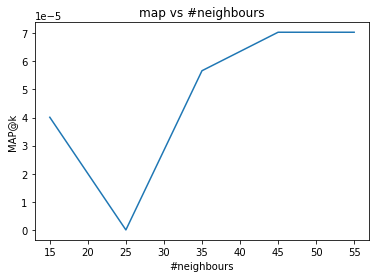

In [298]:
plt.title('map vs #neighbours')
plt.plot(neighbours[:5],m_avg_pre)
plt.xlabel('#neighbours')
plt.ylabel('MAP@k')
plt.show()

### 5.2 Tf-idf representation of jokes

In [254]:
'''Tfidf representation of jokes'''
tfidf = TfidfVectorizer()
tfidf_encoding = tfidf.fit_transform(preprocessed_jokes)
tfidf_encoding.toarray()[0]

array([0., 0., 0., ..., 0., 0., 0.])

#### Distance matrix between jokes

In [256]:
'''GEtting distance matrix between jokes based on tfidf representation'''
joke_distance_matrix_tfidf = bow_i_i_similarity(tfidf_encoding)
joke_distance_matrix_tfidf.shape

(150, 150)

In [267]:
'''Getting recommendations for a query point'''
recommendations = recommend_model(query_users_train[245],joke_distance_matrix_tfidf)
recommendations

[0, 1, 3, 6, 9, 11, 12, 14, 53, 105]

In [268]:
for i in recommendations:
    print(jokes[jokes['jokeId']==i+1]['jokeText'].values)

['A man visits the doctor. The doctor says "I have bad news for you.You have\ncancer and Alzheimer\'s disease". \nThe man replies "Well,thank God I don\'t have cancer!"\n']
['This couple had an excellent relationship going until one day he came home\nfrom work to find his girlfriend packing. He asked her why she was leaving him\nand she told him that she had heard awful things about him. \n\n"What could they possibly have said to make you move out?" \n\n"They told me that you were a pedophile." \n\nHe replied, "That\'s an awfully big word for a ten year old." \n']
["Q. What's the difference between a man and a toilet? \n\nA. A toilet doesn't follow you around after you use it.\n"]
["How many feminists does it take to screw in a light bulb?\nThat's not funny.\n"]
['Two cannibals are eating a clown, one turns to other and says: \n"Does this taste funny to you? \n']
['A guy stood over his tee shot for what seemed an eternity, looking up, looking down, measuring the distance,\nfiguring the

In [263]:
'''Getting mean average precision for all query points'''
mean_avg_percision_tfidf = mean_avg_precision(query_users_train,query_users_test,joke_distance_matrix_tfidf)

5914it [14:01,  7.02it/s]


In [264]:
#our mean avg precision improved slightly
mean_avg_percision_tfidf

7.037256624482946e-05

#### Getting MAP@k for different number of neighbours

In [300]:
'''Checking metric value with increasing number of similar neighbours'''
neighbours = [15,25,35,45,55]
m_avg_pre = []
for nei in neighbours:
    m_avg_pre.append(mean_avg_precision(query_users_train,query_users_test,joke_distance_matrix_tfidf,
                                        nei))


5914it [10:47,  9.13it/s]
5914it [13:25,  7.34it/s]
5914it [15:03,  6.55it/s]
5914it [15:50,  6.22it/s]
5914it [15:52,  6.21it/s]


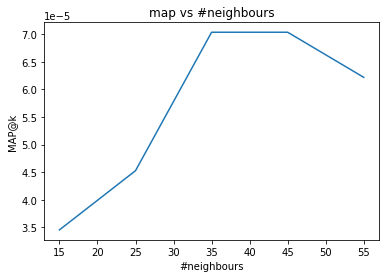

In [301]:
plt.title('map vs #neighbours')
plt.plot(neighbours[:5],m_avg_pre)
plt.xlabel('#neighbours')
plt.ylabel('MAP@k')
plt.show()

### 5.3 Tf-idf weighted W2v representaion

In [5]:
#getting our pretrained glove vector file
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())


tfidf_model = TfidfVectorizer()
tfidf_model.fit(preprocessed_jokes)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

### Getting joke representaion in tfidf weighted W2V

In [6]:
def tfidf_w2v():
    '''This function returns the jokes represented in tfidf weighted w2vec format'''
    tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sentence in tqdm(preprocessed_jokes): # for each review/sentence
        vector = np.zeros(300) # as word vectors are of zero length
        tf_idf_weight =0; # num of words with a valid vector in the sentence/review
        for word in sentence.split(): # for each word in a review/sentence
            if (word in glove_words) and (word in tfidf_words):
                vec = model[word] # getting the vector for each word
                # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
                tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
                vector += (vec * tf_idf) # calculating tfidf weighted w2v
                tf_idf_weight += tf_idf
        if tf_idf_weight != 0:
            vector /= tf_idf_weight
        tfidf_w2v_vectors.append(vector)
    return tfidf_w2v_vectors



In [7]:
tfidf_w2v_encoding = tfidf_w2v()


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 3506.55it/s]


In [9]:
tfidf_w2v_encoding[7]

array([-1.10100952e-01, -1.03556918e-01,  7.95130302e-02,  4.90172344e-02,
       -1.29217791e-01,  2.36133757e-01, -2.09297887e+00, -3.91817457e-01,
        2.40921890e-01, -2.56662039e-01,  1.84550047e-02, -6.83366355e-02,
       -1.46351616e-01,  6.85144788e-02, -9.08345499e-03, -9.99264412e-02,
       -6.15692053e-02, -1.61817236e-01,  2.27350536e-02,  2.51759860e-01,
        1.19395036e-01, -2.58315881e-02, -1.62394460e-01, -1.07645646e-01,
        1.25635610e-01, -2.14067299e-02, -6.60896633e-02,  7.81938128e-02,
        1.07865713e-01,  1.52910493e-01, -1.70823530e-01,  2.79447971e-02,
        5.92662078e-03,  1.38447608e-01,  2.95695776e-02,  2.10467571e-01,
        4.50477542e-02, -3.58540791e-02,  2.68733650e-01,  2.45220437e-03,
        6.18654608e-03,  1.73192933e-01, -2.30973932e-02,  7.55917762e-02,
       -2.34441401e-01,  2.09624563e-01,  2.20246923e-01,  2.44679272e-02,
       -2.37038845e-02,  2.17741443e-01, -6.76318749e-02, -8.82110174e-02,
        9.43968443e-02, -

#### Distnace matrix

In [279]:
joke_distance_matrix_w2v = bow_i_i_similarity(tfidf_w2v_encoding)
joke_distance_matrix_w2v

array([[0.00000000e+00, 2.02616042e-01, 3.23715094e-01, ...,
        2.49209430e-01, 2.93956821e-01, 2.72224488e-01],
       [2.02616042e-01, 4.44089210e-16, 1.98376199e-01, ...,
        1.39863116e-01, 1.61565658e-01, 1.42115613e-01],
       [3.23715094e-01, 1.98376199e-01, 0.00000000e+00, ...,
        2.10894965e-01, 2.85886000e-01, 2.65471138e-01],
       ...,
       [2.49209430e-01, 1.39863116e-01, 2.10894965e-01, ...,
        0.00000000e+00, 2.25699313e-01, 2.12273697e-01],
       [2.93956821e-01, 1.61565658e-01, 2.85886000e-01, ...,
        2.25699313e-01, 4.44089210e-16, 2.37233120e-01],
       [2.72224488e-01, 1.42115613e-01, 2.65471138e-01, ...,
        2.12273697e-01, 2.37233120e-01, 6.66133815e-16]])

In [372]:
'''Getting recommendations for a query point'''
recommendations = recommend_model(query_users_train[245],joke_distance_matrix_w2v,30)
recommendations

/Users/divyamvashishth/miniforge3/envs/ml_setup/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/divyamvashishth/miniforge3/envs/ml_setup/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[0, 1, 6, 9, 11, 12, 14, 53, 105, 89]

In [281]:
'''Getting mean average precision for all query points'''
mean_avg_percision_tfidf = mean_avg_precision(query_users_train,query_users_test,joke_distance_matrix_w2v)


5914it [25:18,  3.89it/s] 


NameError: name 'mean_avg_precision_tfidf' is not defined

In [282]:
mean_avg_percision_tfidf

0.00045050306973010043

#### Getting MAP@k for different number of neighbours

In [302]:
'''Checking metric value with increasing number of similar neighbours'''
neighbours = [15,25,35,45,55]
m_avg_pre = []
for nei in neighbours:
    m_avg_pre.append(mean_avg_precision(query_users_train,query_users_test,joke_distance_matrix_w2v,
                                        nei))


5914it [07:16, 13.54it/s]
5914it [09:05, 10.85it/s]
5914it [10:32,  9.34it/s]
5914it [12:00,  8.21it/s]
5914it [13:03,  7.55it/s]


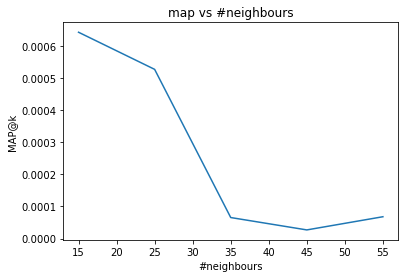

In [303]:
plt.title('map vs #neighbours')
plt.plot(neighbours[:5],m_avg_pre)
plt.xlabel('#neighbours')
plt.ylabel('MAP@k')
plt.show()

**there is some improvement in the performance by using w2v representations as our overall map is increased for neighbours equal to 15**

## 6. MAtrix factorization technique

Here we will try to factorize our ratings matrix into U and V matrix so that we can predict the ratings for every user item pair.We will try to find the solve the follwing optimization problem

$$
L = \min_{ b, c, \{ u_i \}_{i=1}^N, \{ v_j \}_{j=1}^M}
\quad
\alpha \Big(
    \sum_{j} \sum_{k} v_{jk}^2 
    + \sum_{i} \sum_{k} u_{ik}^2 
    + \sum_{i} b_i^2
    + \sum_{j} c_i^2
    \Big)
+ \sum_{i,j \in \mathcal{I}^{\text{train}}}
    (y_{ij} - \mu - b_i - c_j - u_i^T v_j)^2
$$

<ul>
<li><span class="math">\(\mu\)</span> : scalar mean rating</li>
<li><span class="math">\(b_i\)</span> : scalar bias term for user <span class="math">\(i\)</span></li>
<li><span class="math">\(c_j\)</span> : scalar bias term for movie <span class="math">\(j\)</span></li>
<li><span class="math">\(u_i\)</span> : K-dimensional vector for user <span class="math">\(i\)</span></li>
<li><span class="math">\(v_j\)</span> : K-dimensional vector for movie <span class="math">\(j\)</span></li>
</ul>

 $ \ $  

In [4]:
ratings_matrix.shape

NameError: name 'ratings_matrix' is not defined

### Changing the rating matrix such that each rating lies between 1 to 21 . 0 represents no interaction between user and joke

In [48]:
#getitng minimum rating from ratigns
min_rating = min(ratings['rating'].values)
#adding -1*min_rating +1 to each rating so that our min rating becomes 1.
scaled_ratings = [rating+(-1*min_rating)+1 for rating in ratings['rating'].values]
print(min(scaled_ratings))
print(max(scaled_ratings))


1.0
21.0


In [6]:
len(scaled_ratings)

1761439

In [49]:
    #getting total users
    users = len(np.unique(ratings['userId'].values))
    #getting total jokes
    items = len(np.unique(jokes['jokeId'].values))
    
    #user and item dic to fill out our matrix
    user_dic = {user_id:i for i,user_id in enumerate(np.unique(ratings['userId'].values))}
    item_dic = {item_id:i for i,item_id in enumerate(np.unique(jokes['jokeId'].values))}
    #creating matrix of (user,items) shape
    scaled_matrix = np.zeros((users,items))
    #filling matrix with user ratings, 99 value represents no interaction
    for i,tup in tqdm(enumerate(ratings.values)):
        scaled_matrix[user_dic[tup[0]]][item_dic[tup[1]]] = float(scaled_ratings[i])
    
    scaled_matrix = csr_matrix(scaled_matrix)
    

1761439it [00:03, 458821.35it/s]


In [6]:
scaled_matrix.shape

(59132, 150)

In scaled matrix our ratings vary from 1 to 21 where closer to 1 rating implies bad rating and closer to 21 implies good rating

#### Factorizing this scaled matrix to get our users and item vectors in latent space

In [10]:

joke_svd = TruncatedSVD(n_components=149, algorithm='randomized', random_state=15)
joke_svd.fit_transform(scaled_matrix)

array([[ 7.27476382e+01,  8.88647518e+00, -2.55499527e+01, ...,
         1.84493936e-14, -4.50470783e-14, -3.08845306e-14],
       [ 5.02192907e+01, -2.70881104e+01,  5.12299407e+00, ...,
         1.79216897e-14, -1.10885277e-14, -8.97563324e-14],
       [ 6.83543818e+00, -3.61465778e+00,  3.50277904e+00, ...,
        -3.68952606e-15, -9.07380334e-15,  2.18227060e-14],
       ...,
       [ 3.41996413e+00, -7.27900001e+00,  3.79836843e+00, ...,
         4.22739621e-15,  4.14598911e-16, -5.34949168e-15],
       [ 1.18127931e+01, -2.14243888e+01,  1.04664689e+01, ...,
        -8.73051631e-16,  2.97615925e-15,  7.58018648e-16],
       [ 1.67223726e+02,  6.91704236e+01,  4.62649276e+00, ...,
         1.07487846e-14, -8.10078814e-14, -2.40143142e-14]])

#### Getting plot of variance explained to get ideal number of latent vectors

/var/folders/rs/dnnfj5ys6x19tnzw7f1hbj0h0000gn/T/ipykernel_856/3400758349.py:11: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax1.annotate(s ="({}, {})".format(i,  np.round(expl_var[i-1], 2)), xy=(i-1, expl_var[i-1]),


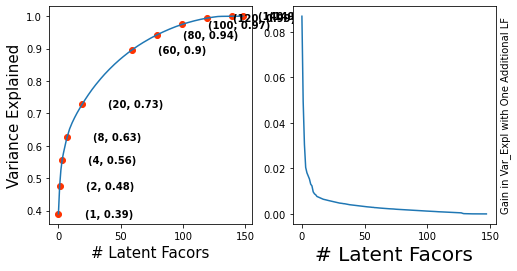

In [13]:
expl_var = np.cumsum(joke_svd.explained_variance_ratio_)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(.5))

ax1.set_ylabel("Variance Explained", fontsize=15)
ax1.set_xlabel("# Latent Facors", fontsize=15)
ax1.plot(expl_var)
# annote some (latentfactors, expl_var) to make it clear
ind = [1, 2,4,8,20, 60, 80, 100, 120, 140, 149]
ax1.scatter(x = [i-1 for i in ind], y = expl_var[[i-1 for i in ind]], c='#ff3300')
for i in ind:
    ax1.annotate(s ="({}, {})".format(i,  np.round(expl_var[i-1], 2)), xy=(i-1, expl_var[i-1]),
                xytext = ( i+20, expl_var[i-1] - 0.01), fontweight='bold')

change_in_expl_var = [expl_var[i+1] - expl_var[i] for i in range(len(expl_var)-1)]
ax2.plot(change_in_expl_var)



ax2.set_ylabel("Gain in Var_Expl with One Additional LF", fontsize=10)
ax2.yaxis.set_label_position("right")
ax2.set_xlabel("# Latent Facors", fontsize=20)

plt.show()

Seeing at the plot 100 latent factors seem to be fine as we can explain almost 100% variance

#### Decomposing matrix to get users and items in 100 dimensions latent space using randomizedSVD

In [50]:
U,sigma,VT = randomized_svd(scaled_matrix,n_components=100,n_iter=5)
print(U.shape)
print(sigma.shape)
print(VT.shape)

(59132, 100)
(100,)
(100, 150)


In [51]:
joblib.dump(U,'U')
joblib.dump(VT,'VT')

['VT']

### Regession based models

Lets try to pose our problem interms of regression problem.
We can treat the above U and VT matrices for featurization and the ratings given as y_i.
Training a regression Machine learing model onto this data we can predict the ratings given by our user for a joke.

#### Featurization of data

We can use U and VT for user and item featurization , apart from it for item featurization we can also include the text jokes represented in form of tfidf weighted W2v vectors.
Combining all these features our each vector will be of size (1,500) assuming 300 dim for W2vec representations. But here we are not combining W2v fearures as the data was becoming large and computations were taking longer

In [17]:
ratings.head()

,userId,jokeId,rating
0,1,5,0.219
1,1,7,-9.281
2,1,8,-9.281
3,1,13,-6.781
4,1,15,0.875


In [59]:
jokes.head()

,jokeId,jokeText
0,1,"A man visits the doctor. The doctor says ""I ha..."
1,2,This couple had an excellent relationship goin...
2,3,Q. What's 200 feet long and has 4 teeth? \n\nA...
3,4,Q. What's the difference between a man and a t...
4,5,Q.\tWhat's O. J. Simpson's Internet address? \...


In [58]:
len(test_users)
#train_users[53218]
print(len(test_users))
print(len(U))
53218 + 5913

5914
59132


59131

#### Featurizing our train users , converting them to vectors

In [52]:
def featurize_data(key):
    '''This function featurize users and return the user vectors'''
    if(key == 'train'):
        target = train_users
        to_be_added = 0
    else:
        target = test_users
        to_be_added = len(train_users)
    #getting unique users
    uniq_users = np.unique(ratings['userId'])
    #getting usrid for train users
    usrs = uniq_users[target]
    data_for_ml = []
    y_i=[]
    #featurizing our train data
    for i,userid in tqdm(enumerate(usrs)):
        #getting jokes user has rated
        for tup in ratings[ratings['userId']==userid][['jokeId','rating']].values:
            data_for_ml.append(U[i + to_be_added].tolist()+VT.T[int(tup[0])-1].tolist())
            y_i.append(tup[1]+(-1*min_rating)+1)

    data_for_ml = np.array(data_for_ml)  
    return data_for_ml,y_i

In [53]:
data_for_ml,y_i = featurize_data('train')

53218it [02:00, 441.39it/s]


In [54]:
print(data_for_ml.shape)
y_i = np.array(y_i)
print(y_i.shape)

(1590678, 200)
(1590678,)


### Splitting the data into train and test data

In [55]:
X_train,X_test,y_train,y_test = train_test_split(data_for_ml,y_i,test_size=0.2,random_state=42)

print('train data shape: ',X_train.shape,y_train.shape)
print('test data shape: ',X_test.shape,y_test.shape)

train data shape:  (1272542, 200) (1272542,)
test data shape:  (318136, 200) (318136,)


### XGboost on training data

In [64]:
xgb_model = xgb.XGBRegressor(n_estimators=100,silent=False, n_jobs=-1, random_state=15)
xgb_model.fit(X_train,y_train,eval_metric = 'rmse')

[14:50:39] WARNING: /Users/ktietz/demo/mc3/conda-bld/xgboost-split_1628682908089/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=15,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, silent=False,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [65]:
#getting predictions for train data
y_pred = xgb_model.predict(X_train)
#getting RMSE value
rmse_train = np.sqrt(np.mean([ (y_train[i] - y_pred[i])**2 for i in range(len(y_pred)) ]))
print('RMSE for Train data is: ',rmse_train)

RMSE for Train data is:  3.36728010544939


In [66]:
#getting predictions for test data
y_pred = xgb_model.predict(X_test)
#getting RMSE value
rmse_test = np.sqrt(np.mean([ (y_test[i] - y_pred[i])**2 for i in range(len(y_pred)) ]))
print('RMSE for Test data is: ',rmse_test)

RMSE for Test data is:  3.42972480242575


In [67]:
xgb_model.predict(np.array([X_test[0]]))


array([15.707578], dtype=float32)

#### Making joke predictions for a query user using the xgboost model

Here we will get the predictoins for a given query user. We will run the user with every joke and get its predicted ratings from our model. and the would return the top 10 highest rated jokes

In [19]:
def get_predictions(query_user,model):
    
    '''This function gives the top 10 recommendations of jokes given a user
    based on the xgboost model trained'''
    
    #get the userid gor the query user
    userid = query_user
    pred_ratings = []
    #get the user vector in latent space
    u_vec = U[userid]
    #predict ratings for each joke
    for jokeid in range(150):
        #get the joke vector in latent sapce
        j_vec = VT.T[jokeid]
        #combie user and joke vector
        vector = u_vec.tolist() + j_vec.tolist()
        #predict the rating for the joke
        pred_ratings.append(model.predict(np.array([vector]))[0])
        #print(pred_ratings)
    #sort the ratings in dec order
    
    pred_ratings = np.argsort(pred_ratings)[::-1]
    return pred_ratings[:10].tolist()
    
def get_predictions_dist_based_model(query_user,model):
    '''This function returns top 10 predictions of the query user based on the
    given distance based model'''
    
    #get the userid gor the query user
    userid = query_user
    pred_ratings = []
    #get the user vector in latent space
    u_vec = U[userid]
    #Creating data with user matched with each joke present
    query_data = []
    for jokeid in range(150):
        #get the joke vector in latent sapce
        j_vec = VT.T[jokeid]
        #combie user and joke vector
        vector = u_vec.tolist() + j_vec.tolist()
        query_data.append(vector)
    
    #standard scaling the data
    query_data = StandardScaler().fit_transform(query_data)
    #predict the rating for the joke
    pred_ratings = model.predict(query_data)
    #sort the ratings in dec order
    pred_ratings = np.argsort(pred_ratings)[::-1]
    #print(pred_ratings)
    return pred_ratings[:10].tolist()
        

In [105]:
get_predictions(test_users[89])

[52, 71, 107, 17, 68, 133, 65, 34, 116, 128]

#### Here we are calculating our metric MAP@k for this model

In [24]:
def get_mapk(query_users,model,key='not dist'):
    
    '''This function calculates mean average precision for the given model'''
    #get the query users id
    uniq_users = np.unique(ratings['userId'])
    query_users_id = uniq_users[query_users]
    mean_avg_precision = 0
    k = 10
    average_precision = 0
    total_users = len(query_users)
    #iterating over each user
    for i,userid in tqdm(enumerate(query_users_id)):
        #getting relevant jokes for the current uswr
        relevant_items_user = ratings[ratings['userId']==userid]['jokeId'].values
        #gettig recommendations for the user using given model
        if(key == 'dist'):
            recommendations = get_predictions_dist_based_model(query_users[i],model)
        else:
            recommendations = get_predictions(query_users[i],model)
        total_relevant_items = len(relevant_items_user)
        #iterating over number of recommendations
        for i in range(k):
                #checking if the kth item is relevant or not
                if(recommendations[i] in relevant_items_user):
                    #getting recommendations till i 
                    items_till_i = recommendations[:i]
                    #calculating precision till i recommendations
                    precision_i = len(list(filter(lambda x: x in relevant_items_user,items_till_i)))/k
                    #calcualting average precision over all values of k
                    average_precision = average_precision + precision_i
        average_precision = average_precision/total_relevant_items
        #calculating mean average precision over all users
        mean_avg_precision = mean_avg_precision + average_precision
    mean_avg_precision = mean_avg_precision/total_users
    return mean_avg_precision   

In [114]:
mapk_regression = get_mapk(test_users,xgb_model)

5914it [02:01, 48.73it/s]


In [115]:
print('MAP@k for regression model is: ',mapk_regression)

MAP@k for regression model is:  0.02347029577959692


### Lasso Model

#### Standardizing the Data

In [60]:
def standardize_data(data):
    '''This function standardizes the given data by subtracting mean and dividing 
    by std deviation'''
    
    std = StandardScaler()
    return std.fit_transform(data)


In [6]:
'''Standardizing the train and test data'''
X_train_std = standardize_data(X_train)
X_test_std = standardize_data(X_test)


NameError: name 'X_train' is not defined

#### Hyperparameter Tuning for alpha

Tried hyperparameter tuning on whole train data but my laptop could not take it as it went down.So lets try to do it on half the train data.

In [24]:
'''reducing train data to half to perform hyperparameter tuning'''
cv_train_data,rem_data,y_cv,y_rem = train_test_split(X_train_std,y_train,test_size=0.5)
print(cv_train_data.shape,y_cv.shape)

(636271, 200) (636271,)


In [77]:
'''Performing hyperparameter tuning on reduced data'''
lasso_model = Lasso()
param_dic = {'alpha':uniform}
cv_model = RandomizedSearchCV(lasso_model,param_distributions = param_dic,
                             n_jobs=-1,scoring='neg_mean_squared_error')
cv_model.fit(cv_train_data,y_cv)


RandomizedSearchCV(estimator=Lasso(), n_jobs=-1,
                   param_distributions={'alpha': <scipy.stats._continuous_distns.uniform_gen object at 0x147669940>},
                   scoring='neg_mean_squared_error')

#### Fitting the best model on training data

In [80]:
lasso_best_model = cv_model.best_estimator_
joblib.dump(lasso_best_model,'lasso_best_model')
lasso_best_model.fit(X_train_std,y_train)

Lasso(alpha=0.13374540329999207)

#### Getting prediction rating for train data and calculating RMSE

In [79]:
#getting predictions for train data
y_pred = lasso_best_model.predict(X_train_std)
#getting RMSE value
rmse_train = np.sqrt(np.mean([ (y_train[i] - y_pred[i])**2 for i in range(len(y_pred)) ]))
print('RMSE for Train data is: ',rmse_train)

RMSE for Train data is:  4.6460883526093415


#### Getting prediction rating for test data and calculating RMSE

In [81]:
#getting predictions for train data
y_pred = lasso_best_model.predict(X_test_std)
#getting RMSE value
rmse_test = np.sqrt(np.mean([ (y_test[i] - y_pred[i])**2 for i in range(len(y_pred)) ]))
print('RMSE for Test data is: ',rmse_test)

RMSE for Test data is:  4.646680059628135


#### Featurizing Query users adn convert them into vectors

In [82]:
query_users_te,y_query = featurize_data('test')  

5914it [00:08, 700.08it/s]


In [83]:
query_users_te.shape

(170761, 200)

#### Making joke predictions for a query user using the Lasso model

In [108]:
get_predictions_dist_based_model(test_users[90],lasso_best_model)

[88, 113, 34, 31, 52, 104, 71, 105, 128, 116]

#### Getting the MAP@k for the Lasso model

In [116]:
mapk_lasso = get_mapk(test_users,lasso_best_model,'dist')

5914it [00:26, 226.77it/s]


In [117]:
print('MAP@k for Lasso model is {}'.format(mapk_lasso))

MAP@k for Lasso model is 0.0033966182319813396


### Ridge Regression Model

#### Hyperparameter tuning for alpha

In [120]:
'''Performing hyperparameter tuning on reduced data'''
ridge_model = Ridge()
param_dic = {'alpha':uniform}
cv_model_ridge = RandomizedSearchCV(ridge_model,param_distributions = param_dic,
                             n_jobs=-1,scoring='neg_mean_squared_error',n_iter=5,verbose=1,cv=3)
cv_model_ridge.fit(cv_train_data,y_cv)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


RandomizedSearchCV(cv=3, estimator=Ridge(), n_iter=5, n_jobs=-1,
                   param_distributions={'alpha': <scipy.stats._continuous_distns.uniform_gen object at 0x147669940>},
                   scoring='neg_mean_squared_error', verbose=1)

#### Fitting the best ridge model on training data

In [121]:
ridge_best_model = cv_model_ridge.best_estimator_
joblib.dump(ridge_best_model,'ridge_best_model')
ridge_best_model.fit(X_train_std,y_train)

Ridge(alpha=0.7524069816410349)

#### Getting prediction rating for training data and calculate RMSE

In [122]:
#getting predictions for train data
y_pred = ridge_best_model.predict(X_train_std)
#getting RMSE value
rmse_train = np.sqrt(np.mean([ (y_train[i] - y_pred[i])**2 for i in range(len(y_pred)) ]))
print('RMSE for Train data is: ',rmse_train)

RMSE for Train data is:  4.52155591735665


#### Getting prediction rating for test data and calculate RMSE

In [123]:
#getting predictions for train data
y_pred = ridge_best_model.predict(X_test_std)
#getting RMSE value
rmse_test = np.sqrt(np.mean([ (y_test[i] - y_pred[i])**2 for i in range(len(y_pred)) ]))
print('RMSE for Test data is: ',rmse_test)

RMSE for Test data is:  4.522965716146352


#### Making joke predictions based. on Ridge Model

In [ ]:
get_predictions_dist_based_model(test_users[87],ridge_best_model)

#### Getting MAP@k for the Ridge model

In [127]:
mapk_ridge = get_mapk(test_users,ridge_best_model,'dist')
print('MAP@K for ridge model is {}'.format(mapk_ridge))

5914it [00:26, 225.28it/s]

MAP@K for ridge model is 0.0053483785772418906


### Linear SVR (Support vector Regrresor) Model

#### Hyperparameter tuning for alpha

In [15]:
linear_svr = SGDRegressor(loss='epsilon_insensitive')
param_dic = {'alpha':uniform}
cv_model_linear_svm = RandomizedSearchCV(linear_svr,param_distributions = param_dic,
                             n_jobs=-1,scoring='neg_mean_squared_error',n_iter=3,verbose=1,cv=2)
cv_model_linear_svm.fit(X_train_std,y_train)

'''Tried tuning for alpha but it was taking too long more than 3 hrs so will take default alpha'''

Fitting 2 folds for each of 3 candidates, totalling 6 fits


KeyboardInterrupt: 

#### Fitting the model on training Data

In [14]:
linear_svr_best = SGDRegressor(loss='epsilon_insensitive',verbose=2)
linear_svr_best.fit(X_train_std,y_train)


-- Epoch 1
Norm: 8.40, NNZs: 200, Bias: 12.865364, T: 1272542, Avg. loss: 3.528683
Total training time: 0.69 seconds.
-- Epoch 2
Norm: 8.45, NNZs: 200, Bias: 12.865513, T: 2545084, Avg. loss: 3.471031
Total training time: 1.38 seconds.
-- Epoch 3
Norm: 8.45, NNZs: 200, Bias: 12.864103, T: 3817626, Avg. loss: 3.469285
Total training time: 2.06 seconds.
-- Epoch 4
Norm: 8.43, NNZs: 200, Bias: 12.841599, T: 5090168, Avg. loss: 3.468280
Total training time: 2.74 seconds.
-- Epoch 5
Norm: 8.47, NNZs: 200, Bias: 12.875648, T: 6362710, Avg. loss: 3.467924
Total training time: 3.46 seconds.
-- Epoch 6
Norm: 8.42, NNZs: 200, Bias: 12.899635, T: 7635252, Avg. loss: 3.467178
Total training time: 4.17 seconds.
-- Epoch 7
Norm: 8.45, NNZs: 200, Bias: 12.900141, T: 8907794, Avg. loss: 3.466825
Total training time: 4.88 seconds.
-- Epoch 8
Norm: 8.45, NNZs: 200, Bias: 12.874750, T: 10180336, Avg. loss: 3.466648
Total training time: 5.57 seconds.
-- Epoch 9
Norm: 8.44, NNZs: 200, Bias: 12.829604, T: 1

SGDRegressor(loss='epsilon_insensitive', verbose=2)

#### RMSE for train data

In [16]:
#getting predictions for train data
y_pred = linear_svr_best.predict(X_train_std)
#getting RMSE value
rmse_train = np.sqrt(np.mean([ (y_train[i] - y_pred[i])**2 for i in range(len(y_pred)) ]))
print('RMSE for Train data is: ',rmse_train)

RMSE for Train data is:  4.5738313578225105


#### RMSE for Test Data

In [17]:
#getting predictions for train data
y_pred = linear_svr_best.predict(X_test_std)
#getting RMSE value
rmse_test = np.sqrt(np.mean([ (y_test[i] - y_pred[i])**2 for i in range(len(y_pred)) ]))
print('RMSE for Test data is: ',rmse_test)

RMSE for Test data is:  4.5758346058607655


#### Getting Joke Predictions

In [22]:
get_predictions_dist_based_model(test_users[8],linear_svr_best)

[105, 49, 52, 128, 137, 126, 28, 107, 53, 118]

#### Getting MAP@K for model

In [25]:
mapk_lvr = get_mapk(test_users,linear_svr_best,'dist')
print('MAP@K for Linear LVR model is {}'.format(mapk_lvr))

5914it [00:26, 225.91it/s]

MAP@K for Linear LVR model is 0.009296492242380439


### SVR With Polynomial Kernel

In [ ]:
SVR().fit(X_train_std,y_train)

### Desicion tree model

#### tuning the DT parameters to get the best estimator

In [15]:
reg_decision_model=DecisionTreeRegressor()

parameters={"splitter":["best","random"],
            "max_depth" : [1,3,5,7,9,11,12],
           "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
           "min_weight_fraction_leaf":[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
           "max_features":["auto","log2","sqrt",None],
           "max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90] }
cv_dt = RandomizedSearchCV(reg_decision_model,param_distributions = parameters,n_jobs=-1,
                           scoring='neg_mean_squared_error',
                           n_iter=5,verbose=3,cv=2)
cv_dt.fit(X_train,y_train)


Fitting 2 folds for each of 5 candidates, totalling 10 fits


/Users/divyamvashishth/miniforge3/envs/ml_setup/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [         nan          nan -27.87887285          nan -25.04354422]
  warnings.warn(


RandomizedSearchCV(cv=2, estimator=DecisionTreeRegressor(), n_iter=5, n_jobs=-1,
                   param_distributions={'max_depth': [1, 3, 5, 7, 9, 11, 12],
                                        'max_features': ['auto', 'log2', 'sqrt',
                                                         None],
                                        'max_leaf_nodes': [None, 10, 20, 30, 40,
                                                           50, 60, 70, 80, 90],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10],
                                        'min_weight_fraction_leaf': [0.1, 0.2,
                                                                     0.3, 0.4,
                                                                     0.5, 0.6,
                                                                     0.7, 0.8,
                                                                 

#### Training best model on train data

In [17]:
dt_best_model = cv_dt.best_estimator_
dt_best_model.fit(X_train,y_train)

[CV 2/2] END max_depth=9, max_features=log2, max_leaf_nodes=10, min_samples_leaf=10, min_weight_fraction_leaf=0.6, splitter=random;, score=nan total time= 1.4min
[CV 2/2] END max_depth=7, max_features=None, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best;, score=-25.049 total time=  38.0s
[CV 1/2] END max_depth=12, max_features=log2, max_leaf_nodes=80, min_samples_leaf=3, min_weight_fraction_leaf=0.7, splitter=best;, score=nan total time= 1.4min
[CV 1/2] END max_depth=7, max_features=None, max_leaf_nodes=60, min_samples_leaf=4, min_weight_fraction_leaf=0.2, splitter=best;, score=-25.038 total time=  38.0s


/Users/divyamvashishth/miniforge3/envs/ml_setup/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/divyamvashishth/miniforge3/envs/ml_setup/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/divyamvashishth/miniforge3/envs/ml_setup/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 1252, in fit
    super().fit(
  File "/Users/divyamvashishth/miniforge3/envs/ml_setup/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 285, in fit
    raise ValueError("min_weight_fraction_leaf must in [0, 0.5]")
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/divyamvashishth/miniforge3/envs/ml_setup/

DecisionTreeRegressor(max_depth=7, max_leaf_nodes=60, min_samples_leaf=4,
                      min_weight_fraction_leaf=0.2)

#### Getting RMSE for Train data

In [20]:
#getting predictions for train data
y_pred = dt_best_model.predict(X_train)
#getting RMSE value
rmse_train = np.sqrt(np.mean([ (y_train[i] - y_pred[i])**2 for i in range(len(y_pred)) ]))
print('RMSE for Test data is: ',rmse_train)

RMSE for Test data is:  5.0042653851609895


#### Getting RMSE for test data

In [21]:
#getting predictions for train data
y_pred = dt_best_model.predict(X_test)
#getting RMSE value
rmse_test = np.sqrt(np.mean([ (y_test[i] - y_pred[i])**2 for i in range(len(y_pred)) ]))
print('RMSE for Test data is: ',rmse_test)

RMSE for Test data is:  5.003367787922877


#### Getting Joke predictions 

In [26]:
get_predictions(test_users[890],dt_best_model)

[149, 67, 48, 49, 50, 51, 52, 53, 55, 60]

#### Getting MAP@k for DT model

In [40]:
mapk_dt = get_mapk(test_users,dt_best_model)
print('MAP@K for Decision Tree model is {}'.format(mapk_dt))

5914it [00:28, 204.22it/s]

MAP@K for ridge model is 0.004637388486807623


### LGBM Model

#### Training Model on data

In [21]:
lgbm_model = lgb.LGBMRegressor()
lgbm_model.fit(X_train,y_train)

LGBMRegressor()

#### RMSE for Train data

In [47]:
#getting predictions for train data
y_pred = lgbm_model.predict(X_train)
#getting RMSE value
rmse_train = np.sqrt(np.mean([ (y_train[i] - y_pred[i])**2 for i in range(len(y_pred)) ]))
print('RMSE for Test data is: ',rmse_train)

RMSE for Test data is:  3.8340945828309865


#### RMSE for Test Data

In [48]:
#getting predictions for train data
y_pred = lgbm_model.predict(X_test)
#getting RMSE value
rmse_test = np.sqrt(np.mean([ (y_test[i] - y_pred[i])**2 for i in range(len(y_pred)) ]))
print('RMSE for Test data is: ',rmse_test)

RMSE for Test data is:  3.842871186922841


#### Getting Joke Predictions

In [51]:
get_predictions(test_users[90],lgbm_model)

[52, 105, 67, 86, 88, 49, 17, 104, 64, 16]

#### Getting MAP@k for the model

In [53]:
mapk_lgbm = get_mapk(test_users,lgbm_model)
print('MAP@K for LGBM model is {}'.format(mapk_lgbm))

5914it [01:10, 83.86it/s]

MAP@K for LGBM model is 0.01795330129238134


### Custom Ensemble Model

### Helper Functions for Ensemble Model

In [66]:
def create_datasets(X_train_d1,y_train_d1,k,samples):
    
    '''This function samples k datasets from the train data 
    and returns them'''
    
    #for holding the features of each of k datasets
    datasets_features = []
    #for holding the y_i corresponding to each k datasets
    target_values = []
    #iterate till k
    for i in tqdm(range(k)):
        #getting total number of samples
        total_samples = X_train_d1.shape[0]
        #getting random samples of indices of total samples
        data_indices = random.sample(list(range(0,total_samples)),samples)
        #getting the actual features for dataset
        datasets_features.append(X_train_d1[data_indices])
        #getting the y_i for each of the dataset
        target_values.append(y_train_d1[data_indices])
        
    return datasets_features,target_values


def tune(model_name,x_data,y_data,hyper_tune,param={}):
    '''This function tunes the parm of the given model and returns the 
    best model'''
    
    #getting appropriate model based on given input
    if(model_name == 'lasso'):
        model = Lasso()
    elif(model_name == 'ridge'):
        model = Ridge()
    elif(model_name == 'svr'):
        model = SGDRegressor(loss='epsilon_insensitive',verbose=2)
    elif(model_name == 'dt'):
        model = DecisionTreeRegressor()
    elif(model_name == 'rf'):
        model = RandomForestRegressor(n_estimators=20,n_jobs=-1)
    elif(model_name == 'gbdt'):
        model = xgb.XGBRegressor(n_estimators=100,silent=False, n_jobs=-1, random_state=15)
    else:
        model = lgb.LGBMRegressor()
    
    #performing tuing on given parameters
    if(param != {} and hyper_tune):
        cv = RandomizedSearchCV(model,param_distributions = param,n_jobs=4,
                           scoring='neg_mean_squared_error',
                           n_iter=5,verbose=3,cv=2)
        cv.fit(X_train,y_train)
        return cv.best_estimator_
    return model



        

#### Custom Ensemble Model Function

This function Trains the ensemble model and gives predictions on the data given.
When running foe first time make sure that training parmaeter is True.
When running to get predictions after training keep this parameter as False.
WE can choose to tune our base learners parameters by toggling the hyper_tune parameter.
Meta model used by default is gbdt.

In [67]:
def custom_ensemble(x_test,y_test,training=True,x_train=X_train,y_train=y_train,n_estimators=10,
                    meta_model=xgb.XGBRegressor(),hyper_tune=False):
    
    '''This function trains our ensemble model if training == True and returns the test
    data predictions for the ensemble model'''
    
    #Keep training == False if your model is already trained adn just need predictions
    #Hyper_tune tells the func weather to do hyperparameter tuning on the parameters for our models
    # keep it True if you want to do tuning by default it is False
    
    #options for our base learners
    base_models = ['lasso','ridge','svr','dt','rf','gbdt','lgbm']
    #creating a dic of paramerters to tune for each base learner
    param_lasso = {'alpha':uniform}
    param_ridge = {'alpha':uniform}
    param_dt = {"splitter":["best","random"],
            "max_depth" : [1,3,5,7,9,11,12],
           "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
           "min_weight_fraction_leaf":[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
           "max_features":["auto","log2","sqrt",None],
           "max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90] }
    param_rf = {
            "max_depth" : [1,3,5,7,9,11,12],
           "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
           "min_weight_fraction_leaf":[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
           "max_features":["auto","log2","sqrt",None],
           "max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90] }
    
    if(training):
        print('*******************TRAINING OUR ENSEMBLE MODEL*********************\n')
        #dividing train data into d1 and d2
        X_train_d1,X_train_d2,y_train_d1,y_train_d2 = train_test_split(x_train,y_train,test_size=0.5)
        print('D1 size is:',X_train_d1.shape,y_train_d1.shape)
        print('D2 size is:',X_train_d2.shape,y_train_d2.shape)

        x_data=[]
        y_data = []
        print('***************Creating {} Datasets for each bae learner***************\n'.format(n_estimators))
        #creating n_estimators datasets each of 200000 sample size
        k_datasets,k_datasets_y = create_datasets(X_train_d1,y_train_d1,n_estimators,200000)
        print('***************Training base LEarners********************')
        os.mkdir('ensemble_models')
        #training base learners:
        for i in range(n_estimators):
            #choosing a base learner randomly
            base_learner = random.sample(base_models,1)[0]
            text = ''
            #Tuning a base learner and getting best estimator
            if(base_learner == 'lasso'):
                x_data = standardize_data(k_datasets[i])
                y_data = k_datasets_y[i]
                text = 'std'
                print('*******Tuning parameter for '+base_learner.upper()+' which is number {}'.format(i))
                model = tune(base_learner,x_data,y_data,hyper_tune,param_lasso)
            elif(base_learner == 'ridge'):
                x_data = standardize_data(k_datasets[i])
                y_data = k_datasets_y[i]
                text = 'std'
                print('*******Tuning parameter for '+base_learner.upper()+' which is number {}'.format(i))
                model = tune(base_learner,x_data,y_data,hyper_tune,param_ridge)
            elif(base_learner == 'dt'):
                x_data = k_datasets[i]
                y_data = k_datasets_y[i]
                print('*******Tuning parameter for '+base_learner.upper()+' which is number {}'.format(i))
                model = tune(base_learner,x_data,y_data,hyper_tune,param_dt)
            elif(base_learner == 'rf'):
                x_data = k_datasets[i]
                y_data = k_datasets_y[i]
                print('*******Tuning parameter for '+base_learner.upper()+' which is number {}'.format(i))
                model = tune(base_learner,x_data,y_data,hyper_tune,param_rf)
            elif(base_learner == 'svr'):
                x_data = standardize_data(k_datasets[i])
                y_data = k_datasets_y[i]
                text = 'std'
                print('*******Tuning parameter for '+base_learner.upper()+' which is number {}'.format(i))
                model = tune(base_learner,x_data,y_data,hyper_tune)
            else:
                x_data = k_datasets[i]
                y_data = k_datasets_y[i]
                print('*******Tuning parameter for '+base_learner.upper()+' which is number {}'.format(i))
                model = tune(base_learner,x_data,y_data,hyper_tune)

            print('**********Fitting best Base learner Model**************\n')
            #train best model on given data
            model.fit(x_data,y_data)
            #saving the trained model
            
            save_path = os.path.join(os.getcwd(),'ensemble_models','model_'+str(i)+'_'+text)
            
            joblib.dump(model,save_path)
            
        print('************Cretating Train data for MEta Model**********************\n')
        #Getting Predictions for d2 from each base learner
        d2_predictions = []
        for file_name in os.listdir('ensemble_models'):
            base_test_data = X_train_d2
            file_path = os.path.join(os.getcwd(),'ensemble_models',file_name)
            #checking to standardise our data based on our model
            if(file_name.split('_')[-1] == 'std'):
                base_test_data = standardize_data(X_train_d2)
            model = joblib.load(file_path)
            d2_predictions.append(model.predict(base_test_data))
                
                
        d2_predictions = np.array(d2_predictions)
        #taking transpose to get our train data for meta model
        meta_train_data = d2_predictions.T
         
        print('*************Training MEta Model on data********************\n')
        #training the meta model on the data
        meta_model.fit(meta_train_data,y_train_d2)
        joblib.dump(meta_model,'meta_model')
        
    if(training == False):
        print('***************Ensemble Model ALready Trainied****************\n')
        
    print('**************Getting Test data PRedictions******************\n')
    #Getting predictions for test data
    test_predictions = []
    #getting predictions from each base learner
    for file_name in os.listdir('ensemble_models'):
            base_test_data = x_test
            file_path = os.path.join(os.getcwd(),'ensemble_models',file_name)
            if(file_name.split('_')[-1] == 'std'):
                base_test_data = standardize_data(x_test)
            model = joblib.load(file_path)
            test_predictions.append(model.predict(base_test_data))
                
    test_predictions = np.array(test_predictions)  
    meta_train_data = test_predictions.T
    
    #getting predictions from meta model
    meta_test_predictions = joblib.load('meta_model').predict(meta_train_data)
    
    return meta_test_predictions
        
        
        
    

#### Training our Ensembel model and getting predictions for test data

In [68]:

meta_predictions = custom_ensemble(X_test,y_test)
meta_predictions

*******************TRAINING OUR ENSEMBLE MODEL*********************

D1 size is: (636271, 200) (636271,)
D2 size is: (636271, 200) (636271,)
***************Creating 10 Datasets for each bae learner***************



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.14it/s]


***************Training base LEarners********************
*******Tuning parameter for DT which is number 0
**********Fitting best Base learner Model**************

*******Tuning parameter for GBDT which is number 1
**********Fitting best Base learner Model**************

[17:56:31] WARNING: /Users/ktietz/demo/mc3/conda-bld/xgboost-split_1628682908089/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


*******Tuning parameter for GBDT which is number 2
**********Fitting best Base learner Model**************

[17:57:18] WARNING: /Users/ktietz/demo/mc3/conda-bld/xgboost-split_1628682908089/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindi

array([14.538136 ,  4.3325124, 13.289727 , ..., 15.725092 ,  5.282272 ,
       12.277748 ], dtype=float32)

#### Getting RMSE for train data

In [31]:
#getting predictions for train data
train_ensemble_predictions = custom_ensemble(X_train,y_train,False)
#getting RMSE value
rmse_train = np.sqrt(np.mean([ (y_train[i] - train_ensemble_predictions[i])**2 
                              for i in range(len(train_ensemble_predictions)) ]))
print('RMSE for Test data is: ',rmse_train)

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************

RMSE for Test data is:  3.6223484813807825


#### Getting RMSE for test data

In [32]:
#getting predictions for train data
test_ensemble_predictions = custom_ensemble(X_test,y_test,False)
#getting RMSE value
rmse_test = np.sqrt(np.mean([ (y_test[i] - test_ensemble_predictions[i])**2 
                              for i in range(len(test_ensemble_predictions)) ]))
print('RMSE for Test data is: ',rmse_test)

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************

RMSE for Test data is:  3.724551689785566


#### Getting actual joke recommendations

In [39]:
def ensemble_joke_prediction(query_user,key):
    '''This function returns the top 10 joke recommendations 
    to a given user'''
    
    #get the userid gor the query user
    userid = query_user
    pred_ratings = []
    y_data = []
    #get the user vector in latent space
    u_vec = U[userid]
    #Creating data with user matched with each joke present
    query_data = []
    for jokeid in range(150):
        #get the joke vector in latent sapce
        j_vec = VT.T[jokeid]
        #combie user and joke vector
        vector = u_vec.tolist() + j_vec.tolist()
        query_data.append(vector)
    if(key == 1):
        #predict the rating for the joke
        pred_ratings = custom_ensemble(np.array(query_data),y_data,False)
    else:
        #predict the rating for the joke
        pred_ratings = custom_ensemble_2(np.array(query_data),False)
    #sort the ratings in dec order
    pred_ratings = np.argsort(pred_ratings)[::-1]
    #print(pred_ratings)
    return pred_ratings[:10].tolist()

In [69]:
predictions = ensemble_joke_prediction(train_users[0],1)
predictions

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



[88, 52, 90, 92, 49, 126, 118, 71, 28, 34]

#### Getting MAP@K for custom ensembel 

In [70]:
def get_mapk_ensemble(query_users,key):
    
    '''This function calculates mean average precision for the given model'''
    #get the query users id
    uniq_users = np.unique(ratings['userId'])
    query_users_id = uniq_users[query_users]
    mean_avg_precision = 0
    k = 10
    average_precision = 0
    total_users = len(query_users)
    #iterating over each user
    for i,userid in tqdm(enumerate(query_users_id)):
        #getting relevant jokes for the current uswr
        relevant_items_user = ratings[ratings['userId']==userid]['jokeId'].values
        #gettig recommendations for the user using given model
        recommendations = ensemble_joke_prediction(query_users[i],key)
        total_relevant_items = len(relevant_items_user)
        #iterating over number of recommendations
        for i in range(k):
                #checking if the kth item is relevant or not
                if(recommendations[i] in relevant_items_user):
                    #getting recommendations till i 
                    items_till_i = recommendations[:i]
                    #calculating precision till i recommendations
                    precision_i = len(list(filter(lambda x: x in relevant_items_user,items_till_i)))/k
                    #calcualting average precision over all values of k
                    average_precision = average_precision + precision_i
        average_precision = average_precision/total_relevant_items
        #calculating mean average precision over all users
        mean_avg_precision = mean_avg_precision + average_precision
    mean_avg_precision = mean_avg_precision/total_users
    return mean_avg_precision   

In [72]:
mapk_ensemble = get_mapk_ensemble(test_users,1)
print('MAP@K for Custom Ensemble is {}'.format(mapk_ensemble))

0it [00:00, ?it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1it [00:00,  3.16it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2it [00:00,  3.43it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3it [00:00,  3.54it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4it [00:01,  3.51it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5it [00:01,  3.57it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



6it [00:01,  3.62it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



7it [00:01,  3.62it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



8it [00:02,  3.64it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



9it [00:02,  3.67it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



10it [00:02,  3.69it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



11it [00:03,  3.69it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



12it [00:03,  3.67it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



13it [00:03,  3.62it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



14it [00:03,  3.64it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



15it [00:04,  3.65it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



16it [00:04,  3.65it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



17it [00:04,  3.68it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



18it [00:04,  3.70it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



19it [00:05,  3.69it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



20it [00:05,  3.66it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



21it [00:05,  3.68it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



22it [00:06,  3.69it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



23it [00:06,  3.69it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



24it [00:06,  3.71it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



25it [00:06,  3.68it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



26it [00:07,  3.60it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



27it [00:07,  3.57it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



28it [00:07,  3.55it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



29it [00:08,  3.55it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



30it [00:08,  3.54it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



31it [00:08,  3.55it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



32it [00:08,  3.57it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



33it [00:09,  3.57it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



34it [00:09,  3.51it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



35it [00:09,  3.53it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



36it [00:09,  3.53it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



37it [00:10,  3.56it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



38it [00:10,  3.61it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



39it [00:10,  3.59it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



40it [00:11,  3.59it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



41it [00:11,  3.57it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



42it [00:11,  3.55it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



43it [00:11,  3.61it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



44it [00:12,  3.65it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



45it [00:12,  3.65it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



46it [00:12,  3.67it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



47it [00:13,  3.64it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



48it [00:13,  3.62it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



49it [00:13,  3.63it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



50it [00:13,  3.65it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



51it [00:14,  3.68it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



52it [00:14,  3.68it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



53it [00:14,  3.70it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



54it [00:14,  3.58it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



55it [00:15,  3.50it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



56it [00:15,  3.48it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



57it [00:15,  3.55it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



58it [00:16,  3.58it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



59it [00:16,  3.62it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



60it [00:16,  3.65it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



61it [00:16,  3.67it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



62it [00:17,  3.68it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



63it [00:17,  3.69it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



64it [00:17,  3.70it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



65it [00:17,  3.69it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



66it [00:18,  3.70it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



67it [00:18,  3.70it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



68it [00:18,  3.70it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



69it [00:19,  3.71it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



70it [00:19,  3.71it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



71it [00:19,  3.72it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



72it [00:19,  3.71it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



73it [00:20,  3.70it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



74it [00:20,  3.70it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



75it [00:20,  3.71it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



76it [00:20,  3.70it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



77it [00:21,  3.70it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



78it [00:21,  3.68it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



79it [00:21,  3.67it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



80it [00:22,  3.63it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



81it [00:22,  3.60it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



82it [00:22,  3.61it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



83it [00:22,  3.59it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



84it [00:23,  3.58it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



85it [00:23,  3.57it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



86it [00:23,  3.56it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



87it [00:23,  3.60it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



88it [00:24,  3.61it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



89it [00:24,  3.62it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



90it [00:24,  3.65it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



91it [00:25,  3.61it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



92it [00:25,  3.62it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



93it [00:25,  3.63it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



94it [00:25,  3.64it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



95it [00:26,  3.65it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



96it [00:26,  3.66it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



97it [00:26,  3.65it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



98it [00:26,  3.67it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



99it [00:27,  3.64it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



100it [00:27,  3.66it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



101it [00:27,  3.66it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



102it [00:28,  3.67it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



103it [00:28,  3.63it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



104it [00:28,  3.63it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



105it [00:28,  3.62it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



106it [00:29,  3.60it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



107it [00:29,  3.63it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



108it [00:29,  3.66it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



109it [00:30,  3.68it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



110it [00:30,  3.67it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



111it [00:30,  3.68it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



112it [00:30,  3.68it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



113it [00:31,  3.70it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



114it [00:31,  3.71it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



115it [00:31,  3.71it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



116it [00:31,  3.69it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



117it [00:32,  3.69it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



118it [00:32,  3.67it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



119it [00:32,  3.67it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



120it [00:33,  3.68it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



121it [00:33,  3.69it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



122it [00:33,  3.70it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



123it [00:33,  3.73it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



124it [00:34,  3.73it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



125it [00:34,  3.73it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



126it [00:34,  3.73it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



127it [00:34,  3.72it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



128it [00:35,  3.71it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



129it [00:35,  3.71it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



130it [00:35,  3.70it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



131it [00:35,  3.68it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



132it [00:36,  3.69it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



133it [00:36,  3.70it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



134it [00:36,  3.71it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



135it [00:37,  3.71it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



136it [00:37,  3.72it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



137it [00:37,  3.70it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



138it [00:37,  3.63it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



139it [00:38,  3.59it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



140it [00:38,  3.56it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



141it [00:38,  3.60it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



142it [00:38,  3.63it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



143it [00:39,  3.65it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



144it [00:39,  3.66it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



145it [00:39,  3.67it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



146it [00:40,  3.70it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



147it [00:40,  3.70it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



148it [00:40,  3.70it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



149it [00:40,  3.71it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



150it [00:41,  3.72it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



151it [00:41,  3.72it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



152it [00:41,  3.71it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



153it [00:41,  3.71it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



154it [00:42,  3.71it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



155it [00:42,  3.71it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



156it [00:42,  3.70it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



157it [00:43,  3.71it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



158it [00:43,  3.71it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



159it [00:43,  3.71it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



160it [00:43,  3.71it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



161it [00:44,  3.70it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



162it [00:44,  3.71it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



163it [00:44,  3.71it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



164it [00:44,  3.70it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



165it [00:45,  3.70it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



166it [00:45,  3.69it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



167it [00:45,  3.69it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



168it [00:45,  3.69it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



169it [00:46,  3.69it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



170it [00:46,  3.70it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



171it [00:46,  3.70it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



172it [00:47,  3.69it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



173it [00:47,  3.70it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



174it [00:47,  3.70it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



175it [00:47,  3.70it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



176it [00:48,  3.69it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



177it [00:48,  3.69it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



178it [00:48,  3.69it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



179it [00:48,  3.70it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



180it [00:49,  3.70it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



181it [00:49,  3.70it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



182it [00:49,  3.70it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



183it [00:50,  3.70it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



184it [00:50,  3.72it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



185it [00:50,  3.72it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



186it [00:50,  3.71it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



187it [00:51,  3.71it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



188it [00:51,  3.71it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



189it [00:51,  3.71it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



190it [00:51,  3.72it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



191it [00:52,  3.73it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



192it [00:52,  3.72it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



193it [00:52,  3.72it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



194it [00:53,  3.72it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



195it [00:53,  3.72it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



196it [00:53,  3.71it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



197it [00:53,  3.71it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



198it [00:54,  3.71it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



199it [00:54,  3.72it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



200it [00:54,  3.73it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



201it [00:54,  3.72it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



202it [00:55,  3.71it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



203it [00:55,  3.71it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



204it [00:55,  3.70it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



205it [00:55,  3.70it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



206it [00:56,  3.70it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



207it [00:56,  3.70it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



208it [00:56,  3.70it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



209it [00:57,  3.71it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



210it [00:57,  3.70it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



211it [00:57,  3.68it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



212it [00:57,  3.69it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



213it [00:58,  3.70it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



214it [00:58,  3.70it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



215it [00:58,  3.70it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



216it [00:58,  3.70it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



217it [00:59,  3.68it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



218it [00:59,  3.69it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



219it [00:59,  3.70it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



220it [01:00,  3.70it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



221it [01:00,  3.70it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



222it [01:00,  3.71it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



223it [01:00,  3.69it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



224it [01:01,  3.69it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



225it [01:01,  3.70it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



226it [01:01,  3.70it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



227it [01:01,  3.71it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



228it [01:02,  3.71it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



229it [01:02,  3.71it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



230it [01:02,  3.70it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



231it [01:02,  3.71it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



232it [01:03,  3.71it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



233it [01:03,  3.71it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



234it [01:03,  3.70it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



235it [01:04,  3.69it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



236it [01:04,  3.70it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



237it [01:04,  3.70it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



238it [01:04,  3.70it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



239it [01:05,  3.70it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



240it [01:05,  3.69it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



241it [01:05,  3.69it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



242it [01:05,  3.69it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



243it [01:06,  3.70it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



244it [01:06,  3.70it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



245it [01:06,  3.70it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



246it [01:07,  3.70it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



247it [01:07,  3.69it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



248it [01:07,  3.69it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



249it [01:07,  3.70it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



250it [01:08,  3.67it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



251it [01:08,  3.67it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



252it [01:08,  3.68it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



253it [01:08,  3.68it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



254it [01:09,  3.68it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



255it [01:09,  3.69it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



256it [01:09,  3.70it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



257it [01:10,  3.70it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



258it [01:10,  3.70it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



259it [01:10,  3.69it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



260it [01:10,  3.69it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



261it [01:11,  3.69it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



262it [01:11,  3.69it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



263it [01:11,  3.69it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



264it [01:11,  3.70it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



265it [01:12,  3.71it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



266it [01:12,  3.70it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



267it [01:12,  3.71it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



268it [01:13,  3.70it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



269it [01:13,  3.67it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



270it [01:13,  3.67it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



271it [01:13,  3.68it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



272it [01:14,  3.68it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



273it [01:14,  3.69it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



274it [01:14,  3.56it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



275it [01:14,  3.59it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



276it [01:15,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



277it [01:15,  3.47it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



278it [01:15,  3.50it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



279it [01:16,  3.56it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



280it [01:16,  3.59it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



281it [01:16,  3.63it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



282it [01:16,  3.65it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



283it [01:17,  3.66it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



284it [01:17,  3.68it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



285it [01:17,  3.69it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



286it [01:18,  3.69it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



287it [01:18,  3.71it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



288it [01:18,  3.70it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



289it [01:18,  3.71it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



290it [01:19,  3.70it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



291it [01:19,  3.69it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



292it [01:19,  3.69it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



293it [01:19,  3.69it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



294it [01:20,  3.71it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



295it [01:20,  3.71it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



296it [01:20,  3.70it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



297it [01:20,  3.70it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



298it [01:21,  3.69it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



299it [01:21,  3.69it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



300it [01:21,  3.69it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



301it [01:22,  3.69it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



302it [01:22,  3.70it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



303it [01:22,  3.70it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



304it [01:22,  3.70it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



305it [01:23,  3.70it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



306it [01:23,  3.70it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



307it [01:23,  3.69it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



308it [01:23,  3.70it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



309it [01:24,  3.69it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



310it [01:24,  3.68it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



311it [01:24,  3.68it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



312it [01:25,  3.65it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



313it [01:25,  3.66it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



314it [01:25,  3.63it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



315it [01:25,  3.64it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



316it [01:26,  3.66it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



317it [01:26,  3.67it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



318it [01:26,  3.68it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



319it [01:26,  3.69it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



320it [01:27,  3.71it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



321it [01:27,  3.71it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



322it [01:27,  3.70it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



323it [01:28,  3.71it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



324it [01:28,  3.70it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



325it [01:28,  3.69it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



326it [01:28,  3.69it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



327it [01:29,  3.69it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



328it [01:29,  3.68it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



329it [01:29,  3.68it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



330it [01:29,  3.69it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



331it [01:30,  3.69it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



332it [01:30,  3.68it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



333it [01:30,  3.68it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



334it [01:31,  3.67it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



335it [01:31,  3.68it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



336it [01:31,  3.67it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



337it [01:31,  3.68it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



338it [01:32,  3.68it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



339it [01:32,  3.69it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



340it [01:32,  3.64it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



341it [01:32,  3.65it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



342it [01:33,  3.66it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



343it [01:33,  3.66it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



344it [01:33,  3.68it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



345it [01:34,  3.68it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



346it [01:34,  3.69it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



347it [01:34,  3.68it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



348it [01:34,  3.69it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



349it [01:35,  3.69it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



350it [01:35,  3.68it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



351it [01:35,  3.69it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



352it [01:35,  3.68it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



353it [01:36,  3.70it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



354it [01:36,  3.70it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



355it [01:36,  3.70it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



356it [01:36,  3.69it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



357it [01:37,  3.68it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



358it [01:38,  2.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



359it [01:38,  2.55it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



360it [01:38,  2.76it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



361it [01:38,  2.96it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



362it [01:39,  3.12it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



363it [01:39,  3.23it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



364it [01:39,  3.08it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



365it [01:40,  2.90it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



366it [01:40,  2.64it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



367it [01:41,  2.78it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



368it [01:41,  2.95it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



369it [01:41,  3.12it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



370it [01:41,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



371it [01:42,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



372it [01:42,  3.46it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



373it [01:42,  3.50it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



374it [01:42,  3.52it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



375it [01:43,  3.55it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



376it [01:43,  3.57it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



377it [01:43,  3.58it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



378it [01:44,  3.59it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



379it [01:44,  3.60it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



380it [01:44,  3.59it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



381it [01:44,  3.60it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



382it [01:45,  3.61it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



383it [01:45,  3.62it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



384it [01:45,  3.63it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



385it [01:46,  3.63it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



386it [01:46,  3.66it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



387it [01:46,  3.65it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



388it [01:46,  3.65it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



389it [01:47,  3.65it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



390it [01:47,  3.65it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



391it [01:47,  3.65it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



392it [01:47,  3.64it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



393it [01:48,  3.65it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



394it [01:48,  3.63it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



395it [01:48,  3.62it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



396it [01:49,  3.64it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



397it [01:49,  3.61it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



398it [01:49,  3.62it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



399it [01:49,  3.61it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



400it [01:50,  3.63it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



401it [01:50,  3.64it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



402it [01:50,  3.64it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



403it [01:50,  3.64it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



404it [01:51,  3.66it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



405it [01:51,  3.65it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



406it [01:51,  3.65it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



407it [01:52,  3.66it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



408it [01:52,  3.65it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



409it [01:52,  3.65it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



410it [01:52,  3.65it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



411it [01:53,  3.66it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



412it [01:53,  3.66it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



413it [01:53,  3.66it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



414it [01:53,  3.67it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



415it [01:54,  3.68it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



416it [01:54,  3.68it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



417it [01:54,  3.67it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



418it [01:55,  3.66it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



419it [01:55,  3.67it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



420it [01:55,  3.64it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



421it [01:55,  3.65it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



422it [01:56,  3.64it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



423it [01:56,  3.63it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



424it [01:56,  3.64it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



425it [01:56,  3.65it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



426it [01:57,  3.66it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



427it [01:57,  3.64it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



428it [01:57,  3.65it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



429it [01:58,  3.65it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



430it [01:58,  3.64it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



431it [01:58,  3.64it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



432it [01:58,  3.65it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



433it [01:59,  3.63it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



434it [01:59,  3.62it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



435it [01:59,  3.64it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



436it [02:00,  3.62it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



437it [02:00,  3.62it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



438it [02:00,  3.64it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



439it [02:00,  3.66it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



440it [02:01,  3.66it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



441it [02:01,  3.67it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



442it [02:01,  3.66it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



443it [02:01,  3.65it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



444it [02:02,  3.67it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



445it [02:02,  3.60it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



446it [02:02,  3.52it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



447it [02:03,  3.48it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



448it [02:03,  3.44it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



449it [02:03,  3.43it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



450it [02:03,  3.46it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



451it [02:04,  3.53it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



452it [02:04,  3.55it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



453it [02:04,  3.59it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



454it [02:05,  3.56it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



455it [02:05,  3.58it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



456it [02:05,  3.59it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



457it [02:05,  3.59it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



458it [02:06,  3.61it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



459it [02:06,  3.63it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



460it [02:06,  3.64it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



461it [02:06,  3.64it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



462it [02:07,  3.64it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



463it [02:07,  3.64it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



464it [02:07,  3.64it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



465it [02:08,  3.65it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



466it [02:08,  3.66it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



467it [02:08,  3.66it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



468it [02:08,  3.66it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



469it [02:09,  3.64it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



470it [02:09,  3.64it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



471it [02:09,  3.65it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



472it [02:09,  3.62it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



473it [02:10,  3.61it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



474it [02:10,  3.63it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



475it [02:10,  3.63it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



476it [02:11,  3.64it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



477it [02:11,  3.62it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



478it [02:11,  3.63it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



479it [02:11,  3.63it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



480it [02:12,  3.66it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



481it [02:12,  3.65it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



482it [02:12,  3.63it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



483it [02:13,  3.64it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



484it [02:13,  3.62it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



485it [02:13,  3.60it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



486it [02:13,  3.61it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



487it [02:14,  3.63it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



488it [02:14,  3.62it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



489it [02:14,  3.62it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



490it [02:14,  3.59it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



491it [02:15,  3.60it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



492it [02:15,  3.61it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



493it [02:15,  3.60it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



494it [02:16,  3.60it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



495it [02:16,  3.61it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



496it [02:16,  3.61it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



497it [02:16,  3.59it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



498it [02:17,  3.59it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



499it [02:17,  3.60it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



500it [02:17,  3.58it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



501it [02:18,  3.58it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



502it [02:18,  3.57it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



503it [02:18,  3.56it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



504it [02:18,  3.55it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



505it [02:19,  3.56it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



506it [02:19,  3.57it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



507it [02:19,  3.57it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



508it [02:19,  3.60it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



509it [02:20,  3.60it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



510it [02:20,  3.57it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



511it [02:20,  3.59it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



512it [02:21,  3.59it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



513it [02:21,  3.57it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



514it [02:21,  3.57it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



515it [02:21,  3.55it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



516it [02:22,  3.55it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



517it [02:22,  3.59it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



518it [02:22,  3.59it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



519it [02:23,  3.58it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



520it [02:23,  3.57it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



521it [02:23,  3.57it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



522it [02:23,  3.60it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



523it [02:24,  3.58it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



524it [02:24,  3.61it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



525it [02:24,  3.59it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



526it [02:25,  3.59it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



527it [02:25,  3.60it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



528it [02:25,  3.59it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



529it [02:25,  3.59it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



530it [02:26,  3.56it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



531it [02:26,  3.57it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



532it [02:26,  3.55it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



533it [02:26,  3.55it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



534it [02:27,  3.58it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



535it [02:27,  3.60it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



536it [02:27,  3.60it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



537it [02:28,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



538it [02:28,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



539it [02:28,  3.45it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



540it [02:28,  3.51it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



541it [02:29,  3.51it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



542it [02:29,  3.53it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



543it [02:29,  3.53it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



544it [02:30,  3.57it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



545it [02:30,  3.58it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



546it [02:30,  3.58it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



547it [02:30,  3.55it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



548it [02:31,  3.56it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



549it [02:31,  3.57it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



550it [02:31,  3.57it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



551it [02:32,  3.58it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



552it [02:32,  3.56it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



553it [02:32,  3.55it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



554it [02:32,  3.54it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



555it [02:33,  3.55it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



556it [02:33,  3.55it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



557it [02:33,  3.58it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



558it [02:34,  3.55it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



559it [02:34,  3.57it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



560it [02:34,  3.54it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



561it [02:34,  3.55it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



562it [02:35,  3.55it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



563it [02:35,  3.56it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



564it [02:35,  3.55it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



565it [02:36,  3.56it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



566it [02:36,  3.55it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



567it [02:36,  3.57it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



568it [02:36,  3.56it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



569it [02:37,  3.57it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



570it [02:37,  3.59it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



571it [02:37,  3.57it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



572it [02:37,  3.60it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



573it [02:38,  3.62it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



574it [02:38,  3.59it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



575it [02:38,  3.59it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



576it [02:39,  3.57it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



577it [02:39,  3.57it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



578it [02:39,  3.57it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



579it [02:39,  3.53it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



580it [02:40,  3.56it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



581it [02:40,  3.56it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



582it [02:40,  3.54it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



583it [02:41,  3.56it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



584it [02:41,  3.53it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



585it [02:41,  3.53it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



586it [02:41,  3.55it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



587it [02:42,  3.56it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



588it [02:42,  3.56it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



589it [02:42,  3.57it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



590it [02:43,  3.55it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



591it [02:43,  3.54it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



592it [02:43,  3.54it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



593it [02:43,  3.55it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



594it [02:44,  3.55it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



595it [02:44,  3.56it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



596it [02:44,  3.56it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



597it [02:44,  3.56it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



598it [02:45,  3.57it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



599it [02:45,  3.57it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



600it [02:45,  3.57it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



601it [02:46,  3.58it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



602it [02:46,  3.61it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



603it [02:46,  3.60it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



604it [02:46,  3.60it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



605it [02:47,  3.59it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



606it [02:47,  3.57it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



607it [02:47,  3.54it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



608it [02:48,  3.55it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



609it [02:48,  3.56it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



610it [02:48,  3.57it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



611it [02:48,  3.55it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



612it [02:49,  3.51it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



613it [02:49,  3.49it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



614it [02:49,  3.50it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



615it [02:50,  3.50it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



616it [02:50,  3.49it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



617it [02:50,  3.47it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



618it [02:50,  3.48it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



619it [02:51,  3.48it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



620it [02:51,  3.51it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



621it [02:51,  3.56it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



622it [02:52,  3.52it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



623it [02:52,  3.51it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



624it [02:52,  3.52it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



625it [02:52,  3.49it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



626it [02:53,  3.49it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



627it [02:53,  3.53it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



628it [02:53,  3.53it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



629it [02:54,  3.54it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



630it [02:54,  3.52it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



631it [02:54,  3.52it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



632it [02:54,  3.50it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



633it [02:55,  3.52it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



634it [02:55,  3.52it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



635it [02:55,  3.48it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



636it [02:56,  3.53it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



637it [02:56,  3.52it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



638it [02:56,  3.50it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



639it [02:56,  3.53it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



640it [02:57,  3.54it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



641it [02:57,  3.55it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



642it [02:57,  3.52it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



643it [02:58,  3.50it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



644it [02:58,  3.54it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



645it [02:58,  3.54it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



646it [02:58,  3.57it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



647it [02:59,  3.57it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



648it [02:59,  3.53it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



649it [02:59,  3.54it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



650it [03:00,  3.53it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



651it [03:00,  3.55it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



652it [03:00,  3.51it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



653it [03:00,  3.53it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



654it [03:01,  3.54it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



655it [03:01,  3.50it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



656it [03:01,  3.50it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



657it [03:02,  3.48it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



658it [03:02,  3.53it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



659it [03:02,  3.51it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



660it [03:02,  3.51it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



661it [03:03,  3.52it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



662it [03:03,  3.50it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



663it [03:03,  3.48it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



664it [03:03,  3.51it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



665it [03:04,  3.49it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



666it [03:04,  3.51it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



667it [03:04,  3.52it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



668it [03:05,  3.53it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



669it [03:05,  3.53it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



670it [03:05,  3.52it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



671it [03:05,  3.52it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



672it [03:06,  3.55it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



673it [03:06,  3.52it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



674it [03:06,  3.54it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



675it [03:07,  3.54it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



676it [03:07,  3.54it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



677it [03:07,  3.52it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



678it [03:07,  3.51it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



679it [03:08,  3.48it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



680it [03:08,  3.48it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



681it [03:08,  3.48it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



682it [03:09,  3.48it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



683it [03:09,  3.45it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



684it [03:09,  3.46it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



685it [03:09,  3.47it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



686it [03:10,  3.47it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



687it [03:10,  3.47it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



688it [03:10,  3.45it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



689it [03:11,  3.44it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



690it [03:11,  3.46it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



691it [03:11,  3.46it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



692it [03:12,  3.46it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



693it [03:12,  3.47it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



694it [03:12,  3.47it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



695it [03:12,  3.46it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



696it [03:13,  3.44it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



697it [03:13,  3.46it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



698it [03:13,  3.46it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



699it [03:14,  3.48it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



700it [03:14,  3.48it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



701it [03:14,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



702it [03:14,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



703it [03:15,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



704it [03:15,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



705it [03:15,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



706it [03:16,  3.44it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



707it [03:16,  3.47it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



708it [03:16,  3.48it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



709it [03:16,  3.48it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



710it [03:17,  3.47it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



711it [03:17,  3.53it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



712it [03:17,  3.49it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



713it [03:18,  3.52it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



714it [03:18,  3.50it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



715it [03:18,  3.51it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



716it [03:18,  3.52it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



717it [03:19,  3.53it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



718it [03:19,  3.52it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



719it [03:19,  3.50it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



720it [03:20,  3.48it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



721it [03:20,  3.49it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



722it [03:20,  3.48it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



723it [03:20,  3.49it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



724it [03:21,  3.50it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



725it [03:21,  3.51it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



726it [03:21,  3.51it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



727it [03:22,  3.50it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



728it [03:22,  3.51it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



729it [03:22,  3.48it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



730it [03:22,  3.48it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



731it [03:23,  3.51it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



732it [03:23,  3.47it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



733it [03:23,  3.46it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



734it [03:24,  3.51it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



735it [03:24,  3.49it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



736it [03:24,  3.49it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



737it [03:24,  3.48it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



738it [03:25,  3.47it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



739it [03:25,  3.46it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



740it [03:25,  3.48it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



741it [03:26,  3.49it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



742it [03:26,  3.47it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



743it [03:26,  3.49it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



744it [03:26,  3.48it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



745it [03:27,  3.49it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



746it [03:27,  3.47it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



747it [03:27,  3.47it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



748it [03:28,  3.49it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



749it [03:28,  3.54it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



750it [03:28,  3.54it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



751it [03:28,  3.54it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



752it [03:29,  3.52it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



753it [03:29,  3.54it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



754it [03:29,  3.49it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



755it [03:30,  3.49it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



756it [03:30,  3.48it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



757it [03:30,  3.47it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



758it [03:30,  3.49it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



759it [03:31,  3.50it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



760it [03:31,  3.48it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



761it [03:31,  3.49it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



762it [03:32,  3.46it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



763it [03:32,  3.48it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



764it [03:32,  3.48it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



765it [03:32,  3.47it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



766it [03:33,  3.45it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



767it [03:33,  3.45it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



768it [03:33,  3.47it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



769it [03:34,  3.47it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



770it [03:34,  3.47it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



771it [03:34,  3.47it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



772it [03:35,  3.47it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



773it [03:35,  3.46it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



774it [03:35,  3.45it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



775it [03:35,  3.50it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



776it [03:36,  3.49it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



777it [03:36,  3.48it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



778it [03:36,  3.48it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



779it [03:37,  3.47it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



780it [03:37,  3.48it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



781it [03:37,  3.48it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



782it [03:37,  3.47it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



783it [03:38,  3.47it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



784it [03:38,  3.47it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



785it [03:38,  3.43it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



786it [03:39,  3.46it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



787it [03:39,  3.47it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



788it [03:39,  3.49it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



789it [03:39,  3.49it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



790it [03:40,  3.51it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



791it [03:40,  3.49it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



792it [03:40,  3.50it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



793it [03:41,  3.51it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



794it [03:41,  3.53it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



795it [03:41,  3.52it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



796it [03:41,  3.51it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



797it [03:42,  3.48it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



798it [03:42,  3.49it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



799it [03:42,  3.47it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



800it [03:43,  3.48it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



801it [03:43,  3.48it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



802it [03:43,  3.47it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



803it [03:43,  3.45it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



804it [03:44,  3.44it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



805it [03:44,  3.46it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



806it [03:44,  3.47it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



807it [03:45,  3.46it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



808it [03:45,  3.46it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



809it [03:45,  3.45it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



810it [03:45,  3.48it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



811it [03:46,  3.49it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



812it [03:46,  3.48it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



813it [03:46,  3.47it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



814it [03:47,  3.48it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



815it [03:47,  3.48it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



816it [03:47,  3.46it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



817it [03:47,  3.46it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



818it [03:48,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



819it [03:48,  3.46it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



820it [03:48,  3.47it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



821it [03:49,  3.47it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



822it [03:49,  3.47it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



823it [03:49,  3.45it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



824it [03:49,  3.47it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



825it [03:50,  3.48it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



826it [03:50,  3.47it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



827it [03:50,  3.46it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



828it [03:51,  3.44it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



829it [03:51,  3.43it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



830it [03:51,  3.46it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



831it [03:52,  3.45it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



832it [03:52,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



833it [03:52,  3.43it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



834it [03:52,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



835it [03:53,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



836it [03:53,  3.44it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



837it [03:53,  3.45it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



838it [03:54,  3.43it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



839it [03:54,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



840it [03:54,  3.45it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



841it [03:54,  3.44it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



842it [03:55,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



843it [03:55,  3.43it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



844it [03:55,  3.45it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



845it [03:56,  3.46it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



846it [03:56,  3.45it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



847it [03:56,  3.46it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



848it [03:56,  3.46it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



849it [03:57,  3.48it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



850it [03:57,  3.47it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



851it [03:57,  3.22it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



852it [03:58,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



853it [03:58,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



854it [03:58,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



855it [03:59,  3.44it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



856it [03:59,  3.47it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



857it [03:59,  3.49it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



858it [03:59,  3.49it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



859it [04:00,  3.48it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



860it [04:00,  3.47it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



861it [04:00,  3.48it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



862it [04:01,  3.45it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



863it [04:01,  3.45it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



864it [04:01,  3.46it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



865it [04:01,  3.46it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



866it [04:02,  3.44it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



867it [04:02,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



868it [04:02,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



869it [04:03,  3.23it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



870it [04:03,  3.22it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



871it [04:03,  3.20it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



872it [04:04,  3.20it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



873it [04:04,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



874it [04:04,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



875it [04:04,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



876it [04:05,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



877it [04:05,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



878it [04:05,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



879it [04:06,  3.44it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



880it [04:06,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



881it [04:06,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



882it [04:06,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



883it [04:07,  3.44it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



884it [04:07,  3.43it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



885it [04:07,  3.44it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



886it [04:08,  3.43it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



887it [04:08,  3.44it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



888it [04:08,  3.46it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



889it [04:09,  3.45it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



890it [04:09,  3.44it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



891it [04:09,  3.45it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



892it [04:09,  3.48it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



893it [04:10,  3.45it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



894it [04:10,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



895it [04:10,  3.46it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



896it [04:11,  3.43it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



897it [04:11,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



898it [04:11,  3.43it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



899it [04:11,  3.43it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



900it [04:12,  3.44it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



901it [04:12,  3.44it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



902it [04:12,  3.45it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



903it [04:13,  3.48it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



904it [04:13,  3.43it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



905it [04:13,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



906it [04:13,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



907it [04:14,  3.44it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



908it [04:14,  3.46it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



909it [04:14,  3.23it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



910it [04:15,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



911it [04:15,  3.22it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



912it [04:15,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



913it [04:16,  3.21it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



914it [04:16,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



915it [04:16,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



916it [04:16,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



917it [04:17,  3.47it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



918it [04:17,  3.46it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



919it [04:17,  3.49it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



920it [04:18,  3.48it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



921it [04:18,  3.49it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



922it [04:18,  3.47it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



923it [04:19,  3.43it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



924it [04:19,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



925it [04:19,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



926it [04:19,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



927it [04:20,  3.44it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



928it [04:20,  3.43it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



929it [04:20,  3.43it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



930it [04:21,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



931it [04:21,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



932it [04:21,  3.44it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



933it [04:21,  3.43it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



934it [04:22,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



935it [04:22,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



936it [04:22,  3.45it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



937it [04:23,  3.43it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



938it [04:23,  3.45it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



939it [04:23,  3.44it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



940it [04:23,  3.44it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



941it [04:24,  3.46it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



942it [04:24,  3.50it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



943it [04:24,  3.47it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



944it [04:25,  3.44it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



945it [04:25,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



946it [04:25,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



947it [04:26,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



948it [04:26,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



949it [04:26,  3.47it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



950it [04:26,  3.43it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



951it [04:27,  3.43it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



952it [04:27,  3.46it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



953it [04:27,  3.45it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



954it [04:28,  3.45it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



955it [04:28,  3.47it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



956it [04:28,  3.48it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



957it [04:28,  3.52it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



958it [04:29,  3.51it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



959it [04:29,  3.51it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



960it [04:29,  3.49it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



961it [04:30,  3.48it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



962it [04:30,  3.46it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



963it [04:30,  3.48it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



964it [04:30,  3.46it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



965it [04:31,  3.44it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



966it [04:31,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



967it [04:31,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



968it [04:32,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



969it [04:32,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



970it [04:32,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



971it [04:32,  3.46it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



972it [04:33,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



973it [04:33,  3.43it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



974it [04:33,  3.44it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



975it [04:34,  3.43it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



976it [04:34,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



977it [04:34,  3.43it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



978it [04:34,  3.44it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



979it [04:35,  3.45it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



980it [04:35,  3.45it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



981it [04:35,  3.44it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



982it [04:36,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



983it [04:36,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



984it [04:36,  3.43it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



985it [04:37,  3.43it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



986it [04:37,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



987it [04:37,  3.44it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



988it [04:37,  3.43it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



989it [04:38,  3.50it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



990it [04:38,  3.50it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



991it [04:38,  3.47it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



992it [04:39,  3.48it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



993it [04:39,  3.48it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



994it [04:39,  3.48it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



995it [04:39,  3.48it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



996it [04:40,  3.48it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



997it [04:40,  3.51it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



998it [04:40,  3.53it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



999it [04:41,  3.54it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1000it [04:41,  3.52it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1001it [04:41,  3.48it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1002it [04:41,  3.48it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1003it [04:42,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1004it [04:42,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1005it [04:42,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1006it [04:43,  3.44it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1007it [04:43,  3.45it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1008it [04:43,  3.44it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1009it [04:43,  3.43it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1010it [04:44,  3.45it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1011it [04:44,  3.45it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1012it [04:44,  3.45it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1013it [04:45,  3.45it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1014it [04:45,  3.43it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1015it [04:45,  3.43it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1016it [04:46,  3.43it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1017it [04:46,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1018it [04:46,  3.43it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1019it [04:46,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1020it [04:47,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1021it [04:47,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1022it [04:47,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1023it [04:48,  3.43it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1024it [04:48,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1025it [04:48,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1026it [04:48,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1027it [04:49,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1028it [04:49,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1029it [04:49,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1030it [04:50,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1031it [04:50,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1032it [04:50,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1033it [04:51,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1034it [04:51,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1035it [04:51,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1036it [04:51,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1037it [04:52,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1038it [04:52,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1039it [04:52,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1040it [04:53,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1041it [04:53,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1042it [04:53,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1043it [04:53,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1044it [04:54,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1045it [04:54,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1046it [04:54,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1047it [04:55,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1048it [04:55,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1049it [04:55,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1050it [04:56,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1051it [04:56,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1052it [04:56,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1053it [04:56,  3.45it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1054it [04:57,  3.43it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1055it [04:57,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1056it [04:57,  3.43it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1057it [04:58,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1058it [04:58,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1059it [04:58,  3.43it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1060it [04:58,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1061it [04:59,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1062it [04:59,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1063it [04:59,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1064it [05:00,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1065it [05:00,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1066it [05:00,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1067it [05:00,  3.43it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1068it [05:01,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1069it [05:01,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1070it [05:01,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1071it [05:02,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1072it [05:02,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1073it [05:02,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1074it [05:03,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1075it [05:03,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1076it [05:03,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1077it [05:03,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1078it [05:04,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1079it [05:04,  3.45it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1080it [05:04,  3.45it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1081it [05:05,  3.43it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1082it [05:05,  3.44it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1083it [05:05,  3.45it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1084it [05:05,  3.43it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1085it [05:06,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1086it [05:06,  3.45it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1087it [05:06,  3.43it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1088it [05:07,  3.43it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1089it [05:07,  3.43it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1090it [05:07,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1091it [05:08,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1092it [05:08,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1093it [05:08,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1094it [05:08,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1095it [05:09,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1096it [05:09,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1097it [05:09,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1098it [05:10,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1099it [05:10,  3.45it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1100it [05:10,  3.44it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1101it [05:10,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1102it [05:11,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1103it [05:11,  3.43it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1104it [05:11,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1105it [05:12,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1106it [05:12,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1107it [05:12,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1108it [05:12,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1109it [05:13,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1110it [05:13,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1111it [05:13,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1112it [05:14,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1113it [05:14,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1114it [05:14,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1115it [05:15,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1116it [05:15,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1117it [05:15,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1118it [05:15,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1119it [05:16,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1120it [05:16,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1121it [05:16,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1122it [05:17,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1123it [05:17,  3.47it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1124it [05:17,  3.44it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1125it [05:18,  3.43it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1126it [05:18,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1127it [05:18,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1128it [05:18,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1129it [05:19,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1130it [05:19,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1131it [05:19,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1132it [05:20,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1133it [05:20,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1134it [05:20,  3.44it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1135it [05:20,  3.43it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1136it [05:21,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1137it [05:21,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1138it [05:21,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1139it [05:22,  3.43it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1140it [05:22,  3.43it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1141it [05:22,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1142it [05:22,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1143it [05:23,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1144it [05:23,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1145it [05:23,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1146it [05:24,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1147it [05:24,  3.43it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1148it [05:24,  3.43it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1149it [05:25,  3.43it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1150it [05:25,  3.44it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1151it [05:25,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1152it [05:25,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1153it [05:26,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1154it [05:26,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1155it [05:26,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1156it [05:27,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1157it [05:27,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1158it [05:27,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1159it [05:27,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1160it [05:28,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1161it [05:28,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1162it [05:28,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1163it [05:29,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1164it [05:29,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1165it [05:29,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1166it [05:30,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1167it [05:30,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1168it [05:30,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1169it [05:30,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1170it [05:31,  3.13it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1171it [05:31,  3.22it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1172it [05:31,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1173it [05:32,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1174it [05:32,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1175it [05:32,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1176it [05:33,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1177it [05:33,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1178it [05:33,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1179it [05:34,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1180it [05:34,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1181it [05:34,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1182it [05:34,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1183it [05:35,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1184it [05:35,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1185it [05:35,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1186it [05:36,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1187it [05:36,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1188it [05:36,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1189it [05:36,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1190it [05:37,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1191it [05:37,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1192it [05:37,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1193it [05:38,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1194it [05:38,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1195it [05:38,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1196it [05:39,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1197it [05:39,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1198it [05:39,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1199it [05:39,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1200it [05:40,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1201it [05:40,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1202it [05:40,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1203it [05:41,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1204it [05:41,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1205it [05:41,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1206it [05:41,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1207it [05:42,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1208it [05:42,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1209it [05:42,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1210it [05:43,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1211it [05:43,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1212it [05:43,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1213it [05:44,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1214it [05:44,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1215it [05:44,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1216it [05:44,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1217it [05:45,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1218it [05:45,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1219it [05:45,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1220it [05:46,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1221it [05:46,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1222it [05:46,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1223it [05:47,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1224it [05:47,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1225it [05:47,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1226it [05:47,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1227it [05:48,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1228it [05:48,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1229it [05:48,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1230it [05:49,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1231it [05:49,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1232it [05:49,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1233it [05:49,  3.44it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1234it [05:50,  3.43it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1235it [05:50,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1236it [05:50,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1237it [05:51,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1238it [05:51,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1239it [05:51,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1240it [05:51,  3.43it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1241it [05:52,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1242it [05:52,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1243it [05:52,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1244it [05:53,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1245it [05:53,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1246it [05:53,  3.43it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1247it [05:54,  3.43it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1248it [05:54,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1249it [05:54,  3.45it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1250it [05:54,  3.45it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1251it [05:55,  3.43it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1252it [05:55,  3.44it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1253it [05:55,  3.47it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1254it [05:56,  3.48it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1255it [05:56,  3.45it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1256it [05:56,  3.44it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1257it [05:56,  3.47it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1258it [05:57,  3.44it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1259it [05:57,  3.45it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1260it [05:57,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1261it [05:58,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1262it [05:58,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1263it [05:58,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1264it [05:58,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1265it [05:59,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1266it [05:59,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1267it [05:59,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1268it [06:00,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1269it [06:00,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1270it [06:00,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1271it [06:01,  3.45it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1272it [06:01,  3.44it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1273it [06:01,  3.43it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1274it [06:01,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1275it [06:02,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1276it [06:02,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1277it [06:02,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1278it [06:03,  3.22it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1279it [06:03,  3.20it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1280it [06:03,  3.19it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1281it [06:04,  3.17it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1282it [06:04,  3.15it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1283it [06:04,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1284it [06:05,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1285it [06:05,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1286it [06:05,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1287it [06:05,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1288it [06:06,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1289it [06:06,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1290it [06:06,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1291it [06:07,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1292it [06:07,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1293it [06:07,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1294it [06:07,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1295it [06:08,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1296it [06:08,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1297it [06:08,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1298it [06:09,  3.44it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1299it [06:09,  3.43it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1300it [06:09,  3.43it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1301it [06:10,  3.44it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1302it [06:10,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1303it [06:10,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1304it [06:10,  3.43it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1305it [06:11,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1306it [06:11,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1307it [06:11,  3.45it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1308it [06:12,  3.46it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1309it [06:12,  3.44it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1310it [06:12,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1311it [06:12,  3.43it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1312it [06:13,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1313it [06:13,  3.46it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1314it [06:13,  3.45it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1315it [06:14,  3.45it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1316it [06:14,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1317it [06:14,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1318it [06:14,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1319it [06:15,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1320it [06:15,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1321it [06:15,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1322it [06:16,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1323it [06:16,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1324it [06:16,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1325it [06:17,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1326it [06:17,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1327it [06:17,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1328it [06:17,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1329it [06:18,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1330it [06:18,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1331it [06:18,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1332it [06:19,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1333it [06:19,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1334it [06:19,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1335it [06:20,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1336it [06:20,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1337it [06:20,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1338it [06:20,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1339it [06:21,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1340it [06:21,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1341it [06:21,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1342it [06:22,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1343it [06:22,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1344it [06:22,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1345it [06:23,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1346it [06:23,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1347it [06:23,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1348it [06:23,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1349it [06:24,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1350it [06:24,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1351it [06:24,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1352it [06:25,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1353it [06:25,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1354it [06:25,  3.43it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1355it [06:25,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1356it [06:26,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1357it [06:26,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1358it [06:26,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1359it [06:27,  3.44it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1360it [06:27,  3.45it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1361it [06:27,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1362it [06:28,  3.44it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1363it [06:28,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1364it [06:28,  3.43it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1365it [06:28,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1366it [06:29,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1367it [06:29,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1368it [06:29,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1369it [06:30,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1370it [06:30,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1371it [06:30,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1372it [06:30,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1373it [06:31,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1374it [06:31,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1375it [06:31,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1376it [06:32,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1377it [06:32,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1378it [06:32,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1379it [06:33,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1380it [06:33,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1381it [06:33,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1382it [06:33,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1383it [06:34,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1384it [06:34,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1385it [06:34,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1386it [06:35,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1387it [06:35,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1388it [06:35,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1389it [06:35,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1390it [06:36,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1391it [06:36,  3.43it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1392it [06:36,  3.44it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1393it [06:37,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1394it [06:37,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1395it [06:37,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1396it [06:38,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1397it [06:38,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1398it [06:38,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1399it [06:38,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1400it [06:39,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1401it [06:39,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1402it [06:39,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1403it [06:40,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1404it [06:40,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1405it [06:40,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1406it [06:40,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1407it [06:41,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1408it [06:41,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1409it [06:41,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1410it [06:42,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1411it [06:42,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1412it [06:42,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1413it [06:43,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1414it [06:43,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1415it [06:43,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1416it [06:43,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1417it [06:44,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1418it [06:44,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1419it [06:44,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1420it [06:45,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1421it [06:45,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1422it [06:45,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1423it [06:46,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1424it [06:46,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1425it [06:46,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1426it [06:46,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1427it [06:47,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1428it [06:47,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1429it [06:47,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1430it [06:48,  3.46it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1431it [06:48,  3.45it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1432it [06:48,  3.43it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1433it [06:48,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1434it [06:49,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1435it [06:49,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1436it [06:49,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1437it [06:50,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1438it [06:50,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1439it [06:50,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1440it [06:50,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1441it [06:51,  3.44it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1442it [06:51,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1443it [06:51,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1444it [06:52,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1445it [06:52,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1446it [06:52,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1447it [06:53,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1448it [06:53,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1449it [06:53,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1450it [06:53,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1451it [06:54,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1452it [06:54,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1453it [06:54,  3.46it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1454it [06:55,  3.44it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1455it [06:55,  3.43it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1456it [06:55,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1457it [06:55,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1458it [06:56,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1459it [06:56,  3.44it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1460it [06:56,  3.44it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1461it [06:57,  3.43it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1462it [06:57,  3.43it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1463it [06:57,  3.43it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1464it [06:58,  3.47it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1465it [06:58,  3.43it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1466it [06:58,  3.44it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1467it [06:58,  3.45it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1468it [06:59,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1469it [06:59,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1470it [06:59,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1471it [07:00,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1472it [07:00,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1473it [07:00,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1474it [07:00,  3.44it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1475it [07:01,  3.45it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1476it [07:01,  3.44it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1477it [07:01,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1478it [07:02,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1479it [07:02,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1480it [07:02,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1481it [07:03,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1482it [07:03,  3.44it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1483it [07:03,  3.45it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1484it [07:03,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1485it [07:04,  3.44it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1486it [07:04,  3.45it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1487it [07:04,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1488it [07:05,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1489it [07:05,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1490it [07:05,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1491it [07:05,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1492it [07:06,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1493it [07:06,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1494it [07:06,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1495it [07:07,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1496it [07:07,  3.43it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1497it [07:07,  3.44it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1498it [07:07,  3.45it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1499it [07:08,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1500it [07:08,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1501it [07:08,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1502it [07:09,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1503it [07:09,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1504it [07:09,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1505it [07:10,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1506it [07:10,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1507it [07:10,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1508it [07:10,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1509it [07:11,  3.43it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1510it [07:11,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1511it [07:11,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1512it [07:12,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1513it [07:12,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1514it [07:12,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1515it [07:12,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1516it [07:13,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1517it [07:13,  3.46it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1518it [07:13,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1519it [07:14,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1520it [07:14,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1521it [07:14,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1522it [07:15,  3.23it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1523it [07:15,  3.17it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1524it [07:15,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1525it [07:16,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1526it [07:16,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1527it [07:16,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1528it [07:16,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1529it [07:17,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1530it [07:17,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1531it [07:17,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1532it [07:18,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1533it [07:18,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1534it [07:18,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1535it [07:18,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1536it [07:19,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1537it [07:19,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1538it [07:19,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1539it [07:20,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1540it [07:20,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1541it [07:20,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1542it [07:21,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1543it [07:21,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1544it [07:21,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1545it [07:21,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1546it [07:22,  3.47it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1547it [07:22,  3.49it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1548it [07:22,  3.45it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1549it [07:23,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1550it [07:23,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1551it [07:23,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1552it [07:23,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1553it [07:24,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1554it [07:24,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1555it [07:24,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1556it [07:25,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1557it [07:25,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1558it [07:25,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1559it [07:26,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1560it [07:26,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1561it [07:26,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1562it [07:26,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1563it [07:27,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1564it [07:27,  3.44it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1565it [07:27,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1566it [07:28,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1567it [07:28,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1568it [07:28,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1569it [07:28,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1570it [07:29,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1571it [07:29,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1572it [07:29,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1573it [07:30,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1574it [07:30,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1575it [07:30,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1576it [07:31,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1577it [07:31,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1578it [07:31,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1579it [07:31,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1580it [07:32,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1581it [07:32,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1582it [07:32,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1583it [07:33,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1584it [07:33,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1585it [07:33,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1586it [07:34,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1587it [07:34,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1588it [07:34,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1589it [07:34,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1590it [07:35,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1591it [07:35,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1592it [07:35,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1593it [07:36,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1594it [07:36,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1595it [07:36,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1596it [07:36,  3.43it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1597it [07:37,  3.46it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1598it [07:37,  3.46it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1599it [07:37,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1600it [07:38,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1601it [07:38,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1602it [07:38,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1603it [07:39,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1604it [07:39,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1605it [07:39,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1606it [07:39,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1607it [07:40,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1608it [07:40,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1609it [07:40,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1610it [07:41,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1611it [07:41,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1612it [07:41,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1613it [07:42,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1614it [07:42,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1615it [07:42,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1616it [07:42,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1617it [07:43,  3.46it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1618it [07:43,  3.43it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1619it [07:43,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1620it [07:44,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1621it [07:44,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1622it [07:44,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1623it [07:44,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1624it [07:45,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1625it [07:45,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1626it [07:45,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1627it [07:46,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1628it [07:46,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1629it [07:46,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1630it [07:47,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1631it [07:47,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1632it [07:47,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1633it [07:47,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1634it [07:48,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1635it [07:48,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1636it [07:48,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1637it [07:49,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1638it [07:49,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1639it [07:49,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1640it [07:50,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1641it [07:50,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1642it [07:50,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1643it [07:50,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1644it [07:51,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1645it [07:51,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1646it [07:51,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1647it [07:52,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1648it [07:52,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1649it [07:52,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1650it [07:52,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1651it [07:53,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1652it [07:53,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1653it [07:53,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1654it [07:54,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1655it [07:54,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1656it [07:54,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1657it [07:55,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1658it [07:55,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1659it [07:55,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1660it [07:55,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1661it [07:56,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1662it [07:56,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1663it [07:56,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1664it [07:57,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1665it [07:57,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1666it [07:57,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1667it [07:58,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1668it [07:58,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1669it [07:58,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1670it [07:58,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1671it [07:59,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1672it [07:59,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1673it [07:59,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1674it [08:00,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1675it [08:00,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1676it [08:00,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1677it [08:01,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1678it [08:01,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1679it [08:01,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1680it [08:01,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1681it [08:02,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1682it [08:02,  3.24it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1683it [08:02,  3.19it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1684it [08:03,  3.16it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1685it [08:03,  3.14it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1686it [08:03,  3.15it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1687it [08:04,  3.15it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1688it [08:04,  3.15it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1689it [08:04,  3.21it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1690it [08:05,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1691it [08:05,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1692it [08:05,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1693it [08:05,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1694it [08:06,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1695it [08:06,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1696it [08:06,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1697it [08:07,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1698it [08:07,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1699it [08:07,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1700it [08:08,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1701it [08:08,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1702it [08:08,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1703it [08:08,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1704it [08:09,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1705it [08:09,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1706it [08:09,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1707it [08:10,  3.45it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1708it [08:10,  3.45it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1709it [08:10,  3.44it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1710it [08:10,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1711it [08:11,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1712it [08:11,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1713it [08:11,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1714it [08:12,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1715it [08:12,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1716it [08:12,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1717it [08:13,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1718it [08:13,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1719it [08:13,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1720it [08:13,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1721it [08:14,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1722it [08:14,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1723it [08:14,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1724it [08:15,  3.22it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1725it [08:15,  3.22it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1726it [08:15,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1727it [08:16,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1728it [08:16,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1729it [08:16,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1730it [08:16,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1731it [08:17,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1732it [08:17,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1733it [08:17,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1734it [08:18,  3.44it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1735it [08:18,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1736it [08:18,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1737it [08:19,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1738it [08:19,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1739it [08:19,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1740it [08:19,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1741it [08:20,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1742it [08:20,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1743it [08:20,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1744it [08:21,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1745it [08:21,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1746it [08:21,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1747it [08:21,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1748it [08:22,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1749it [08:22,  3.44it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1750it [08:22,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1751it [08:23,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1752it [08:23,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1753it [08:23,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1754it [08:24,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1755it [08:24,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1756it [08:24,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1757it [08:24,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1758it [08:25,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1759it [08:25,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1760it [08:25,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1761it [08:26,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1762it [08:26,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1763it [08:26,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1764it [08:26,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1765it [08:27,  3.43it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1766it [08:27,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1767it [08:27,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1768it [08:28,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1769it [08:28,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1770it [08:28,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1771it [08:29,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1772it [08:29,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1773it [08:29,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1774it [08:29,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1775it [08:30,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1776it [08:30,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1777it [08:30,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1778it [08:31,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1779it [08:31,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1780it [08:31,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1781it [08:32,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1782it [08:32,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1783it [08:32,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1784it [08:32,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1785it [08:33,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1786it [08:33,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1787it [08:33,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1788it [08:34,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1789it [08:34,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1790it [08:34,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1791it [08:35,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1792it [08:35,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1793it [08:35,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1794it [08:35,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1795it [08:36,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1796it [08:36,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1797it [08:36,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1798it [08:37,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1799it [08:37,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1800it [08:37,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1801it [08:37,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1802it [08:38,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1803it [08:38,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1804it [08:38,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1805it [08:39,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1806it [08:39,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1807it [08:39,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1808it [08:40,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1809it [08:40,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1810it [08:40,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1811it [08:40,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1812it [08:41,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1813it [08:41,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1814it [08:41,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1815it [08:42,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1816it [08:42,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1817it [08:42,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1818it [08:43,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1819it [08:43,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1820it [08:43,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1821it [08:43,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1822it [08:44,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1823it [08:44,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1824it [08:44,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1825it [08:45,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1826it [08:45,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1827it [08:45,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1828it [08:46,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1829it [08:46,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1830it [08:46,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1831it [08:46,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1832it [08:47,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1833it [08:47,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1834it [08:47,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1835it [08:48,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1836it [08:48,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1837it [08:48,  3.17it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1838it [08:49,  3.21it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1839it [08:49,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1840it [08:49,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1841it [08:49,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1842it [08:50,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1843it [08:50,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1844it [08:50,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1845it [08:51,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1846it [08:51,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1847it [08:51,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1848it [08:52,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1849it [08:52,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1850it [08:52,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1851it [08:52,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1852it [08:53,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1853it [08:53,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1854it [08:53,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1855it [08:54,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1856it [08:54,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1857it [08:54,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1858it [08:55,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1859it [08:55,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1860it [08:55,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1861it [08:55,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1862it [08:56,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1863it [08:56,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1864it [08:56,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1865it [08:57,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1866it [08:57,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1867it [08:57,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1868it [08:58,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1869it [08:58,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1870it [08:58,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1871it [08:58,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1872it [08:59,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1873it [08:59,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1874it [08:59,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1875it [09:00,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1876it [09:00,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1877it [09:00,  3.44it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1878it [09:00,  3.43it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1879it [09:01,  3.44it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1880it [09:01,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1881it [09:01,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1882it [09:02,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1883it [09:02,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1884it [09:02,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1885it [09:03,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1886it [09:03,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1887it [09:03,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1888it [09:03,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1889it [09:04,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1890it [09:04,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1891it [09:04,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1892it [09:05,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1893it [09:05,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1894it [09:05,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1895it [09:06,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1896it [09:06,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1897it [09:06,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1898it [09:06,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1899it [09:07,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1900it [09:07,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1901it [09:07,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1902it [09:08,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1903it [09:08,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1904it [09:08,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1905it [09:08,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1906it [09:09,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1907it [09:09,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1908it [09:09,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1909it [09:10,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1910it [09:10,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1911it [09:10,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1912it [09:11,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1913it [09:11,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1914it [09:11,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1915it [09:11,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1916it [09:12,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1917it [09:12,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1918it [09:12,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1919it [09:13,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1920it [09:13,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1921it [09:13,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1922it [09:14,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1923it [09:14,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1924it [09:14,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1925it [09:14,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1926it [09:15,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1927it [09:15,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1928it [09:15,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1929it [09:16,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1930it [09:16,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1931it [09:16,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1932it [09:17,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1933it [09:17,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1934it [09:17,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1935it [09:17,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1936it [09:18,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1937it [09:18,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1938it [09:18,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1939it [09:19,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1940it [09:19,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1941it [09:19,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1942it [09:20,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1943it [09:20,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1944it [09:20,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1945it [09:20,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1946it [09:21,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1947it [09:21,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1948it [09:21,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1949it [09:22,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1950it [09:22,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1951it [09:22,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1952it [09:23,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1953it [09:23,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1954it [09:23,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1955it [09:23,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1956it [09:24,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1957it [09:24,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1958it [09:24,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1959it [09:25,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1960it [09:25,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1961it [09:25,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1962it [09:25,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1963it [09:26,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1964it [09:26,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1965it [09:26,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1966it [09:27,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1967it [09:27,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1968it [09:27,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1969it [09:28,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1970it [09:28,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1971it [09:28,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1972it [09:28,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1973it [09:29,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1974it [09:29,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1975it [09:29,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1976it [09:30,  3.23it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1977it [09:30,  3.21it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1978it [09:30,  3.22it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1979it [09:31,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1980it [09:31,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1981it [09:31,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1982it [09:32,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1983it [09:32,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1984it [09:32,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1985it [09:32,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1986it [09:33,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1987it [09:33,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1988it [09:33,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1989it [09:34,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1990it [09:34,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1991it [09:34,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1992it [09:35,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1993it [09:35,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1994it [09:35,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1995it [09:35,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1996it [09:36,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1997it [09:36,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1998it [09:36,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



1999it [09:37,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2000it [09:37,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2001it [09:37,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2002it [09:38,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2003it [09:38,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2004it [09:38,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2005it [09:38,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2006it [09:39,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2007it [09:39,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2008it [09:39,  3.23it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2009it [09:40,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2010it [09:40,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2011it [09:40,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2012it [09:41,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2013it [09:41,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2014it [09:41,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2015it [09:41,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2016it [09:42,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2017it [09:42,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2018it [09:42,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2019it [09:43,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2020it [09:43,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2021it [09:43,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2022it [09:44,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2023it [09:44,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2024it [09:44,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2025it [09:44,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2026it [09:45,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2027it [09:45,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2028it [09:45,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2029it [09:46,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2030it [09:46,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2031it [09:46,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2032it [09:46,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2033it [09:47,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2034it [09:47,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2035it [09:47,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2036it [09:48,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2037it [09:48,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2038it [09:48,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2039it [09:49,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2040it [09:49,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2041it [09:49,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2042it [09:49,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2043it [09:50,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2044it [09:50,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2045it [09:50,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2046it [09:51,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2047it [09:51,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2048it [09:51,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2049it [09:52,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2050it [09:52,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2051it [09:52,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2052it [09:52,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2053it [09:53,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2054it [09:53,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2055it [09:53,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2056it [09:54,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2057it [09:54,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2058it [09:54,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2059it [09:55,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2060it [09:55,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2061it [09:55,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2062it [09:55,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2063it [09:56,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2064it [09:56,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2065it [09:56,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2066it [09:57,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2067it [09:57,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2068it [09:57,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2069it [09:58,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2070it [09:58,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2071it [09:58,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2072it [09:58,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2073it [09:59,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2074it [09:59,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2075it [09:59,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2076it [10:00,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2077it [10:00,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2078it [10:00,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2079it [10:00,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2080it [10:01,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2081it [10:01,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2082it [10:01,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2083it [10:02,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2084it [10:02,  3.24it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2085it [10:02,  3.17it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2086it [10:03,  3.17it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2087it [10:03,  3.11it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2088it [10:03,  3.11it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2089it [10:04,  3.10it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2090it [10:04,  3.08it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2091it [10:04,  3.06it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2092it [10:05,  3.13it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2093it [10:05,  3.19it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2094it [10:05,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2095it [10:05,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2096it [10:06,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2097it [10:06,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2098it [10:06,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2099it [10:07,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2100it [10:07,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2101it [10:07,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2102it [10:08,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2103it [10:08,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2104it [10:08,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2105it [10:08,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2106it [10:09,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2107it [10:09,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2108it [10:09,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2109it [10:10,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2110it [10:10,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2111it [10:10,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2112it [10:11,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2113it [10:11,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2114it [10:11,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2115it [10:11,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2116it [10:12,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2117it [10:12,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2118it [10:12,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2119it [10:13,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2120it [10:13,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2121it [10:13,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2122it [10:14,  3.45it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2123it [10:14,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2124it [10:14,  3.43it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2125it [10:14,  3.45it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2126it [10:15,  3.44it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2127it [10:15,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2128it [10:15,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2129it [10:16,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2130it [10:16,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2131it [10:16,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2132it [10:16,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2133it [10:17,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2134it [10:17,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2135it [10:17,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2136it [10:18,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2137it [10:18,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2138it [10:18,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2139it [10:19,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2140it [10:19,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2141it [10:19,  3.18it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2142it [10:20,  3.17it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2143it [10:20,  3.23it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2144it [10:20,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2145it [10:20,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2146it [10:21,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2147it [10:21,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2148it [10:21,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2149it [10:22,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2150it [10:22,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2151it [10:22,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2152it [10:23,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2153it [10:23,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2154it [10:23,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2155it [10:23,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2156it [10:24,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2157it [10:24,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2158it [10:24,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2159it [10:25,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2160it [10:25,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2161it [10:25,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2162it [10:25,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2163it [10:26,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2164it [10:26,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2165it [10:26,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2166it [10:27,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2167it [10:27,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2168it [10:27,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2169it [10:28,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2170it [10:28,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2171it [10:28,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2172it [10:29,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2173it [10:29,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2174it [10:29,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2175it [10:29,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2176it [10:30,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2177it [10:30,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2178it [10:30,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2179it [10:31,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2180it [10:31,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2181it [10:31,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2182it [10:32,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2183it [10:32,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2184it [10:32,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2185it [10:32,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2186it [10:33,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2187it [10:33,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2188it [10:33,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2189it [10:34,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2190it [10:34,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2191it [10:34,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2192it [10:34,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2193it [10:35,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2194it [10:35,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2195it [10:35,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2196it [10:36,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2197it [10:36,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2198it [10:36,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2199it [10:37,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2200it [10:37,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2201it [10:37,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2202it [10:37,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2203it [10:38,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2204it [10:38,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2205it [10:38,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2206it [10:39,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2207it [10:39,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2208it [10:39,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2209it [10:40,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2210it [10:40,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2211it [10:40,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2212it [10:40,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2213it [10:41,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2214it [10:41,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2215it [10:41,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2216it [10:42,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2217it [10:42,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2218it [10:42,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2219it [10:43,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2220it [10:43,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2221it [10:43,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2222it [10:43,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2223it [10:44,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2224it [10:44,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2225it [10:44,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2226it [10:45,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2227it [10:45,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2228it [10:45,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2229it [10:46,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2230it [10:46,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2231it [10:46,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2232it [10:46,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2233it [10:47,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2234it [10:47,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2235it [10:47,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2236it [10:48,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2237it [10:48,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2238it [10:48,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2239it [10:49,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2240it [10:49,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2241it [10:49,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2242it [10:49,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2243it [10:50,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2244it [10:50,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2245it [10:50,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2246it [10:51,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2247it [10:51,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2248it [10:51,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2249it [10:52,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2250it [10:52,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2251it [10:52,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2252it [10:52,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2253it [10:53,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2254it [10:53,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2255it [10:53,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2256it [10:54,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2257it [10:54,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2258it [10:54,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2259it [10:55,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2260it [10:55,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2261it [10:55,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2262it [10:55,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2263it [10:56,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2264it [10:56,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2265it [10:56,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2266it [10:57,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2267it [10:57,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2268it [10:57,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2269it [10:58,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2270it [10:58,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2271it [10:58,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2272it [10:58,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2273it [10:59,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2274it [10:59,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2275it [10:59,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2276it [11:00,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2277it [11:00,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2278it [11:00,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2279it [11:00,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2280it [11:01,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2281it [11:01,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2282it [11:01,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2283it [11:02,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2284it [11:02,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2285it [11:02,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2286it [11:03,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2287it [11:03,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2288it [11:03,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2289it [11:03,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2290it [11:04,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2291it [11:04,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2292it [11:04,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2293it [11:05,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2294it [11:05,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2295it [11:05,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2296it [11:06,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2297it [11:06,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2298it [11:06,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2299it [11:06,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2300it [11:07,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2301it [11:07,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2302it [11:07,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2303it [11:08,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2304it [11:08,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2305it [11:08,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2306it [11:09,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2307it [11:09,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2308it [11:09,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2309it [11:09,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2310it [11:10,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2311it [11:10,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2312it [11:10,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2313it [11:11,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2314it [11:11,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2315it [11:11,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2316it [11:12,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2317it [11:12,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2318it [11:12,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2319it [11:12,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2320it [11:13,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2321it [11:13,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2322it [11:13,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2323it [11:14,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2324it [11:14,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2325it [11:14,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2326it [11:15,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2327it [11:15,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2328it [11:15,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2329it [11:15,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2330it [11:16,  3.23it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2331it [11:16,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2332it [11:16,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2333it [11:17,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2334it [11:17,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2335it [11:17,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2336it [11:18,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2337it [11:18,  3.44it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2338it [11:18,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2339it [11:18,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2340it [11:19,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2341it [11:19,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2342it [11:19,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2343it [11:20,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2344it [11:20,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2345it [11:20,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2346it [11:21,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2347it [11:21,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2348it [11:21,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2349it [11:21,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2350it [11:22,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2351it [11:22,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2352it [11:22,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2353it [11:23,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2354it [11:23,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2355it [11:23,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2356it [11:23,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2357it [11:24,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2358it [11:24,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2359it [11:24,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2360it [11:25,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2361it [11:25,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2362it [11:25,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2363it [11:26,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2364it [11:26,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2365it [11:26,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2366it [11:26,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2367it [11:27,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2368it [11:27,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2369it [11:27,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2370it [11:28,  3.43it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2371it [11:28,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2372it [11:28,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2373it [11:29,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2374it [11:29,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2375it [11:29,  3.43it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2376it [11:29,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2377it [11:30,  3.12it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2378it [11:30,  3.13it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2379it [11:30,  3.18it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2380it [11:31,  3.22it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2381it [11:31,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2382it [11:31,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2383it [11:32,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2384it [11:32,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2385it [11:32,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2386it [11:32,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2387it [11:33,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2388it [11:33,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2389it [11:33,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2390it [11:34,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2391it [11:34,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2392it [11:34,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2393it [11:35,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2394it [11:35,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2395it [11:35,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2396it [11:35,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2397it [11:36,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2398it [11:36,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2399it [11:36,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2400it [11:37,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2401it [11:37,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2402it [11:37,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2403it [11:38,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2404it [11:38,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2405it [11:38,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2406it [11:38,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2407it [11:39,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2408it [11:39,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2409it [11:39,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2410it [11:40,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2411it [11:40,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2412it [11:40,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2413it [11:41,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2414it [11:41,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2415it [11:41,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2416it [11:41,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2417it [11:42,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2418it [11:42,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2419it [11:42,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2420it [11:43,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2421it [11:43,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2422it [11:43,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2423it [11:44,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2424it [11:44,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2425it [11:44,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2426it [11:44,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2427it [11:45,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2428it [11:45,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2429it [11:45,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2430it [11:46,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2431it [11:46,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2432it [11:46,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2433it [11:47,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2434it [11:47,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2435it [11:47,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2436it [11:47,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2437it [11:48,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2438it [11:48,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2439it [11:48,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2440it [11:49,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2441it [11:49,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2442it [11:49,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2443it [11:50,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2444it [11:50,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2445it [11:50,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2446it [11:50,  3.43it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2447it [11:51,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2448it [11:51,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2449it [11:51,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2450it [11:52,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2451it [11:52,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2452it [11:52,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2453it [11:53,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2454it [11:53,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2455it [11:53,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2456it [11:53,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2457it [11:54,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2458it [11:54,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2459it [11:54,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2460it [11:55,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2461it [11:55,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2462it [11:55,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2463it [11:56,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2464it [11:56,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2465it [11:56,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2466it [11:56,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2467it [11:57,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2468it [11:57,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2469it [11:57,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2470it [11:58,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2471it [11:58,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2472it [11:58,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2473it [11:59,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2474it [11:59,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2475it [11:59,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2476it [11:59,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2477it [12:00,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2478it [12:00,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2479it [12:00,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2480it [12:01,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2481it [12:01,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2482it [12:01,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2483it [12:02,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2484it [12:02,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2485it [12:02,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2486it [12:02,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2487it [12:03,  3.20it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2488it [12:03,  3.16it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2489it [12:03,  3.17it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2490it [12:04,  3.13it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2491it [12:04,  3.11it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2492it [12:04,  3.07it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2493it [12:05,  3.06it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2494it [12:05,  3.04it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2495it [12:05,  3.07it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2496it [12:06,  3.18it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2497it [12:06,  3.23it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2498it [12:06,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2499it [12:07,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2500it [12:07,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2501it [12:07,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2502it [12:07,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2503it [12:08,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2504it [12:08,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2505it [12:08,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2506it [12:09,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2507it [12:09,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2508it [12:09,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2509it [12:10,  3.48it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2510it [12:10,  3.44it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2511it [12:10,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2512it [12:10,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2513it [12:11,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2514it [12:11,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2515it [12:11,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2516it [12:12,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2517it [12:12,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2518it [12:12,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2519it [12:13,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2520it [12:13,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2521it [12:13,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2522it [12:13,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2523it [12:14,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2524it [12:14,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2525it [12:14,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2526it [12:15,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2527it [12:15,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2528it [12:15,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2529it [12:16,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2530it [12:16,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2531it [12:16,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2532it [12:16,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2533it [12:17,  3.46it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2534it [12:17,  3.46it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2535it [12:17,  3.44it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2536it [12:18,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2537it [12:18,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2538it [12:18,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2539it [12:19,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2540it [12:19,  3.18it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2541it [12:19,  3.16it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2542it [12:19,  3.17it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2543it [12:20,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2544it [12:20,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2545it [12:20,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2546it [12:21,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2547it [12:21,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2548it [12:21,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2549it [12:22,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2550it [12:22,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2551it [12:22,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2552it [12:22,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2553it [12:23,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2554it [12:23,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2555it [12:23,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2556it [12:24,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2557it [12:24,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2558it [12:24,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2559it [12:25,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2560it [12:25,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2561it [12:25,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2562it [12:25,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2563it [12:26,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2564it [12:26,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2565it [12:26,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2566it [12:27,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2567it [12:27,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2568it [12:27,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2569it [12:28,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2570it [12:28,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2571it [12:28,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2572it [12:28,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2573it [12:29,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2574it [12:29,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2575it [12:29,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2576it [12:30,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2577it [12:30,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2578it [12:30,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2579it [12:31,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2580it [12:31,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2581it [12:31,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2582it [12:32,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2583it [12:32,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2584it [12:32,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2585it [12:32,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2586it [12:33,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2587it [12:33,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2588it [12:33,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2589it [12:34,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2590it [12:34,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2591it [12:34,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2592it [12:35,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2593it [12:35,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2594it [12:35,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2595it [12:35,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2596it [12:36,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2597it [12:36,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2598it [12:36,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2599it [12:37,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2600it [12:37,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2601it [12:37,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2602it [12:38,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2603it [12:38,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2604it [12:38,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2605it [12:38,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2606it [12:39,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2607it [12:39,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2608it [12:39,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2609it [12:40,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2610it [12:40,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2611it [12:40,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2612it [12:41,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2613it [12:41,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2614it [12:41,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2615it [12:41,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2616it [12:42,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2617it [12:42,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2618it [12:42,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2619it [12:43,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2620it [12:43,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2621it [12:43,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2622it [12:44,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2623it [12:44,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2624it [12:44,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2625it [12:44,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2626it [12:45,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2627it [12:45,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2628it [12:45,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2629it [12:46,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2630it [12:46,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2631it [12:46,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2632it [12:47,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2633it [12:47,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2634it [12:47,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2635it [12:47,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2636it [12:48,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2637it [12:48,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2638it [12:48,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2639it [12:49,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2640it [12:49,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2641it [12:49,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2642it [12:50,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2643it [12:50,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2644it [12:50,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2645it [12:50,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2646it [12:51,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2647it [12:51,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2648it [12:51,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2649it [12:52,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2650it [12:52,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2651it [12:52,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2652it [12:53,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2653it [12:53,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2654it [12:53,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2655it [12:53,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2656it [12:54,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2657it [12:54,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2658it [12:54,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2659it [12:55,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2660it [12:55,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2661it [12:55,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2662it [12:56,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2663it [12:56,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2664it [12:56,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2665it [12:56,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2666it [12:57,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2667it [12:57,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2668it [12:57,  3.45it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2669it [12:58,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2670it [12:58,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2671it [12:58,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2672it [12:59,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2673it [12:59,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2674it [12:59,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2675it [12:59,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2676it [13:00,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2677it [13:00,  3.47it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2678it [13:00,  3.46it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2679it [13:01,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2680it [13:01,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2681it [13:01,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2682it [13:01,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2683it [13:02,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2684it [13:02,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2685it [13:02,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2686it [13:03,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2687it [13:03,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2688it [13:03,  3.43it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2689it [13:04,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2690it [13:04,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2691it [13:04,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2692it [13:04,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2693it [13:05,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2694it [13:05,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2695it [13:05,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2696it [13:06,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2697it [13:06,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2698it [13:06,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2699it [13:07,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2700it [13:07,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2701it [13:07,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2702it [13:07,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2703it [13:08,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2704it [13:08,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2705it [13:08,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2706it [13:09,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2707it [13:09,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2708it [13:09,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2709it [13:10,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2710it [13:10,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2711it [13:10,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2712it [13:10,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2713it [13:11,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2714it [13:11,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2715it [13:11,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2716it [13:12,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2717it [13:12,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2718it [13:12,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2719it [13:13,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2720it [13:13,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2721it [13:13,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2722it [13:14,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2723it [13:14,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2724it [13:14,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2725it [13:14,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2726it [13:15,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2727it [13:15,  3.18it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2728it [13:15,  3.23it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2729it [13:16,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2730it [13:16,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2731it [13:16,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2732it [13:17,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2733it [13:17,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2734it [13:17,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2735it [13:17,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2736it [13:18,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2737it [13:18,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2738it [13:18,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2739it [13:19,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2740it [13:19,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2741it [13:19,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2742it [13:20,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2743it [13:20,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2744it [13:20,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2745it [13:20,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2746it [13:21,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2747it [13:21,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2748it [13:21,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2749it [13:22,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2750it [13:22,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2751it [13:22,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2752it [13:23,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2753it [13:23,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2754it [13:23,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2755it [13:24,  3.24it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2756it [13:24,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2757it [13:24,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2758it [13:24,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2759it [13:25,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2760it [13:25,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2761it [13:25,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2762it [13:26,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2763it [13:26,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2764it [13:26,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2765it [13:27,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2766it [13:27,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2767it [13:27,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2768it [13:27,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2769it [13:28,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2770it [13:28,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2771it [13:28,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2772it [13:29,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2773it [13:29,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2774it [13:29,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2775it [13:30,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2776it [13:30,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2777it [13:30,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2778it [13:30,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2779it [13:31,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2780it [13:31,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2781it [13:31,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2782it [13:32,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2783it [13:32,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2784it [13:32,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2785it [13:33,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2786it [13:33,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2787it [13:33,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2788it [13:34,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2789it [13:34,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2790it [13:34,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2791it [13:34,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2792it [13:35,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2793it [13:35,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2794it [13:35,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2795it [13:36,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2796it [13:36,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2797it [13:36,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2798it [13:37,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2799it [13:37,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2800it [13:37,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2801it [13:37,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2802it [13:38,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2803it [13:38,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2804it [13:38,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2805it [13:39,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2806it [13:39,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2807it [13:39,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2808it [13:40,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2809it [13:40,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2810it [13:40,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2811it [13:41,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2812it [13:41,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2813it [13:41,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2814it [13:41,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2815it [13:42,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2816it [13:42,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2817it [13:42,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2818it [13:43,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2819it [13:43,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2820it [13:43,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2821it [13:44,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2822it [13:44,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2823it [13:44,  3.18it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2824it [13:44,  3.23it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2825it [13:45,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2826it [13:45,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2827it [13:45,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2828it [13:46,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2829it [13:46,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2830it [13:46,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2831it [13:47,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2832it [13:47,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2833it [13:47,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2834it [13:47,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2835it [13:48,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2836it [13:48,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2837it [13:48,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2838it [13:49,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2839it [13:49,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2840it [13:49,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2841it [13:50,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2842it [13:50,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2843it [13:50,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2844it [13:50,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2845it [13:51,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2846it [13:51,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2847it [13:51,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2848it [13:52,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2849it [13:52,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2850it [13:52,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2851it [13:53,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2852it [13:53,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2853it [13:53,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2854it [13:53,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2855it [13:54,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2856it [13:54,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2857it [13:54,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2858it [13:55,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2859it [13:55,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2860it [13:55,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2861it [13:56,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2862it [13:56,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2863it [13:56,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2864it [13:56,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2865it [13:57,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2866it [13:57,  3.45it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2867it [13:57,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2868it [13:58,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2869it [13:58,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2870it [13:58,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2871it [13:58,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2872it [13:59,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2873it [13:59,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2874it [13:59,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2875it [14:00,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2876it [14:00,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2877it [14:00,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2878it [14:01,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2879it [14:01,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2880it [14:01,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2881it [14:01,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2882it [14:02,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2883it [14:02,  3.43it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2884it [14:02,  3.49it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2885it [14:03,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2886it [14:03,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2887it [14:03,  3.21it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2888it [14:04,  3.16it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2889it [14:04,  3.13it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2890it [14:04,  3.11it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2891it [14:05,  3.10it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2892it [14:05,  3.10it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2893it [14:05,  3.10it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2894it [14:06,  3.12it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2895it [14:06,  3.20it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2896it [14:06,  3.23it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2897it [14:06,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2898it [14:07,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2899it [14:07,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2900it [14:07,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2901it [14:08,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2902it [14:08,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2903it [14:08,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2904it [14:09,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2905it [14:09,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2906it [14:09,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2907it [14:09,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2908it [14:10,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2909it [14:10,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2910it [14:10,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2911it [14:11,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2912it [14:11,  3.24it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2913it [14:11,  3.22it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2914it [14:12,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2915it [14:12,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2916it [14:12,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2917it [14:12,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2918it [14:13,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2919it [14:13,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2920it [14:13,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2921it [14:14,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2922it [14:14,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2923it [14:14,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2924it [14:15,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2925it [14:15,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2926it [14:15,  3.20it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2927it [14:16,  3.15it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2928it [14:16,  3.16it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2929it [14:16,  3.22it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2930it [14:16,  3.23it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2931it [14:17,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2932it [14:17,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2933it [14:17,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2934it [14:18,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2935it [14:18,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2936it [14:18,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2937it [14:19,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2938it [14:19,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2939it [14:19,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2940it [14:19,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2941it [14:20,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2942it [14:20,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2943it [14:20,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2944it [14:21,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2945it [14:21,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2946it [14:21,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2947it [14:22,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2948it [14:22,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2949it [14:22,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2950it [14:22,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2951it [14:23,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2952it [14:23,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2953it [14:23,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2954it [14:24,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2955it [14:24,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2956it [14:24,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2957it [14:25,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2958it [14:25,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2959it [14:25,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2960it [14:25,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2961it [14:26,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2962it [14:26,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2963it [14:26,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2964it [14:27,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2965it [14:27,  3.46it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2966it [14:27,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2967it [14:27,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2968it [14:28,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2969it [14:28,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2970it [14:28,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2971it [14:29,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2972it [14:29,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2973it [14:29,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2974it [14:30,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2975it [14:30,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2976it [14:30,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2977it [14:30,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2978it [14:31,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2979it [14:31,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2980it [14:31,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2981it [14:32,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2982it [14:32,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2983it [14:32,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2984it [14:33,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2985it [14:33,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2986it [14:33,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2987it [14:33,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2988it [14:34,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2989it [14:34,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2990it [14:34,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2991it [14:35,  3.43it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2992it [14:35,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2993it [14:35,  3.47it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2994it [14:36,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2995it [14:36,  3.45it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2996it [14:36,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2997it [14:36,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2998it [14:37,  3.47it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



2999it [14:37,  3.46it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3000it [14:37,  3.44it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3001it [14:38,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3002it [14:38,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3003it [14:38,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3004it [14:38,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3005it [14:39,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3006it [14:39,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3007it [14:39,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3008it [14:40,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3009it [14:40,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3010it [14:40,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3011it [14:41,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3012it [14:41,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3013it [14:41,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3014it [14:41,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3015it [14:42,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3016it [14:42,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3017it [14:42,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3018it [14:43,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3019it [14:43,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3020it [14:43,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3021it [14:44,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3022it [14:44,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3023it [14:44,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3024it [14:44,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3025it [14:45,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3026it [14:45,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3027it [14:45,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3028it [14:46,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3029it [14:46,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3030it [14:46,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3031it [14:47,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3032it [14:47,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3033it [14:47,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3034it [14:47,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3035it [14:48,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3036it [14:48,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3037it [14:48,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3038it [14:49,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3039it [14:49,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3040it [14:49,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3041it [14:50,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3042it [14:50,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3043it [14:50,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3044it [14:51,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3045it [14:51,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3046it [14:51,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3047it [14:51,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3048it [14:52,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3049it [14:52,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3050it [14:52,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3051it [14:53,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3052it [14:53,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3053it [14:53,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3054it [14:54,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3055it [14:54,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3056it [14:54,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3057it [14:54,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3058it [14:55,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3059it [14:55,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3060it [14:55,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3061it [14:56,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3062it [14:56,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3063it [14:56,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3064it [14:56,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3065it [14:57,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3066it [14:57,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3067it [14:57,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3068it [14:58,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3069it [14:58,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3070it [14:58,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3071it [14:59,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3072it [14:59,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3073it [14:59,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3074it [14:59,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3075it [15:00,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3076it [15:00,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3077it [15:00,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3078it [15:01,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3079it [15:01,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3080it [15:01,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3081it [15:02,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3082it [15:02,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3083it [15:02,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3084it [15:02,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3085it [15:03,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3086it [15:03,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3087it [15:03,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3088it [15:04,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3089it [15:04,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3090it [15:04,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3091it [15:05,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3092it [15:05,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3093it [15:05,  3.44it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3094it [15:05,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3095it [15:06,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3096it [15:06,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3097it [15:06,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3098it [15:07,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3099it [15:07,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3100it [15:07,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3101it [15:08,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3102it [15:08,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3103it [15:08,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3104it [15:08,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3105it [15:09,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3106it [15:09,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3107it [15:09,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3108it [15:10,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3109it [15:10,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3110it [15:10,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3111it [15:11,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3112it [15:11,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3113it [15:11,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3114it [15:11,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3115it [15:12,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3116it [15:12,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3117it [15:12,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3118it [15:13,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3119it [15:13,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3120it [15:13,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3121it [15:14,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3122it [15:14,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3123it [15:14,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3124it [15:14,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3125it [15:15,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3126it [15:15,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3127it [15:15,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3128it [15:16,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3129it [15:16,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3130it [15:16,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3131it [15:17,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3132it [15:17,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3133it [15:17,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3134it [15:17,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3135it [15:18,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3136it [15:18,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3137it [15:18,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3138it [15:19,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3139it [15:19,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3140it [15:19,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3141it [15:20,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3142it [15:20,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3143it [15:20,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3144it [15:20,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3145it [15:21,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3146it [15:21,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3147it [15:21,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3148it [15:22,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3149it [15:22,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3150it [15:22,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3151it [15:23,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3152it [15:23,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3153it [15:23,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3154it [15:23,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3155it [15:24,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3156it [15:24,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3157it [15:24,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3158it [15:25,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3159it [15:25,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3160it [15:25,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3161it [15:26,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3162it [15:26,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3163it [15:26,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3164it [15:26,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3165it [15:27,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3166it [15:27,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3167it [15:27,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3168it [15:28,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3169it [15:28,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3170it [15:28,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3171it [15:29,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3172it [15:29,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3173it [15:29,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3174it [15:30,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3175it [15:30,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3176it [15:30,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3177it [15:30,  3.19it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3178it [15:31,  3.17it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3179it [15:31,  3.19it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3180it [15:31,  3.21it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3181it [15:32,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3182it [15:32,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3183it [15:32,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3184it [15:33,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3185it [15:33,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3186it [15:33,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3187it [15:33,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3188it [15:34,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3189it [15:34,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3190it [15:34,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3191it [15:35,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3192it [15:35,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3193it [15:35,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3194it [15:36,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3195it [15:36,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3196it [15:36,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3197it [15:36,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3198it [15:37,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3199it [15:37,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3200it [15:37,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3201it [15:38,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3202it [15:38,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3203it [15:38,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3204it [15:39,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3205it [15:39,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3206it [15:39,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3207it [15:39,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3208it [15:40,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3209it [15:40,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3210it [15:40,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3211it [15:41,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3212it [15:41,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3213it [15:41,  3.23it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3214it [15:42,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3215it [15:42,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3216it [15:42,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3217it [15:42,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3218it [15:43,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3219it [15:43,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3220it [15:43,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3221it [15:44,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3222it [15:44,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3223it [15:44,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3224it [15:45,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3225it [15:45,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3226it [15:45,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3227it [15:45,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3228it [15:46,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3229it [15:46,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3230it [15:46,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3231it [15:47,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3232it [15:47,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3233it [15:47,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3234it [15:48,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3235it [15:48,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3236it [15:48,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3237it [15:49,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3238it [15:49,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3239it [15:49,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3240it [15:49,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3241it [15:50,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3242it [15:50,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3243it [15:50,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3244it [15:51,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3245it [15:51,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3246it [15:51,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3247it [15:52,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3248it [15:52,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3249it [15:52,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3250it [15:52,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3251it [15:53,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3252it [15:53,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3253it [15:53,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3254it [15:54,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3255it [15:54,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3256it [15:54,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3257it [15:54,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3258it [15:55,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3259it [15:55,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3260it [15:55,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3261it [15:56,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3262it [15:56,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3263it [15:56,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3264it [15:57,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3265it [15:57,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3266it [15:57,  3.44it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3267it [15:57,  3.44it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3268it [15:58,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3269it [15:58,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3270it [15:58,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3271it [15:59,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3272it [15:59,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3273it [15:59,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3274it [16:00,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3275it [16:00,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3276it [16:00,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3277it [16:00,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3278it [16:01,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3279it [16:01,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3280it [16:01,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3281it [16:02,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3282it [16:02,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3283it [16:02,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3284it [16:03,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3285it [16:03,  3.21it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3286it [16:03,  3.18it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3287it [16:04,  3.16it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3288it [16:04,  3.14it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3289it [16:04,  3.11it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3290it [16:05,  3.09it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3291it [16:05,  3.10it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3292it [16:05,  3.09it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3293it [16:05,  3.08it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3294it [16:06,  3.11it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3295it [16:06,  3.17it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3296it [16:06,  3.22it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3297it [16:07,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3298it [16:07,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3299it [16:07,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3300it [16:08,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3301it [16:08,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3302it [16:08,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3303it [16:09,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3304it [16:09,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3305it [16:09,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3306it [16:09,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3307it [16:10,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3308it [16:10,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3309it [16:10,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3310it [16:11,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3311it [16:11,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3312it [16:11,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3313it [16:12,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3314it [16:12,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3315it [16:12,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3316it [16:12,  3.19it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3317it [16:13,  3.23it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3318it [16:13,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3319it [16:13,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3320it [16:14,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3321it [16:14,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3322it [16:14,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3323it [16:15,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3324it [16:15,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3325it [16:15,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3326it [16:15,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3327it [16:16,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3328it [16:16,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3329it [16:16,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3330it [16:17,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3331it [16:17,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3332it [16:17,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3333it [16:18,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3334it [16:18,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3335it [16:18,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3336it [16:19,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3337it [16:19,  3.19it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3338it [16:19,  3.12it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3339it [16:20,  3.08it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3340it [16:20,  3.17it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3341it [16:20,  3.20it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3342it [16:20,  3.21it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3343it [16:21,  3.23it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3344it [16:21,  3.24it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3345it [16:21,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3346it [16:22,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3347it [16:22,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3348it [16:22,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3349it [16:23,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3350it [16:23,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3351it [16:23,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3352it [16:23,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3353it [16:24,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3354it [16:24,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3355it [16:24,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3356it [16:25,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3357it [16:25,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3358it [16:25,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3359it [16:26,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3360it [16:26,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3361it [16:26,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3362it [16:26,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3363it [16:27,  3.18it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3364it [16:27,  3.19it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3365it [16:27,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3366it [16:28,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3367it [16:28,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3368it [16:28,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3369it [16:29,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3370it [16:29,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3371it [16:29,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3372it [16:29,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3373it [16:30,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3374it [16:30,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3375it [16:30,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3376it [16:31,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3377it [16:31,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3378it [16:31,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3379it [16:32,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3380it [16:32,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3381it [16:32,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3382it [16:32,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3383it [16:33,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3384it [16:33,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3385it [16:33,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3386it [16:34,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3387it [16:34,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3388it [16:34,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3389it [16:35,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3390it [16:35,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3391it [16:35,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3392it [16:35,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3393it [16:36,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3394it [16:36,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3395it [16:36,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3396it [16:37,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3397it [16:37,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3398it [16:37,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3399it [16:38,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3400it [16:38,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3401it [16:38,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3402it [16:38,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3403it [16:39,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3404it [16:39,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3405it [16:39,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3406it [16:40,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3407it [16:40,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3408it [16:40,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3409it [16:41,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3410it [16:41,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3411it [16:41,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3412it [16:41,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3413it [16:42,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3414it [16:42,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3415it [16:42,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3416it [16:43,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3417it [16:43,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3418it [16:43,  3.43it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3419it [16:43,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3420it [16:44,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3421it [16:44,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3422it [16:44,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3423it [16:45,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3424it [16:45,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3425it [16:45,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3426it [16:46,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3427it [16:46,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3428it [16:46,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3429it [16:46,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3430it [16:47,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3431it [16:47,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3432it [16:47,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3433it [16:48,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3434it [16:48,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3435it [16:48,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3436it [16:48,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3437it [16:49,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3438it [16:49,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3439it [16:49,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3440it [16:50,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3441it [16:50,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3442it [16:50,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3443it [16:51,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3444it [16:51,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3445it [16:51,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3446it [16:52,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3447it [16:52,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3448it [16:52,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3449it [16:52,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3450it [16:53,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3451it [16:53,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3452it [16:53,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3453it [16:54,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3454it [16:54,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3455it [16:54,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3456it [16:55,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3457it [16:55,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3458it [16:55,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3459it [16:55,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3460it [16:56,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3461it [16:56,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3462it [16:56,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3463it [16:57,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3464it [16:57,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3465it [16:57,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3466it [16:58,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3467it [16:58,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3468it [16:58,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3469it [16:58,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3470it [16:59,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3471it [16:59,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3472it [16:59,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3473it [17:00,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3474it [17:00,  3.43it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3475it [17:00,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3476it [17:01,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3477it [17:01,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3478it [17:01,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3479it [17:01,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3480it [17:02,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3481it [17:02,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3482it [17:02,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3483it [17:03,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3484it [17:03,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3485it [17:03,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3486it [17:03,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3487it [17:04,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3488it [17:04,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3489it [17:04,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3490it [17:05,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3491it [17:05,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3492it [17:05,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3493it [17:06,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3494it [17:06,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3495it [17:06,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3496it [17:06,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3497it [17:07,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3498it [17:07,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3499it [17:07,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3500it [17:08,  3.43it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3501it [17:08,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3502it [17:08,  3.44it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3503it [17:08,  3.46it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3504it [17:09,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3505it [17:09,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3506it [17:09,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3507it [17:10,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3508it [17:10,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3509it [17:10,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3510it [17:11,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3511it [17:11,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3512it [17:11,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3513it [17:11,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3514it [17:12,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3515it [17:12,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3516it [17:12,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3517it [17:13,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3518it [17:13,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3519it [17:13,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3520it [17:14,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3521it [17:14,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3522it [17:14,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3523it [17:14,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3524it [17:15,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3525it [17:15,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3526it [17:15,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3527it [17:16,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3528it [17:16,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3529it [17:16,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3530it [17:16,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3531it [17:17,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3532it [17:17,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3533it [17:17,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3534it [17:18,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3535it [17:18,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3536it [17:18,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3537it [17:19,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3538it [17:19,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3539it [17:19,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3540it [17:20,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3541it [17:20,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3542it [17:20,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3543it [17:20,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3544it [17:21,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3545it [17:21,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3546it [17:21,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3547it [17:22,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3548it [17:22,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3549it [17:22,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3550it [17:23,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3551it [17:23,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3552it [17:23,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3553it [17:23,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3554it [17:24,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3555it [17:24,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3556it [17:24,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3557it [17:25,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3558it [17:25,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3559it [17:25,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3560it [17:26,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3561it [17:26,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3562it [17:26,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3563it [17:26,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3564it [17:27,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3565it [17:27,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3566it [17:27,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3567it [17:28,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3568it [17:28,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3569it [17:28,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3570it [17:29,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3571it [17:29,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3572it [17:29,  3.13it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3573it [17:30,  3.21it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3574it [17:30,  3.24it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3575it [17:30,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3576it [17:30,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3577it [17:31,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3578it [17:31,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3579it [17:31,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3580it [17:32,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3581it [17:32,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3582it [17:32,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3583it [17:33,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3584it [17:33,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3585it [17:33,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3586it [17:33,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3587it [17:34,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3588it [17:34,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3589it [17:34,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3590it [17:35,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3591it [17:35,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3592it [17:35,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3593it [17:35,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3594it [17:36,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3595it [17:36,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3596it [17:36,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3597it [17:37,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3598it [17:37,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3599it [17:37,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3600it [17:38,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3601it [17:38,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3602it [17:38,  3.21it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3603it [17:39,  3.21it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3604it [17:39,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3605it [17:39,  3.24it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3606it [17:39,  3.24it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3607it [17:40,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3608it [17:40,  3.21it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3609it [17:40,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3610it [17:41,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3611it [17:41,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3612it [17:41,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3613it [17:42,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3614it [17:42,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3615it [17:42,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3616it [17:43,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3617it [17:43,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3618it [17:43,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3619it [17:43,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3620it [17:44,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3621it [17:44,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3622it [17:44,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3623it [17:45,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3624it [17:45,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3625it [17:45,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3626it [17:45,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3627it [17:46,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3628it [17:46,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3629it [17:46,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3630it [17:47,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3631it [17:47,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3632it [17:47,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3633it [17:48,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3634it [17:48,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3635it [17:48,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3636it [17:48,  3.44it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3637it [17:49,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3638it [17:49,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3639it [17:49,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3640it [17:50,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3641it [17:50,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3642it [17:50,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3643it [17:51,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3644it [17:51,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3645it [17:51,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3646it [17:51,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3647it [17:52,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3648it [17:52,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3649it [17:52,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3650it [17:53,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3651it [17:53,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3652it [17:53,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3653it [17:54,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3654it [17:54,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3655it [17:54,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3656it [17:54,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3657it [17:55,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3658it [17:55,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3659it [17:55,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3660it [17:56,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3661it [17:56,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3662it [17:56,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3663it [17:56,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3664it [17:57,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3665it [17:57,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3666it [17:57,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3667it [17:58,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3668it [17:58,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3669it [17:58,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3670it [17:59,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3671it [17:59,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3672it [17:59,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3673it [17:59,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3674it [18:00,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3675it [18:00,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3676it [18:00,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3677it [18:01,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3678it [18:01,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3679it [18:01,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3680it [18:02,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3681it [18:02,  3.23it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3682it [18:02,  3.16it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3683it [18:03,  3.14it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3684it [18:03,  3.11it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3685it [18:03,  3.09it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3686it [18:04,  3.07it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3687it [18:04,  3.08it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3688it [18:04,  3.06it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3689it [18:05,  3.06it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3690it [18:05,  3.06it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3691it [18:05,  3.09it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3692it [18:06,  3.18it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3693it [18:06,  3.21it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3694it [18:06,  3.24it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3695it [18:06,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3696it [18:07,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3697it [18:07,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3698it [18:07,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3699it [18:08,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3700it [18:08,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3701it [18:08,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3702it [18:08,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3703it [18:09,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3704it [18:09,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3705it [18:09,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3706it [18:10,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3707it [18:10,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3708it [18:10,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3709it [18:11,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3710it [18:11,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3711it [18:11,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3712it [18:11,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3713it [18:12,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3714it [18:12,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3715it [18:12,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3716it [18:13,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3717it [18:13,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3718it [18:13,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3719it [18:14,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3720it [18:14,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3721it [18:14,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3722it [18:15,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3723it [18:15,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3724it [18:15,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3725it [18:15,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3726it [18:16,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3727it [18:16,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3728it [18:16,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3729it [18:17,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3730it [18:17,  3.21it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3731it [18:17,  3.22it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3732it [18:18,  3.24it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3733it [18:18,  3.23it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3734it [18:18,  3.21it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3735it [18:19,  3.21it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3736it [18:19,  3.21it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3737it [18:19,  3.19it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3738it [18:19,  3.18it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3739it [18:20,  3.13it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3740it [18:20,  3.05it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3741it [18:20,  3.04it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3742it [18:21,  3.10it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3743it [18:21,  3.16it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3744it [18:21,  3.20it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3745it [18:22,  3.23it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3746it [18:22,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3747it [18:22,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3748it [18:23,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3749it [18:23,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3750it [18:23,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3751it [18:23,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3752it [18:24,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3753it [18:24,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3754it [18:24,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3755it [18:25,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3756it [18:25,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3757it [18:25,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3758it [18:26,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3759it [18:26,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3760it [18:26,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3761it [18:26,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3762it [18:27,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3763it [18:27,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3764it [18:27,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3765it [18:28,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3766it [18:28,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3767it [18:28,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3768it [18:29,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3769it [18:29,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3770it [18:29,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3771it [18:29,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3772it [18:30,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3773it [18:30,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3774it [18:30,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3775it [18:31,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3776it [18:31,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3777it [18:31,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3778it [18:32,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3779it [18:32,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3780it [18:32,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3781it [18:32,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3782it [18:33,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3783it [18:33,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3784it [18:33,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3785it [18:34,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3786it [18:34,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3787it [18:34,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3788it [18:35,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3789it [18:35,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3790it [18:35,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3791it [18:35,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3792it [18:36,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3793it [18:36,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3794it [18:36,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3795it [18:37,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3796it [18:37,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3797it [18:37,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3798it [18:38,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3799it [18:38,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3800it [18:38,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3801it [18:38,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3802it [18:39,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3803it [18:39,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3804it [18:39,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3805it [18:40,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3806it [18:40,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3807it [18:40,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3808it [18:41,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3809it [18:41,  3.12it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3810it [18:41,  3.20it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3811it [18:41,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3812it [18:42,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3813it [18:42,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3814it [18:42,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3815it [18:43,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3816it [18:43,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3817it [18:43,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3818it [18:44,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3819it [18:44,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3820it [18:44,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3821it [18:44,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3822it [18:45,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3823it [18:45,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3824it [18:45,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3825it [18:46,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3826it [18:46,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3827it [18:46,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3828it [18:47,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3829it [18:47,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3830it [18:47,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3831it [18:48,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3832it [18:48,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3833it [18:48,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3834it [18:48,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3835it [18:49,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3836it [18:49,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3837it [18:49,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3838it [18:50,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3839it [18:50,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3840it [18:50,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3841it [18:51,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3842it [18:51,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3843it [18:51,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3844it [18:51,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3845it [18:52,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3846it [18:52,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3847it [18:52,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3848it [18:53,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3849it [18:53,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3850it [18:53,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3851it [18:54,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3852it [18:54,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3853it [18:54,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3854it [18:54,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3855it [18:55,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3856it [18:55,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3857it [18:55,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3858it [18:56,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3859it [18:56,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3860it [18:56,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3861it [18:56,  3.44it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3862it [18:57,  3.45it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3863it [18:57,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3864it [18:57,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3865it [18:58,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3866it [18:58,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3867it [18:58,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3868it [18:59,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3869it [18:59,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3870it [18:59,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3871it [18:59,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3872it [19:00,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3873it [19:00,  3.44it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3874it [19:00,  3.43it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3875it [19:01,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3876it [19:01,  3.43it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3877it [19:01,  3.43it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3878it [19:01,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3879it [19:02,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3880it [19:02,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3881it [19:02,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3882it [19:03,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3883it [19:03,  3.44it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3884it [19:03,  3.44it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3885it [19:04,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3886it [19:04,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3887it [19:04,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3888it [19:04,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3889it [19:05,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3890it [19:05,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3891it [19:05,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3892it [19:06,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3893it [19:06,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3894it [19:06,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3895it [19:07,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3896it [19:07,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3897it [19:07,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3898it [19:07,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3899it [19:08,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3900it [19:08,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3901it [19:08,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3902it [19:09,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3903it [19:09,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3904it [19:09,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3905it [19:10,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3906it [19:10,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3907it [19:10,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3908it [19:10,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3909it [19:11,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3910it [19:11,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3911it [19:11,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3912it [19:12,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3913it [19:12,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3914it [19:12,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3915it [19:12,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3916it [19:13,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3917it [19:13,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3918it [19:13,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3919it [19:14,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3920it [19:14,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3921it [19:14,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3922it [19:15,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3923it [19:15,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3924it [19:15,  3.15it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3925it [19:16,  3.11it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3926it [19:16,  3.14it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3927it [19:16,  3.18it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3928it [19:17,  3.20it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3929it [19:17,  3.24it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3930it [19:17,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3931it [19:17,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3932it [19:18,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3933it [19:18,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3934it [19:18,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3935it [19:19,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3936it [19:19,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3937it [19:19,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3938it [19:20,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3939it [19:20,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3940it [19:20,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3941it [19:20,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3942it [19:21,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3943it [19:21,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3944it [19:21,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3945it [19:22,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3946it [19:22,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3947it [19:22,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3948it [19:23,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3949it [19:23,  3.43it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3950it [19:23,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3951it [19:23,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3952it [19:24,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3953it [19:24,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3954it [19:24,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3955it [19:25,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3956it [19:25,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3957it [19:25,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3958it [19:26,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3959it [19:26,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3960it [19:26,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3961it [19:26,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3962it [19:27,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3963it [19:27,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3964it [19:27,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3965it [19:28,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3966it [19:28,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3967it [19:28,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3968it [19:29,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3969it [19:29,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3970it [19:29,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3971it [19:29,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3972it [19:30,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3973it [19:30,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3974it [19:30,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3975it [19:31,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3976it [19:31,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3977it [19:31,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3978it [19:31,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3979it [19:32,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3980it [19:32,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3981it [19:32,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3982it [19:33,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3983it [19:33,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3984it [19:33,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3985it [19:34,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3986it [19:34,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3987it [19:34,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3988it [19:34,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3989it [19:35,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3990it [19:35,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3991it [19:35,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3992it [19:36,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3993it [19:36,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3994it [19:36,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3995it [19:37,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3996it [19:37,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3997it [19:37,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3998it [19:37,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



3999it [19:38,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4000it [19:38,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4001it [19:38,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4002it [19:39,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4003it [19:39,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4004it [19:39,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4005it [19:40,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4006it [19:40,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4007it [19:40,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4008it [19:40,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4009it [19:41,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4010it [19:41,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4011it [19:41,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4012it [19:42,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4013it [19:42,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4014it [19:42,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4015it [19:42,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4016it [19:43,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4017it [19:43,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4018it [19:43,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4019it [19:44,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4020it [19:44,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4021it [19:44,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4022it [19:45,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4023it [19:45,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4024it [19:45,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4025it [19:45,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4026it [19:46,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4027it [19:46,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4028it [19:46,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4029it [19:47,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4030it [19:47,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4031it [19:47,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4032it [19:48,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4033it [19:48,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4034it [19:48,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4035it [19:48,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4036it [19:49,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4037it [19:49,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4038it [19:49,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4039it [19:50,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4040it [19:50,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4041it [19:50,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4042it [19:51,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4043it [19:51,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4044it [19:51,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4045it [19:51,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4046it [19:52,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4047it [19:52,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4048it [19:52,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4049it [19:53,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4050it [19:53,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4051it [19:53,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4052it [19:54,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4053it [19:54,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4054it [19:54,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4055it [19:54,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4056it [19:55,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4057it [19:55,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4058it [19:55,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4059it [19:56,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4060it [19:56,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4061it [19:56,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4062it [19:57,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4063it [19:57,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4064it [19:57,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4065it [19:57,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4066it [19:58,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4067it [19:58,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4068it [19:58,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4069it [19:59,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4070it [19:59,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4071it [19:59,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4072it [19:59,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4073it [20:00,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4074it [20:00,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4075it [20:00,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4076it [20:01,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4077it [20:01,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4078it [20:01,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4079it [20:02,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4080it [20:02,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4081it [20:02,  3.18it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4082it [20:03,  3.11it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4083it [20:03,  3.08it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4084it [20:03,  3.05it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4085it [20:04,  3.05it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4086it [20:04,  3.05it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4087it [20:04,  3.08it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4088it [20:05,  3.08it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4089it [20:05,  3.06it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4090it [20:05,  3.06it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4091it [20:05,  3.13it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4092it [20:06,  3.20it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4093it [20:06,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4094it [20:06,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4095it [20:07,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4096it [20:07,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4097it [20:07,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4098it [20:08,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4099it [20:08,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4100it [20:08,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4101it [20:09,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4102it [20:09,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4103it [20:09,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4104it [20:09,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4105it [20:10,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4106it [20:10,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4107it [20:10,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4108it [20:11,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4109it [20:11,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4110it [20:11,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4111it [20:11,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4112it [20:12,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4113it [20:12,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4114it [20:12,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4115it [20:13,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4116it [20:13,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4117it [20:13,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4118it [20:14,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4119it [20:14,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4120it [20:14,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4121it [20:14,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4122it [20:15,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4123it [20:15,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4124it [20:15,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4125it [20:16,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4126it [20:16,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4127it [20:16,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4128it [20:17,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4129it [20:17,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4130it [20:17,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4131it [20:17,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4132it [20:18,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4133it [20:18,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4134it [20:18,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4135it [20:19,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4136it [20:19,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4137it [20:19,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4138it [20:20,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4139it [20:20,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4140it [20:20,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4141it [20:20,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4142it [20:21,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4143it [20:21,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4144it [20:21,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4145it [20:22,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4146it [20:22,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4147it [20:22,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4148it [20:23,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4149it [20:23,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4150it [20:23,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4151it [20:23,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4152it [20:24,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4153it [20:24,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4154it [20:24,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4155it [20:25,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4156it [20:25,  3.43it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4157it [20:25,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4158it [20:26,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4159it [20:26,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4160it [20:26,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4161it [20:26,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4162it [20:27,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4163it [20:27,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4164it [20:27,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4165it [20:28,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4166it [20:28,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4167it [20:28,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4168it [20:29,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4169it [20:29,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4170it [20:29,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4171it [20:29,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4172it [20:30,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4173it [20:30,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4174it [20:30,  3.13it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4175it [20:31,  3.16it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4176it [20:31,  3.17it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4177it [20:31,  3.20it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4178it [20:32,  3.23it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4179it [20:32,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4180it [20:32,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4181it [20:33,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4182it [20:33,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4183it [20:33,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4184it [20:33,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4185it [20:34,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4186it [20:34,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4187it [20:34,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4188it [20:35,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4189it [20:35,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4190it [20:35,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4191it [20:35,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4192it [20:36,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4193it [20:36,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4194it [20:36,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4195it [20:37,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4196it [20:37,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4197it [20:37,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4198it [20:38,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4199it [20:38,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4200it [20:38,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4201it [20:38,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4202it [20:39,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4203it [20:39,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4204it [20:39,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4205it [20:40,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4206it [20:40,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4207it [20:40,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4208it [20:41,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4209it [20:41,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4210it [20:41,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4211it [20:42,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4212it [20:42,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4213it [20:42,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4214it [20:42,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4215it [20:43,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4216it [20:43,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4217it [20:43,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4218it [20:44,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4219it [20:44,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4220it [20:44,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4221it [20:45,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4222it [20:45,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4223it [20:45,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4224it [20:45,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4225it [20:46,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4226it [20:46,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4227it [20:46,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4228it [20:47,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4229it [20:47,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4230it [20:47,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4231it [20:48,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4232it [20:48,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4233it [20:48,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4234it [20:48,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4235it [20:49,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4236it [20:49,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4237it [20:49,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4238it [20:50,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4239it [20:50,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4240it [20:50,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4241it [20:51,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4242it [20:51,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4243it [20:51,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4244it [20:51,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4245it [20:52,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4246it [20:52,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4247it [20:52,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4248it [20:53,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4249it [20:53,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4250it [20:53,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4251it [20:53,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4252it [20:54,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4253it [20:54,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4254it [20:54,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4255it [20:55,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4256it [20:55,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4257it [20:55,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4258it [20:56,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4259it [20:56,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4260it [20:56,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4261it [20:56,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4262it [20:57,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4263it [20:57,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4264it [20:57,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4265it [20:58,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4266it [20:58,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4267it [20:58,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4268it [20:59,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4269it [20:59,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4270it [20:59,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4271it [20:59,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4272it [21:00,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4273it [21:00,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4274it [21:00,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4275it [21:01,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4276it [21:01,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4277it [21:01,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4278it [21:02,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4279it [21:02,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4280it [21:02,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4281it [21:02,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4282it [21:03,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4283it [21:03,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4284it [21:03,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4285it [21:04,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4286it [21:04,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4287it [21:04,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4288it [21:05,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4289it [21:05,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4290it [21:05,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4291it [21:05,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4292it [21:06,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4293it [21:06,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4294it [21:06,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4295it [21:07,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4296it [21:07,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4297it [21:07,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4298it [21:08,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4299it [21:08,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4300it [21:08,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4301it [21:08,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4302it [21:09,  3.24it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4303it [21:09,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4304it [21:09,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4305it [21:10,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4306it [21:10,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4307it [21:10,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4308it [21:11,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4309it [21:11,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4310it [21:11,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4311it [21:12,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4312it [21:12,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4313it [21:12,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4314it [21:12,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4315it [21:13,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4316it [21:13,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4317it [21:13,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4318it [21:14,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4319it [21:14,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4320it [21:14,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4321it [21:14,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4322it [21:15,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4323it [21:15,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4324it [21:15,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4325it [21:16,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4326it [21:16,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4327it [21:16,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4328it [21:17,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4329it [21:17,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4330it [21:17,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4331it [21:17,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4332it [21:18,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4333it [21:18,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4334it [21:18,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4335it [21:19,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4336it [21:19,  3.23it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4337it [21:19,  3.08it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4338it [21:20,  3.16it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4339it [21:20,  3.21it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4340it [21:20,  3.22it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4341it [21:21,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4342it [21:21,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4343it [21:21,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4344it [21:21,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4345it [21:22,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4346it [21:22,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4347it [21:22,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4348it [21:23,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4349it [21:23,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4350it [21:23,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4351it [21:24,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4352it [21:24,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4353it [21:24,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4354it [21:24,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4355it [21:25,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4356it [21:25,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4357it [21:25,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4358it [21:26,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4359it [21:26,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4360it [21:26,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4361it [21:27,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4362it [21:27,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4363it [21:27,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4364it [21:27,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4365it [21:28,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4366it [21:28,  3.24it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4367it [21:28,  3.24it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4368it [21:29,  3.20it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4369it [21:29,  3.17it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4370it [21:29,  3.23it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4371it [21:30,  3.21it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4372it [21:30,  3.24it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4373it [21:30,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4374it [21:31,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4375it [21:31,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4376it [21:31,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4377it [21:31,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4378it [21:32,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4379it [21:32,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4380it [21:32,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4381it [21:33,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4382it [21:33,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4383it [21:33,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4384it [21:34,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4385it [21:34,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4386it [21:34,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4387it [21:34,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4388it [21:35,  3.41it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4389it [21:35,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4390it [21:35,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4391it [21:36,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4392it [21:36,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4393it [21:36,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4394it [21:36,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4395it [21:37,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4396it [21:37,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4397it [21:37,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4398it [21:38,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4399it [21:38,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4400it [21:38,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4401it [21:39,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4402it [21:39,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4403it [21:39,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4404it [21:39,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4405it [21:40,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4406it [21:40,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4407it [21:40,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4408it [21:41,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4409it [21:41,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4410it [21:41,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4411it [21:42,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4412it [21:42,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4413it [21:42,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4414it [21:42,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4415it [21:43,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4416it [21:43,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4417it [21:43,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4418it [21:44,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4419it [21:44,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4420it [21:44,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4421it [21:45,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4422it [21:45,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4423it [21:45,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4424it [21:46,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4425it [21:46,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4426it [21:46,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4427it [21:46,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4428it [21:47,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4429it [21:47,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4430it [21:47,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4431it [21:48,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4432it [21:48,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4433it [21:48,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4434it [21:49,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4435it [21:49,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4436it [21:49,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4437it [21:49,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4438it [21:50,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4439it [21:50,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4440it [21:50,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4441it [21:51,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4442it [21:51,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4443it [21:51,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4444it [21:52,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4445it [21:52,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4446it [21:52,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4447it [21:52,  3.23it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4448it [21:53,  3.24it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4449it [21:53,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4450it [21:53,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4451it [21:54,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4452it [21:54,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4453it [21:54,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4454it [21:55,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4455it [21:55,  3.24it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4456it [21:55,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4457it [21:56,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4458it [21:56,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4459it [21:56,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4460it [21:56,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4461it [21:57,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4462it [21:57,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4463it [21:57,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4464it [21:58,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4465it [21:58,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4466it [21:58,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4467it [21:59,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4468it [21:59,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4469it [21:59,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4470it [22:00,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4471it [22:00,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4472it [22:00,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4473it [22:00,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4474it [22:01,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4475it [22:01,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4476it [22:01,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4477it [22:02,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4478it [22:02,  3.15it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4479it [22:02,  3.12it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4480it [22:03,  3.10it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4481it [22:03,  3.06it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4482it [22:03,  3.05it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4483it [22:04,  3.03it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4484it [22:04,  3.04it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4485it [22:04,  3.03it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4486it [22:05,  3.03it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4487it [22:05,  3.02it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4488it [22:05,  3.03it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4489it [22:06,  3.04it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4490it [22:06,  3.14it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4491it [22:06,  3.23it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4492it [22:06,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4493it [22:07,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4494it [22:07,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4495it [22:07,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4496it [22:08,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4497it [22:08,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4498it [22:08,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4499it [22:09,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4500it [22:09,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4501it [22:09,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4502it [22:10,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4503it [22:10,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4504it [22:10,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4505it [22:10,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4506it [22:11,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4507it [22:11,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4508it [22:11,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4509it [22:12,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4510it [22:12,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4511it [22:12,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4512it [22:13,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4513it [22:13,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4514it [22:13,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4515it [22:13,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4516it [22:14,  3.21it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4517it [22:14,  3.21it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4518it [22:14,  3.22it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4519it [22:15,  3.24it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4520it [22:15,  3.23it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4521it [22:15,  3.21it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4522it [22:16,  3.20it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4523it [22:16,  3.22it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4524it [22:16,  3.23it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4525it [22:17,  3.24it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4526it [22:17,  3.24it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4527it [22:17,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4528it [22:18,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4529it [22:18,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4530it [22:18,  3.24it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4531it [22:18,  3.23it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4532it [22:19,  3.23it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4533it [22:19,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4534it [22:19,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4535it [22:20,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4536it [22:20,  3.24it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4537it [22:20,  3.24it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4538it [22:21,  3.24it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4539it [22:21,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4540it [22:21,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4541it [22:21,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4542it [22:22,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4543it [22:22,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4544it [22:22,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4545it [22:23,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4546it [22:23,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4547it [22:23,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4548it [22:24,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4549it [22:24,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4550it [22:24,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4551it [22:25,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4552it [22:25,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4553it [22:25,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4554it [22:25,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4555it [22:26,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4556it [22:26,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4557it [22:26,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4558it [22:27,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4559it [22:27,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4560it [22:27,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4561it [22:28,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4562it [22:28,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4563it [22:28,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4564it [22:28,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4565it [22:29,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4566it [22:29,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4567it [22:29,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4568it [22:30,  3.18it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4569it [22:30,  3.12it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4570it [22:30,  3.18it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4571it [22:31,  3.22it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4572it [22:31,  3.23it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4573it [22:31,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4574it [22:32,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4575it [22:32,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4576it [22:32,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4577it [22:32,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4578it [22:33,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4579it [22:33,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4580it [22:33,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4581it [22:34,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4582it [22:34,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4583it [22:34,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4584it [22:35,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4585it [22:35,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4586it [22:35,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4587it [22:35,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4588it [22:36,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4589it [22:36,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4590it [22:36,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4591it [22:37,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4592it [22:37,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4593it [22:37,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4594it [22:38,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4595it [22:38,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4596it [22:38,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4597it [22:38,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4598it [22:39,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4599it [22:39,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4600it [22:39,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4601it [22:40,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4602it [22:40,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4603it [22:40,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4604it [22:41,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4605it [22:41,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4606it [22:41,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4607it [22:41,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4608it [22:42,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4609it [22:42,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4610it [22:42,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4611it [22:43,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4612it [22:43,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4613it [22:43,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4614it [22:44,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4615it [22:44,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4616it [22:44,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4617it [22:44,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4618it [22:45,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4619it [22:45,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4620it [22:45,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4621it [22:46,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4622it [22:46,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4623it [22:46,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4624it [22:47,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4625it [22:47,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4626it [22:47,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4627it [22:47,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4628it [22:48,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4629it [22:48,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4630it [22:48,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4631it [22:49,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4632it [22:49,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4633it [22:49,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4634it [22:50,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4635it [22:50,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4636it [22:50,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4637it [22:50,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4638it [22:51,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4639it [22:51,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4640it [22:51,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4641it [22:52,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4642it [22:52,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4643it [22:52,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4644it [22:53,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4645it [22:53,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4646it [22:53,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4647it [22:53,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4648it [22:54,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4649it [22:54,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4650it [22:54,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4651it [22:55,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4652it [22:55,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4653it [22:55,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4654it [22:56,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4655it [22:56,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4656it [22:56,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4657it [22:57,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4658it [22:57,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4659it [22:57,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4660it [22:57,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4661it [22:58,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4662it [22:58,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4663it [22:58,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4664it [22:59,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4665it [22:59,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4666it [22:59,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4667it [23:00,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4668it [23:00,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4669it [23:00,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4670it [23:00,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4671it [23:01,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4672it [23:01,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4673it [23:01,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4674it [23:02,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4675it [23:02,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4676it [23:02,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4677it [23:03,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4678it [23:03,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4679it [23:03,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4680it [23:03,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4681it [23:04,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4682it [23:04,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4683it [23:04,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4684it [23:05,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4685it [23:05,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4686it [23:05,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4687it [23:06,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4688it [23:06,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4689it [23:06,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4690it [23:06,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4691it [23:07,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4692it [23:07,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4693it [23:07,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4694it [23:08,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4695it [23:08,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4696it [23:08,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4697it [23:09,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4698it [23:09,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4699it [23:09,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4700it [23:09,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4701it [23:10,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4702it [23:10,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4703it [23:10,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4704it [23:11,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4705it [23:11,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4706it [23:11,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4707it [23:12,  3.23it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4708it [23:12,  3.24it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4709it [23:12,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4710it [23:13,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4711it [23:13,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4712it [23:13,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4713it [23:13,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4714it [23:14,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4715it [23:14,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4716it [23:14,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4717it [23:15,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4718it [23:15,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4719it [23:15,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4720it [23:16,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4721it [23:16,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4722it [23:16,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4723it [23:17,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4724it [23:17,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4725it [23:17,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4726it [23:17,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4727it [23:18,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4728it [23:18,  3.21it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4729it [23:18,  3.22it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4730it [23:19,  3.23it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4731it [23:19,  3.24it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4732it [23:19,  3.24it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4733it [23:20,  3.19it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4734it [23:20,  3.21it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4735it [23:20,  3.03it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4736it [23:21,  3.15it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4737it [23:21,  3.20it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4738it [23:21,  3.21it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4739it [23:22,  3.22it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4740it [23:22,  3.23it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4741it [23:22,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4742it [23:22,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4743it [23:23,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4744it [23:23,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4745it [23:23,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4746it [23:24,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4747it [23:24,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4748it [23:24,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4749it [23:25,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4750it [23:25,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4751it [23:25,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4752it [23:25,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4753it [23:26,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4754it [23:26,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4755it [23:26,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4756it [23:27,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4757it [23:27,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4758it [23:27,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4759it [23:28,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4760it [23:28,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4761it [23:28,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4762it [23:28,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4763it [23:29,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4764it [23:29,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4765it [23:29,  3.22it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4766it [23:30,  3.21it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4767it [23:30,  3.23it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4768it [23:30,  3.22it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4769it [23:31,  3.24it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4770it [23:31,  3.21it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4771it [23:31,  3.24it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4772it [23:32,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4773it [23:32,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4774it [23:32,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4775it [23:32,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4776it [23:33,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4777it [23:33,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4778it [23:33,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4779it [23:34,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4780it [23:34,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4781it [23:34,  3.24it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4782it [23:35,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4783it [23:35,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4784it [23:35,  3.24it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4785it [23:36,  3.24it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4786it [23:36,  3.24it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4787it [23:36,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4788it [23:36,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4789it [23:37,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4790it [23:37,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4791it [23:37,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4792it [23:38,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4793it [23:38,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4794it [23:38,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4795it [23:39,  3.12it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4796it [23:39,  3.18it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4797it [23:39,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4798it [23:40,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4799it [23:40,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4800it [23:40,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4801it [23:40,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4802it [23:41,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4803it [23:41,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4804it [23:41,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4805it [23:42,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4806it [23:42,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4807it [23:42,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4808it [23:43,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4809it [23:43,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4810it [23:43,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4811it [23:43,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4812it [23:44,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4813it [23:44,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4814it [23:44,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4815it [23:45,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4816it [23:45,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4817it [23:45,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4818it [23:46,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4819it [23:46,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4820it [23:46,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4821it [23:46,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4822it [23:47,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4823it [23:47,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4824it [23:47,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4825it [23:48,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4826it [23:48,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4827it [23:48,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4828it [23:49,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4829it [23:49,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4830it [23:49,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4831it [23:49,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4832it [23:50,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4833it [23:50,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4834it [23:50,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4835it [23:51,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4836it [23:51,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4837it [23:51,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4838it [23:52,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4839it [23:52,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4840it [23:52,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4841it [23:52,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4842it [23:53,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4843it [23:53,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4844it [23:53,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4845it [23:54,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4846it [23:54,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4847it [23:54,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4848it [23:55,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4849it [23:55,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4850it [23:55,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4851it [23:55,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4852it [23:56,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4853it [23:56,  3.24it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4854it [23:56,  3.24it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4855it [23:57,  3.24it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4856it [23:57,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4857it [23:57,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4858it [23:58,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4859it [23:58,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4860it [23:58,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4861it [23:59,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4862it [23:59,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4863it [23:59,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4864it [23:59,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4865it [24:00,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4866it [24:00,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4867it [24:00,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4868it [24:01,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4869it [24:01,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4870it [24:01,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4871it [24:02,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4872it [24:02,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4873it [24:02,  3.23it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4874it [24:03,  3.19it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4875it [24:03,  3.15it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4876it [24:03,  3.12it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4877it [24:04,  3.08it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4878it [24:04,  3.09it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4879it [24:04,  3.08it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4880it [24:05,  3.08it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4881it [24:05,  3.07it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4882it [24:05,  3.08it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4883it [24:06,  3.01it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4884it [24:06,  3.04it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4885it [24:06,  3.14it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4886it [24:06,  3.22it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4887it [24:07,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4888it [24:07,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4889it [24:07,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4890it [24:08,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4891it [24:08,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4892it [24:08,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4893it [24:09,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4894it [24:09,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4895it [24:09,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4896it [24:09,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4897it [24:10,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4898it [24:10,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4899it [24:10,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4900it [24:11,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4901it [24:11,  3.19it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4902it [24:11,  3.18it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4903it [24:12,  3.21it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4904it [24:12,  3.22it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4905it [24:12,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4906it [24:13,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4907it [24:13,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4908it [24:13,  3.18it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4909it [24:13,  3.22it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4910it [24:14,  3.20it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4911it [24:14,  3.20it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4912it [24:14,  3.21it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4913it [24:15,  3.23it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4914it [24:15,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4915it [24:15,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4916it [24:16,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4917it [24:16,  3.11it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4918it [24:16,  3.13it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4919it [24:17,  3.12it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4920it [24:17,  3.15it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4921it [24:17,  3.20it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4922it [24:18,  3.24it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4923it [24:18,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4924it [24:18,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4925it [24:18,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4926it [24:19,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4927it [24:19,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4928it [24:19,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4929it [24:20,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4930it [24:20,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4931it [24:20,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4932it [24:20,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4933it [24:21,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4934it [24:21,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4935it [24:21,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4936it [24:22,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4937it [24:22,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4938it [24:22,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4939it [24:23,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4940it [24:23,  3.40it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4941it [24:23,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4942it [24:23,  3.42it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4943it [24:24,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4944it [24:24,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4945it [24:24,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4946it [24:25,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4947it [24:25,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4948it [24:25,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4949it [24:26,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4950it [24:26,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4951it [24:26,  3.39it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4952it [24:26,  3.43it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4953it [24:27,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4954it [24:27,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4955it [24:27,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4956it [24:28,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4957it [24:28,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4958it [24:28,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4959it [24:29,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4960it [24:29,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4961it [24:29,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4962it [24:29,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4963it [24:30,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4964it [24:30,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4965it [24:30,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4966it [24:31,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4967it [24:31,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4968it [24:31,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4969it [24:32,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4970it [24:32,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4971it [24:32,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4972it [24:33,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4973it [24:33,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4974it [24:33,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4975it [24:33,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4976it [24:34,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4977it [24:34,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4978it [24:34,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4979it [24:35,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4980it [24:35,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4981it [24:35,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4982it [24:36,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4983it [24:36,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4984it [24:36,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4985it [24:36,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4986it [24:37,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4987it [24:37,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4988it [24:37,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4989it [24:38,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4990it [24:38,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4991it [24:38,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4992it [24:39,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4993it [24:39,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4994it [24:39,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4995it [24:40,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4996it [24:40,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4997it [24:40,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4998it [24:40,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



4999it [24:41,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5000it [24:41,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5001it [24:41,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5002it [24:42,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5003it [24:42,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5004it [24:42,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5005it [24:43,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5006it [24:43,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5007it [24:43,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5008it [24:43,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5009it [24:44,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5010it [24:44,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5011it [24:44,  3.24it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5012it [24:45,  3.24it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5013it [24:45,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5014it [24:45,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5015it [24:46,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5016it [24:46,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5017it [24:46,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5018it [24:47,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5019it [24:47,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5020it [24:47,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5021it [24:47,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5022it [24:48,  3.24it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5023it [24:48,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5024it [24:48,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5025it [24:49,  3.24it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5026it [24:49,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5027it [24:49,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5028it [24:50,  3.22it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5029it [24:50,  3.24it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5030it [24:50,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5031it [24:51,  3.23it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5032it [24:51,  3.22it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5033it [24:51,  3.24it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5034it [24:51,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5035it [24:52,  3.24it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5036it [24:52,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5037it [24:52,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5038it [24:53,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5039it [24:53,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5040it [24:53,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5041it [24:54,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5042it [24:54,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5043it [24:54,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5044it [24:54,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5045it [24:55,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5046it [24:55,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5047it [24:55,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5048it [24:56,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5049it [24:56,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5050it [24:56,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5051it [24:57,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5052it [24:57,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5053it [24:57,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5054it [24:58,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5055it [24:58,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5056it [24:58,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5057it [24:58,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5058it [24:59,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5059it [24:59,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5060it [24:59,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5061it [25:00,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5062it [25:00,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5063it [25:00,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5064it [25:01,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5065it [25:01,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5066it [25:01,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5067it [25:01,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5068it [25:02,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5069it [25:02,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5070it [25:02,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5071it [25:03,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5072it [25:03,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5073it [25:03,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5074it [25:04,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5075it [25:04,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5076it [25:04,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5077it [25:05,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5078it [25:05,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5079it [25:05,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5080it [25:05,  3.23it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5081it [25:06,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5082it [25:06,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5083it [25:06,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5084it [25:07,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5085it [25:07,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5086it [25:07,  3.24it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5087it [25:08,  3.21it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5088it [25:08,  3.19it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5089it [25:08,  3.18it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5090it [25:09,  3.19it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5091it [25:09,  3.21it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5092it [25:09,  3.22it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5093it [25:10,  3.20it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5094it [25:10,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5095it [25:10,  3.24it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5096it [25:10,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5097it [25:11,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5098it [25:11,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5099it [25:11,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5100it [25:12,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5101it [25:12,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5102it [25:12,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5103it [25:13,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5104it [25:13,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5105it [25:13,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5106it [25:13,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5107it [25:14,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5108it [25:14,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5109it [25:14,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5110it [25:15,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5111it [25:15,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5112it [25:15,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5113it [25:16,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5114it [25:16,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5115it [25:16,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5116it [25:17,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5117it [25:17,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5118it [25:17,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5119it [25:17,  3.24it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5120it [25:18,  3.22it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5121it [25:18,  3.23it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5122it [25:18,  3.23it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5123it [25:19,  3.22it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5124it [25:19,  3.16it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5125it [25:19,  3.12it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5126it [25:20,  3.12it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5127it [25:20,  2.99it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5128it [25:20,  3.07it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5129it [25:21,  3.11it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5130it [25:21,  3.14it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5131it [25:21,  3.15it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5132it [25:22,  3.20it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5133it [25:22,  3.22it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5134it [25:22,  3.22it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5135it [25:22,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5136it [25:23,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5137it [25:23,  3.23it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5138it [25:23,  3.23it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5139it [25:24,  3.23it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5140it [25:24,  3.24it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5141it [25:24,  3.23it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5142it [25:25,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5143it [25:25,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5144it [25:25,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5145it [25:26,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5146it [25:26,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5147it [25:26,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5148it [25:26,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5149it [25:27,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5150it [25:27,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5151it [25:27,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5152it [25:28,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5153it [25:28,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5154it [25:28,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5155it [25:29,  3.22it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5156it [25:29,  3.24it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5157it [25:29,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5158it [25:30,  3.22it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5159it [25:30,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5160it [25:30,  3.22it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5161it [25:30,  3.24it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5162it [25:31,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5163it [25:31,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5164it [25:31,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5165it [25:32,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5166it [25:32,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5167it [25:32,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5168it [25:33,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5169it [25:33,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5170it [25:33,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5171it [25:33,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5172it [25:34,  3.23it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5173it [25:34,  3.24it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5174it [25:34,  3.24it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5175it [25:35,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5176it [25:35,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5177it [25:35,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5178it [25:36,  3.24it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5179it [25:36,  3.24it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5180it [25:36,  3.23it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5181it [25:37,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5182it [25:37,  3.24it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5183it [25:37,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5184it [25:38,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5185it [25:38,  3.23it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5186it [25:38,  3.23it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5187it [25:38,  3.24it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5188it [25:39,  3.20it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5189it [25:39,  3.24it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5190it [25:39,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5191it [25:40,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5192it [25:40,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5193it [25:40,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5194it [25:41,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5195it [25:41,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5196it [25:41,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5197it [25:42,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5198it [25:42,  3.22it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5199it [25:42,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5200it [25:42,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5201it [25:43,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5202it [25:43,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5203it [25:43,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5204it [25:44,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5205it [25:44,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5206it [25:44,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5207it [25:45,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5208it [25:45,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5209it [25:45,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5210it [25:45,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5211it [25:46,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5212it [25:46,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5213it [25:46,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5214it [25:47,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5215it [25:47,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5216it [25:47,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5217it [25:48,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5218it [25:48,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5219it [25:48,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5220it [25:48,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5221it [25:49,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5222it [25:49,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5223it [25:49,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5224it [25:50,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5225it [25:50,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5226it [25:50,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5227it [25:51,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5228it [25:51,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5229it [25:51,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5230it [25:51,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5231it [25:52,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5232it [25:52,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5233it [25:52,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5234it [25:53,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5235it [25:53,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5236it [25:53,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5237it [25:54,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5238it [25:54,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5239it [25:54,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5240it [25:55,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5241it [25:55,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5242it [25:55,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5243it [25:55,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5244it [25:56,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5245it [25:56,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5246it [25:56,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5247it [25:57,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5248it [25:57,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5249it [25:57,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5250it [25:58,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5251it [25:58,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5252it [25:58,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5253it [25:58,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5254it [25:59,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5255it [25:59,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5256it [25:59,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5257it [26:00,  3.24it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5258it [26:00,  3.24it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5259it [26:00,  3.24it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5260it [26:01,  3.24it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5261it [26:01,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5262it [26:01,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5263it [26:02,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5264it [26:02,  3.11it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5265it [26:02,  3.08it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5266it [26:03,  3.09it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5267it [26:03,  3.06it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5268it [26:03,  3.05it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5269it [26:04,  3.03it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5270it [26:04,  3.00it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5271it [26:04,  3.02it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5272it [26:05,  3.03it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5273it [26:05,  3.03it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5274it [26:05,  3.02it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5275it [26:06,  3.04it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5276it [26:06,  3.02it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5277it [26:06,  3.09it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5278it [26:06,  3.15it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5279it [26:07,  3.19it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5280it [26:07,  3.23it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5281it [26:07,  3.23it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5282it [26:08,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5283it [26:08,  3.23it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5284it [26:08,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5285it [26:09,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5286it [26:09,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5287it [26:09,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5288it [26:10,  3.12it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5289it [26:10,  3.19it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5290it [26:10,  3.23it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5291it [26:10,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5292it [26:11,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5293it [26:11,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5294it [26:11,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5295it [26:12,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5296it [26:12,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5297it [26:12,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5298it [26:13,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5299it [26:13,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5300it [26:13,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5301it [26:14,  3.24it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5302it [26:14,  3.23it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5303it [26:14,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5304it [26:14,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5305it [26:15,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5306it [26:15,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5307it [26:15,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5308it [26:16,  3.21it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5309it [26:16,  3.24it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5310it [26:16,  3.22it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5311it [26:17,  3.23it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5312it [26:17,  3.23it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5313it [26:17,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5314it [26:18,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5315it [26:18,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5316it [26:18,  3.23it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5317it [26:18,  3.22it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5318it [26:19,  3.23it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5319it [26:19,  3.22it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5320it [26:19,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5321it [26:20,  3.15it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5322it [26:20,  3.09it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5323it [26:20,  3.07it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5324it [26:21,  3.08it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5325it [26:21,  3.14it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5326it [26:21,  3.18it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5327it [26:22,  3.20it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5328it [26:22,  3.22it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5329it [26:22,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5330it [26:23,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5331it [26:23,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5332it [26:23,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5333it [26:23,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5334it [26:24,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5335it [26:24,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5336it [26:24,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5337it [26:25,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5338it [26:25,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5339it [26:25,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5340it [26:26,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5341it [26:26,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5342it [26:26,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5343it [26:27,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5344it [26:27,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5345it [26:27,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5346it [26:27,  3.24it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5347it [26:28,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5348it [26:28,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5349it [26:28,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5350it [26:29,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5351it [26:29,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5352it [26:29,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5353it [26:30,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5354it [26:30,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5355it [26:30,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5356it [26:30,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5357it [26:31,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5358it [26:31,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5359it [26:31,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5360it [26:32,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5361it [26:32,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5362it [26:32,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5363it [26:33,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5364it [26:33,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5365it [26:33,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5366it [26:34,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5367it [26:34,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5368it [26:34,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5369it [26:34,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5370it [26:35,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5371it [26:35,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5372it [26:35,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5373it [26:36,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5374it [26:36,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5375it [26:36,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5376it [26:37,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5377it [26:37,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5378it [26:37,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5379it [26:37,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5380it [26:38,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5381it [26:38,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5382it [26:38,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5383it [26:39,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5384it [26:39,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5385it [26:39,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5386it [26:40,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5387it [26:40,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5388it [26:40,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5389it [26:40,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5390it [26:41,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5391it [26:41,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5392it [26:41,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5393it [26:42,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5394it [26:42,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5395it [26:42,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5396it [26:43,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5397it [26:43,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5398it [26:43,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5399it [26:44,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5400it [26:44,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5401it [26:44,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5402it [26:44,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5403it [26:45,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5404it [26:45,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5405it [26:45,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5406it [26:46,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5407it [26:46,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5408it [26:46,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5409it [26:47,  3.24it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5410it [26:47,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5411it [26:47,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5412it [26:47,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5413it [26:48,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5414it [26:48,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5415it [26:48,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5416it [26:49,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5417it [26:49,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5418it [26:49,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5419it [26:50,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5420it [26:50,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5421it [26:50,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5422it [26:50,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5423it [26:51,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5424it [26:51,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5425it [26:51,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5426it [26:52,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5427it [26:52,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5428it [26:52,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5429it [26:53,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5430it [26:53,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5431it [26:53,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5432it [26:54,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5433it [26:54,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5434it [26:54,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5435it [26:54,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5436it [26:55,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5437it [26:55,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5438it [26:55,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5439it [26:56,  3.24it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5440it [26:56,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5441it [26:56,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5442it [26:57,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5443it [26:57,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5444it [26:57,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5445it [26:58,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5446it [26:58,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5447it [26:58,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5448it [26:58,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5449it [26:59,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5450it [26:59,  3.22it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5451it [26:59,  3.24it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5452it [27:00,  3.22it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5453it [27:00,  3.24it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5454it [27:00,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5455it [27:01,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5456it [27:01,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5457it [27:01,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5458it [27:01,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5459it [27:02,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5460it [27:02,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5461it [27:02,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5462it [27:03,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5463it [27:03,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5464it [27:03,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5465it [27:04,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5466it [27:04,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5467it [27:04,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5468it [27:05,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5469it [27:05,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5470it [27:05,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5471it [27:05,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5472it [27:06,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5473it [27:06,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5474it [27:06,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5475it [27:07,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5476it [27:07,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5477it [27:07,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5478it [27:08,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5479it [27:08,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5480it [27:08,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5481it [27:08,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5482it [27:09,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5483it [27:09,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5484it [27:09,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5485it [27:10,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5486it [27:10,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5487it [27:10,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5488it [27:11,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5489it [27:11,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5490it [27:11,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5491it [27:12,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5492it [27:12,  3.24it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5493it [27:12,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5494it [27:12,  3.24it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5495it [27:13,  3.23it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5496it [27:13,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5497it [27:13,  3.23it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5498it [27:14,  3.23it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5499it [27:14,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5500it [27:14,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5501it [27:15,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5502it [27:15,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5503it [27:15,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5504it [27:16,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5505it [27:16,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5506it [27:16,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5507it [27:16,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5508it [27:17,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5509it [27:17,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5510it [27:17,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5511it [27:18,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5512it [27:18,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5513it [27:18,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5514it [27:19,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5515it [27:19,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5516it [27:19,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5517it [27:19,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5518it [27:20,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5519it [27:20,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5520it [27:20,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5521it [27:21,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5522it [27:21,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5523it [27:21,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5524it [27:22,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5525it [27:22,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5526it [27:22,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5527it [27:22,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5528it [27:23,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5529it [27:23,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5530it [27:23,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5531it [27:24,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5532it [27:24,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5533it [27:24,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5534it [27:25,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5535it [27:25,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5536it [27:25,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5537it [27:25,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5538it [27:26,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5539it [27:26,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5540it [27:26,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5541it [27:27,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5542it [27:27,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5543it [27:27,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5544it [27:28,  3.24it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5545it [27:28,  3.23it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5546it [27:28,  3.23it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5547it [27:29,  3.23it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5548it [27:29,  3.24it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5549it [27:29,  3.13it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5550it [27:30,  3.09it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5551it [27:30,  3.01it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5552it [27:30,  3.01it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5553it [27:31,  3.07it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5554it [27:31,  3.11it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5555it [27:31,  3.14it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5556it [27:31,  3.19it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5557it [27:32,  3.16it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5558it [27:32,  3.23it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5559it [27:32,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5560it [27:33,  3.23it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5561it [27:33,  3.21it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5562it [27:33,  3.21it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5563it [27:34,  3.21it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5564it [27:34,  3.24it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5565it [27:34,  3.24it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5566it [27:35,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5567it [27:35,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5568it [27:35,  3.23it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5569it [27:35,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5570it [27:36,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5571it [27:36,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5572it [27:36,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5573it [27:37,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5574it [27:37,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5575it [27:37,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5576it [27:38,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5577it [27:38,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5578it [27:38,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5579it [27:39,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5580it [27:39,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5581it [27:39,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5582it [27:39,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5583it [27:40,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5584it [27:40,  3.23it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5585it [27:40,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5586it [27:41,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5587it [27:41,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5588it [27:41,  3.23it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5589it [27:42,  3.21it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5590it [27:42,  3.20it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5591it [27:42,  3.21it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5592it [27:43,  3.21it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5593it [27:43,  3.22it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5594it [27:43,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5595it [27:43,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5596it [27:44,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5597it [27:44,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5598it [27:44,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5599it [27:45,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5600it [27:45,  3.23it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5601it [27:45,  3.24it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5602it [27:46,  3.22it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5603it [27:46,  3.22it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5604it [27:46,  3.24it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5605it [27:47,  3.23it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5606it [27:47,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5607it [27:47,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5608it [27:47,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5609it [27:48,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5610it [27:48,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5611it [27:48,  3.23it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5612it [27:49,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5613it [27:49,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5614it [27:49,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5615it [27:50,  3.23it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5616it [27:50,  3.23it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5617it [27:50,  3.23it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5618it [27:51,  3.22it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5619it [27:51,  3.21it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5620it [27:51,  3.23it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5621it [27:52,  3.24it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5622it [27:52,  3.23it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5623it [27:52,  3.22it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5624it [27:52,  3.24it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5625it [27:53,  3.23it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5626it [27:53,  3.23it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5627it [27:53,  3.23it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5628it [27:54,  3.21it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5629it [27:54,  3.24it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5630it [27:54,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5631it [27:55,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5632it [27:55,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5633it [27:55,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5634it [27:55,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5635it [27:56,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5636it [27:56,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5637it [27:56,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5638it [27:57,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5639it [27:57,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5640it [27:57,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5641it [27:58,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5642it [27:58,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5643it [27:58,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5644it [27:59,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5645it [27:59,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5646it [27:59,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5647it [27:59,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5648it [28:00,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5649it [28:00,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5650it [28:00,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5651it [28:01,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5652it [28:01,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5653it [28:01,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5654it [28:02,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5655it [28:02,  3.23it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5656it [28:02,  3.19it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5657it [28:03,  3.15it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5658it [28:03,  3.10it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5659it [28:03,  3.08it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5660it [28:04,  3.05it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5661it [28:04,  3.03it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5662it [28:04,  3.03it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5663it [28:05,  3.02it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5664it [28:05,  3.03it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5665it [28:05,  3.03it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5666it [28:06,  3.01it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5667it [28:06,  3.02it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5668it [28:06,  3.05it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5669it [28:06,  3.11it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5670it [28:07,  3.16it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5671it [28:07,  3.18it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5672it [28:07,  3.20it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5673it [28:08,  3.21it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5674it [28:08,  3.21it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5675it [28:08,  3.21it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5676it [28:09,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5677it [28:09,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5678it [28:09,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5679it [28:10,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5680it [28:10,  3.24it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5681it [28:10,  3.23it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5682it [28:10,  3.23it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5683it [28:11,  3.24it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5684it [28:11,  3.24it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5685it [28:11,  3.24it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5686it [28:12,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5687it [28:12,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5688it [28:12,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5689it [28:13,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5690it [28:13,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5691it [28:13,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5692it [28:14,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5693it [28:14,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5694it [28:14,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5695it [28:14,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5696it [28:15,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5697it [28:15,  3.24it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5698it [28:15,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5699it [28:16,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5700it [28:16,  3.24it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5701it [28:16,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5702it [28:17,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5703it [28:17,  3.17it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5704it [28:17,  3.14it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5705it [28:18,  3.08it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5706it [28:18,  3.11it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5707it [28:18,  3.16it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5708it [28:19,  3.19it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5709it [28:19,  3.18it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5710it [28:19,  3.21it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5711it [28:19,  3.23it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5712it [28:20,  3.24it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5713it [28:20,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5714it [28:20,  3.24it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5715it [28:21,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5716it [28:21,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5717it [28:21,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5718it [28:22,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5719it [28:22,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5720it [28:22,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5721it [28:22,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5722it [28:23,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5723it [28:23,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5724it [28:23,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5725it [28:24,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5726it [28:24,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5727it [28:24,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5728it [28:25,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5729it [28:25,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5730it [28:25,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5731it [28:25,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5732it [28:26,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5733it [28:26,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5734it [28:26,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5735it [28:27,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5736it [28:27,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5737it [28:27,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5738it [28:28,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5739it [28:28,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5740it [28:28,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5741it [28:28,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5742it [28:29,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5743it [28:29,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5744it [28:29,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5745it [28:30,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5746it [28:30,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5747it [28:30,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5748it [28:31,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5749it [28:31,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5750it [28:31,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5751it [28:32,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5752it [28:32,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5753it [28:32,  3.24it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5754it [28:32,  3.23it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5755it [28:33,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5756it [28:33,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5757it [28:33,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5758it [28:34,  3.24it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5759it [28:34,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5760it [28:34,  3.22it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5761it [28:35,  3.21it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5762it [28:35,  3.21it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5763it [28:35,  3.21it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5764it [28:36,  3.19it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5765it [28:36,  3.20it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5766it [28:36,  3.20it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5767it [28:37,  3.21it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5768it [28:37,  3.20it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5769it [28:37,  3.20it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5770it [28:37,  3.22it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5771it [28:38,  3.19it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5772it [28:38,  3.17it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5773it [28:38,  3.18it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5774it [28:39,  3.16it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5775it [28:39,  3.18it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5776it [28:39,  3.18it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5777it [28:40,  3.20it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5778it [28:40,  3.19it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5779it [28:40,  3.16it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5780it [28:41,  3.18it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5781it [28:41,  2.98it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5782it [28:41,  3.08it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5783it [28:42,  3.13it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5784it [28:42,  3.16it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5785it [28:42,  3.19it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5786it [28:42,  3.22it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5787it [28:43,  3.24it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5788it [28:43,  3.23it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5789it [28:43,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5790it [28:44,  3.24it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5791it [28:44,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5792it [28:44,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5793it [28:45,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5794it [28:45,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5795it [28:45,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5796it [28:46,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5797it [28:46,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5798it [28:46,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5799it [28:46,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5800it [28:47,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5801it [28:47,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5802it [28:47,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5803it [28:48,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5804it [28:48,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5805it [28:48,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5806it [28:49,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5807it [28:49,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5808it [28:49,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5809it [28:49,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5810it [28:50,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5811it [28:50,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5812it [28:50,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5813it [28:51,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5814it [28:51,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5815it [28:51,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5816it [28:52,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5817it [28:52,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5818it [28:52,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5819it [28:53,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5820it [28:53,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5821it [28:53,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5822it [28:53,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5823it [28:54,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5824it [28:54,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5825it [28:54,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5826it [28:55,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5827it [28:55,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5828it [28:55,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5829it [28:56,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5830it [28:56,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5831it [28:56,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5832it [28:56,  3.22it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5833it [28:57,  3.23it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5834it [28:57,  3.24it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5835it [28:57,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5836it [28:58,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5837it [28:58,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5838it [28:58,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5839it [28:59,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5840it [28:59,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5841it [28:59,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5842it [29:00,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5843it [29:00,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5844it [29:00,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5845it [29:00,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5846it [29:01,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5847it [29:01,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5848it [29:01,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5849it [29:02,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5850it [29:02,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5851it [29:02,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5852it [29:03,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5853it [29:03,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5854it [29:03,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5855it [29:04,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5856it [29:04,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5857it [29:04,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5858it [29:04,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5859it [29:05,  3.37it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5860it [29:05,  3.38it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5861it [29:05,  3.36it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5862it [29:06,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5863it [29:06,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5864it [29:06,  3.35it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5865it [29:06,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5866it [29:07,  3.33it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5867it [29:07,  3.34it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5868it [29:07,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5869it [29:08,  3.29it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5870it [29:08,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5871it [29:08,  3.28it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5872it [29:09,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5873it [29:09,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5874it [29:09,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5875it [29:10,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5876it [29:10,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5877it [29:10,  3.24it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5878it [29:10,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5879it [29:11,  3.17it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5880it [29:11,  3.21it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5881it [29:11,  3.21it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5882it [29:12,  3.22it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5883it [29:12,  3.23it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5884it [29:12,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5885it [29:13,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5886it [29:13,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5887it [29:13,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5888it [29:14,  3.21it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5889it [29:14,  3.22it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5890it [29:14,  3.22it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5891it [29:15,  3.22it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5892it [29:15,  3.23it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5893it [29:15,  3.12it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5894it [29:15,  3.12it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5895it [29:16,  3.01it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5896it [29:16,  3.07it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5897it [29:16,  3.15it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5898it [29:17,  3.16it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5899it [29:17,  3.20it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5900it [29:17,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5901it [29:18,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5902it [29:18,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5903it [29:18,  3.27it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5904it [29:19,  3.25it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5905it [29:19,  3.24it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5906it [29:19,  3.23it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5907it [29:20,  3.22it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5908it [29:20,  3.24it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5909it [29:20,  3.26it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5910it [29:20,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5911it [29:21,  3.32it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5912it [29:21,  3.31it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5913it [29:21,  3.30it/s]

***************Ensemble Model ALready Trainied****************

**************Getting Test data PRedictions******************



5914it [29:22,  3.36it/s]

MAP@K for Custom Ensemble is 0.02492490728361491


**Custom Ensemble model is best performing but just marginally over our gbdt model as shoen below**

### Custom ensemble model 2

In [32]:
# def sample_data(X_train_d1,y_train_d1,row_samples,col_samples,k):
    
#     '''This function does row and column sampling for the given data'''
#     #for holding the features of each of k datasets
#     datasets_features = []
#     #for holding the y_i corresponding to each k datasets
#     target_values = []
#     #iterate till k
#     for i in tqdm(range(k)):
#         #getting total number of samples
#         total_samples = X_train_d1.shape[0]
#         #getting total columns in our data
#         total_columns = X_train_d1.shape[1]
#         #getting random samples of indices of total samples
#         data_indices = random.sample(list(range(0,total_samples)),row_samples)
# #         #gettin random column indices 
# #         column_indices = random.sample(list(range(0,total_columns)),col_samples)
#         #getting the actual features for dataset
#         datasets_features.append(X_train_d1[data_indices])
#         #getting the y_i for each of the dataset
#         target_values.append(y_train_d1[data_indices])
        
#     return datasets_features,target_values


def custom_ensemble_2(x_test,training=True,x_train=X_train,y_train=y_train,n_estimators=10):
    if(training):
        print('*******************TRAINING OUR ENSEMBLE MODEL*********************\n')
        #dividing train data into d1 and d2
        X_train_d1,X_train_d2,y_train_d1,y_train_d2 = train_test_split(x_train,y_train,test_size=0.5)
        print('D1 size is:',X_train_d1.shape,y_train_d1.shape)
        print('D2 size is:',X_train_d2.shape,y_train_d2.shape)
        
        print('*******************SAMPLING OUR DATASET**************************\n')
        k_datasets,k_datasets_y = create_datasets(X_train_d1,y_train_d1,n_estimators,200000)
        print('***************Training base LEarners********************')
        os.mkdir('ensemble_models')
        for i in range(n_estimators):
            model = xgb.XGBRegressor(n_estimators=100,silent=False, n_jobs=-1, random_state=15)
            model.fit(k_datasets[i],k_datasets_y[i])
            save_path = os.path.join(os.getcwd(),'ensemble_models','model_'+str(i))
            
            joblib.dump(model,save_path)
        
        meta_model = xgb.XGBRegressor()
        print('************Cretating Train data for MEta Model**********************\n')
        #Getting Predictions for d2 from each base learner
        d2_predictions = []
        for file_name in os.listdir('ensemble_models'):
            base_test_data = X_train_d2
            file_path = os.path.join(os.getcwd(),'ensemble_models',file_name)
            model = joblib.load(file_path)
            d2_predictions.append(model.predict(base_test_data))
                
                
        d2_predictions = np.array(d2_predictions)
        #taking transpose to get our train data for meta model
        meta_train_data = d2_predictions.T
         
        print('*************Training MEta Model on data********************\n')
        #training the meta model on the data
        meta_model.fit(meta_train_data,y_train_d2)
        joblib.dump(meta_model,'meta_model')
        
    print('**************Getting Test data PRedictions******************\n')
    #Getting predictions for test data
    test_predictions = []
    #getting predictions from each base learner
    for file_name in os.listdir('ensemble_models'):
            base_test_data = x_test
            file_path = os.path.join(os.getcwd(),'ensemble_models',file_name)
            model = joblib.load(file_path)
            test_predictions.append(model.predict(base_test_data))
                
    test_predictions = np.array(test_predictions)  
    meta_train_data = test_predictions.T
    
    #getting predictions from meta model
    meta_test_predictions = joblib.load('meta_model').predict(meta_train_data)
    
    return meta_test_predictions

        
        
            

In [33]:
custom_ensemble_2(X_test)

*******************TRAINING OUR ENSEMBLE MODEL*********************

D1 size is: (636271, 200) (636271,)
D2 size is: (636271, 200) (636271,)
*******************SAMPLING OUR DATASET**************************



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.04it/s]


***************Training base LEarners********************
[12:11:30] WARNING: /Users/ktietz/demo/mc3/conda-bld/xgboost-split_1628682908089/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:12:14] WARNING: /Users/ktietz/demo/mc3/conda-bld/xgboost-split_1628682908089/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:13:02] WARNING: /Users/ktietz/demo/mc3/conda-bld/xgboost-split_1628682908089/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not

array([14.803336 ,  7.7975783, 12.689444 , ..., 16.288269 ,  6.0752344,
       10.634348 ], dtype=float32)

#### Train RMSE

In [34]:
#getting predictions for train data
train_ensemble_predictions = custom_ensemble_2(X_train,False)
#getting RMSE value
rmse_train = np.sqrt(np.mean([ (y_train[i] - train_ensemble_predictions[i])**2 
                              for i in range(len(train_ensemble_predictions)) ]))
print('RMSE for Test data is: ',rmse_train)

**************Getting Test data PRedictions******************

RMSE for Test data is:  3.2507934512283576


#### Test RMSE

In [36]:
#getting predictions for train data
test_ensemble_predictions = custom_ensemble_2(X_test,False)
#getting RMSE value
rmse_test = np.sqrt(np.mean([ (y_test[i] - test_ensemble_predictions[i])**2 
                              for i in range(len(test_ensemble_predictions)) ]))
print('RMSE for Test data is: ',rmse_test)

**************Getting Test data PRedictions******************

RMSE for Test data is:  3.359653740137631


In [40]:
ensemble_joke_prediction(test_users[0],2)

**************Getting Test data PRedictions******************



[104, 113, 61, 149, 34, 88, 49, 118, 85, 67]

#### MAP@k for model

In [42]:
mapk_ensemble_2 = get_mapk_ensemble(test_users,2)
print('MAP@K for ensemble model 2 is {}'.format(mapk_ensemble_2))

1it [00:00,  6.71it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3it [00:00,  7.65it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5it [00:00,  7.87it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



7it [00:00,  7.94it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



9it [00:01,  8.03it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



11it [00:01,  8.11it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



13it [00:01,  8.09it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



15it [00:01,  7.99it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



17it [00:02,  8.01it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



19it [00:02,  8.05it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



21it [00:02,  8.15it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



23it [00:02,  8.15it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



25it [00:03,  8.18it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



27it [00:03,  8.14it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



29it [00:03,  8.11it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



31it [00:03,  8.13it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



33it [00:04,  8.11it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



35it [00:04,  8.15it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



37it [00:04,  8.18it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



39it [00:04,  8.20it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



41it [00:05,  8.17it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



43it [00:05,  8.23it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



45it [00:05,  8.27it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



47it [00:05,  8.21it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



49it [00:06,  8.24it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



51it [00:06,  8.21it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



53it [00:06,  8.21it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



55it [00:06,  8.22it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



57it [00:07,  8.19it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



59it [00:07,  8.24it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



61it [00:07,  8.23it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



63it [00:07,  8.19it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



65it [00:08,  8.25it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



67it [00:08,  8.32it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



69it [00:08,  8.30it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



71it [00:08,  8.23it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



73it [00:08,  8.27it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



75it [00:09,  8.26it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



77it [00:09,  8.26it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



79it [00:09,  8.21it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



81it [00:09,  8.18it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



83it [00:10,  8.22it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



85it [00:10,  8.22it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



87it [00:10,  8.21it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



89it [00:10,  8.23it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



91it [00:11,  8.27it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



93it [00:11,  8.26it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



95it [00:11,  8.24it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



97it [00:11,  8.19it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



99it [00:12,  8.26it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



101it [00:12,  8.19it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



103it [00:12,  8.24it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



105it [00:12,  8.19it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



107it [00:13,  8.19it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



109it [00:13,  8.25it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



111it [00:13,  8.20it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



113it [00:13,  8.23it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



115it [00:14,  8.14it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



117it [00:14,  8.26it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



119it [00:14,  8.20it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



121it [00:14,  8.20it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



123it [00:15,  8.22it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



125it [00:15,  8.19it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



127it [00:15,  8.19it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



129it [00:15,  8.16it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



131it [00:16,  8.15it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



133it [00:16,  8.16it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



135it [00:16,  8.21it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



137it [00:16,  8.23it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



139it [00:17,  8.27it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



141it [00:17,  8.24it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



143it [00:17,  8.26it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



145it [00:17,  8.31it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



147it [00:17,  8.28it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



149it [00:18,  8.32it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



151it [00:18,  8.24it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



153it [00:18,  8.26it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



155it [00:18,  8.24it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



157it [00:19,  8.20it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



159it [00:19,  8.23it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



161it [00:19,  8.20it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



163it [00:19,  8.22it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



165it [00:20,  8.27it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



167it [00:20,  8.25it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



169it [00:20,  8.19it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



171it [00:20,  8.22it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



173it [00:21,  8.24it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



175it [00:21,  8.20it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



177it [00:21,  8.22it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



179it [00:21,  8.19it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



181it [00:22,  8.24it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



183it [00:22,  8.22it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



185it [00:22,  8.21it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



187it [00:22,  8.27it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



189it [00:23,  8.28it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



191it [00:23,  8.22it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



193it [00:23,  8.19it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



195it [00:23,  8.24it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



197it [00:24,  8.28it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



199it [00:24,  7.66it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



201it [00:24,  7.79it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



203it [00:24,  7.99it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



205it [00:25,  8.08it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



207it [00:25,  8.16it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



209it [00:25,  8.14it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



211it [00:25,  8.17it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



213it [00:26,  8.24it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



215it [00:26,  8.27it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



217it [00:26,  8.23it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



219it [00:26,  8.25it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



221it [00:27,  8.24it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



223it [00:27,  8.29it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



225it [00:27,  8.20it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



227it [00:27,  8.22it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



229it [00:27,  8.21it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



231it [00:28,  8.25it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



233it [00:28,  8.24it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



235it [00:28,  8.21it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



237it [00:28,  8.19it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



239it [00:29,  8.22it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



241it [00:29,  8.17it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



243it [00:29,  8.22it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



245it [00:29,  8.18it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



247it [00:30,  8.29it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



249it [00:30,  8.19it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



251it [00:30,  8.19it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



253it [00:30,  8.20it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



255it [00:31,  8.14it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



257it [00:31,  8.24it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



259it [00:31,  8.25it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



261it [00:31,  8.21it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



263it [00:32,  8.22it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



265it [00:32,  8.27it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



267it [00:32,  8.27it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



269it [00:32,  8.26it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



271it [00:33,  8.27it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



273it [00:33,  8.11it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



275it [00:33,  8.16it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



277it [00:33,  8.15it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



279it [00:34,  8.03it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



281it [00:34,  8.12it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



283it [00:34,  8.20it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



285it [00:34,  8.24it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



287it [00:35,  8.23it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



289it [00:35,  8.23it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



291it [00:35,  8.24it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



293it [00:35,  8.18it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



295it [00:36,  8.13it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



297it [00:36,  8.06it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



299it [00:36,  8.11it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



301it [00:36,  8.16it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



303it [00:37,  8.19it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



305it [00:37,  8.17it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



307it [00:37,  8.06it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



309it [00:37,  8.15it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



311it [00:38,  8.19it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



313it [00:38,  8.20it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



315it [00:38,  8.21it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



317it [00:38,  8.16it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



319it [00:38,  8.20it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



321it [00:39,  8.22it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



323it [00:39,  8.24it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



325it [00:39,  8.23it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



327it [00:39,  8.10it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



329it [00:40,  8.17it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



331it [00:40,  8.19it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



333it [00:40,  8.18it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



335it [00:40,  8.16it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



337it [00:41,  8.22it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



339it [00:41,  8.15it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



341it [00:41,  8.20it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



343it [00:41,  8.17it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



345it [00:42,  8.24it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



347it [00:42,  8.20it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



349it [00:42,  8.23it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



351it [00:42,  8.25it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



353it [00:43,  8.26it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



355it [00:43,  8.23it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



357it [00:43,  8.13it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



359it [00:43,  8.02it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



361it [00:44,  8.01it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



363it [00:44,  8.02it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



365it [00:44,  8.10it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



367it [00:44,  8.19it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



369it [00:45,  8.26it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



371it [00:45,  8.15it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



373it [00:45,  8.22it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



375it [00:45,  8.12it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



377it [00:46,  7.94it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



379it [00:46,  8.02it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



381it [00:46,  8.07it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



383it [00:46,  8.11it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



385it [00:47,  8.15it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



387it [00:47,  8.20it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



389it [00:47,  8.21it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



391it [00:47,  8.18it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



393it [00:48,  8.15it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



395it [00:48,  8.20it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



397it [00:48,  8.16it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



399it [00:48,  8.18it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



401it [00:49,  8.25it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



403it [00:49,  8.18it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



405it [00:49,  8.21it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



407it [00:49,  8.23it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



409it [00:50,  8.22it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



411it [00:50,  8.12it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



413it [00:50,  8.18it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



415it [00:50,  8.21it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



417it [00:50,  8.18it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



419it [00:51,  8.05it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



421it [00:51,  8.15it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



423it [00:51,  8.23it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



425it [00:51,  8.24it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



427it [00:52,  8.26it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



429it [00:52,  8.22it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



431it [00:52,  8.21it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



433it [00:52,  8.22it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



435it [00:53,  8.24it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



437it [00:53,  8.18it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



439it [00:53,  8.22it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



441it [00:53,  8.24it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



443it [00:54,  8.28it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



445it [00:54,  8.25it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



447it [00:54,  8.24it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



449it [00:54,  8.21it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



451it [00:55,  8.25it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



453it [00:55,  8.23it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



455it [00:55,  8.23it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



457it [00:55,  8.21it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



459it [00:56,  8.20it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



461it [00:56,  8.20it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



463it [00:56,  8.18it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



465it [00:56,  8.17it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



467it [00:57,  8.19it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



469it [00:57,  8.19it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



471it [00:57,  8.21it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



473it [00:57,  8.20it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



475it [00:58,  8.21it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



477it [00:58,  8.26it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



479it [00:58,  8.22it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



481it [00:58,  8.23it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



483it [00:59,  8.19it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



485it [00:59,  8.24it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



487it [00:59,  8.24it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



489it [00:59,  8.22it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



491it [01:00,  8.22it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



493it [01:00,  8.23it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



495it [01:00,  8.22it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



497it [01:00,  8.17it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



499it [01:00,  8.15it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



501it [01:01,  8.24it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



503it [01:01,  8.23it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



505it [01:01,  8.26it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



507it [01:01,  8.31it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



509it [01:02,  8.23it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



511it [01:02,  8.20it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



513it [01:02,  8.18it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



515it [01:02,  8.18it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



517it [01:03,  8.09it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



519it [01:03,  8.13it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



521it [01:03,  8.16it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



523it [01:03,  8.02it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



525it [01:04,  8.15it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



527it [01:04,  8.16it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



529it [01:04,  8.22it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



531it [01:04,  8.20it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



533it [01:05,  8.11it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



535it [01:05,  8.15it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



537it [01:05,  8.17it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



539it [01:05,  8.21it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



541it [01:06,  8.22it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



543it [01:06,  8.22it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



545it [01:06,  8.19it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



547it [01:06,  8.23it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



549it [01:07,  8.24it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



551it [01:07,  8.24it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



553it [01:07,  8.24it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



555it [01:07,  8.19it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



557it [01:08,  8.24it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



559it [01:08,  8.19it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



561it [01:08,  8.19it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



563it [01:08,  8.22it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



565it [01:09,  8.18it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



567it [01:09,  8.17it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



569it [01:09,  8.20it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



571it [01:09,  8.15it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



573it [01:10,  8.21it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



575it [01:10,  8.24it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



577it [01:10,  8.26it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



579it [01:10,  8.26it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



581it [01:10,  8.25it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



583it [01:11,  8.24it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



585it [01:11,  8.22it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



587it [01:11,  8.23it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



589it [01:11,  8.21it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



591it [01:12,  8.19it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



593it [01:12,  8.18it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



595it [01:12,  8.13it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



597it [01:12,  8.20it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



599it [01:13,  8.17it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



601it [01:13,  8.07it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



603it [01:13,  8.16it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



605it [01:13,  8.14it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



607it [01:14,  8.26it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



609it [01:14,  8.22it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



611it [01:14,  8.20it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



613it [01:14,  8.18it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



615it [01:15,  8.21it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



617it [01:15,  8.22it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



619it [01:15,  8.21it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



621it [01:15,  8.22it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



623it [01:16,  8.22it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



625it [01:16,  8.16it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



627it [01:16,  8.19it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



629it [01:16,  8.24it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



631it [01:17,  8.18it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



633it [01:17,  8.20it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



635it [01:17,  8.17it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



637it [01:17,  8.13it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



639it [01:18,  8.17it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



641it [01:18,  8.24it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



643it [01:18,  8.23it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



645it [01:18,  8.20it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



647it [01:19,  8.18it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



649it [01:19,  8.18it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



651it [01:19,  8.15it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



653it [01:19,  8.15it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



655it [01:20,  8.21it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



657it [01:20,  8.19it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



659it [01:20,  8.22it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



661it [01:20,  8.14it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



663it [01:21,  8.20it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



665it [01:21,  8.18it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



667it [01:21,  8.18it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



669it [01:21,  8.16it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



671it [01:21,  8.23it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



673it [01:22,  8.25it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



675it [01:22,  8.23it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



677it [01:22,  8.18it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



679it [01:22,  8.11it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



681it [01:23,  8.17it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



683it [01:23,  8.16it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



685it [01:23,  8.16it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



687it [01:23,  8.20it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



689it [01:24,  8.13it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



691it [01:24,  8.18it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



693it [01:24,  8.20it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



695it [01:24,  8.22it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



697it [01:25,  8.03it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



699it [01:25,  8.10it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



701it [01:25,  8.08it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



703it [01:25,  8.16it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



705it [01:26,  8.12it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



707it [01:26,  8.15it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



709it [01:26,  8.16it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



711it [01:26,  8.20it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



713it [01:27,  8.10it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



715it [01:27,  8.12it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



717it [01:27,  8.17it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



719it [01:27,  8.16it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



721it [01:28,  8.08it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



723it [01:28,  8.08it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



725it [01:28,  8.15it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



727it [01:28,  8.18it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



729it [01:29,  8.17it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



731it [01:29,  8.15it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



733it [01:29,  8.18it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



735it [01:29,  8.21it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



737it [01:30,  8.21it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



739it [01:30,  8.23it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



741it [01:30,  8.22it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



743it [01:30,  8.25it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



745it [01:31,  8.15it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



747it [01:31,  8.18it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



749it [01:31,  8.14it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



751it [01:31,  8.17it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



753it [01:32,  8.21it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



755it [01:32,  8.20it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



757it [01:32,  8.23it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



759it [01:32,  8.24it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



761it [01:33,  8.21it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



763it [01:33,  8.16it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



765it [01:33,  8.11it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



767it [01:33,  8.14it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



769it [01:33,  8.19it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



771it [01:34,  8.27it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



773it [01:34,  8.24it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



775it [01:34,  8.23it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



777it [01:34,  8.20it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



779it [01:35,  8.14it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



781it [01:35,  8.14it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



783it [01:35,  8.18it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



785it [01:35,  8.20it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



787it [01:36,  8.20it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



789it [01:36,  8.19it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



791it [01:36,  8.25it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



793it [01:36,  8.22it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



795it [01:37,  8.18it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



797it [01:37,  8.22it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



799it [01:37,  7.56it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



801it [01:37,  7.30it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



803it [01:38,  7.44it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



805it [01:38,  7.64it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



807it [01:38,  7.87it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



809it [01:38,  8.07it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



811it [01:39,  8.11it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



813it [01:39,  8.15it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



815it [01:39,  8.18it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



817it [01:39,  8.16it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



819it [01:40,  8.19it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



821it [01:40,  8.19it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



823it [01:40,  8.16it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



825it [01:40,  8.10it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



827it [01:41,  8.06it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



829it [01:41,  8.13it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



831it [01:41,  8.16it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



833it [01:41,  8.18it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



835it [01:42,  8.29it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



837it [01:42,  8.21it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



839it [01:42,  8.23it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



841it [01:42,  8.24it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



843it [01:43,  8.24it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



845it [01:43,  8.21it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



847it [01:43,  8.25it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



849it [01:43,  8.26it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



851it [01:44,  8.23it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



853it [01:44,  8.25it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



855it [01:44,  8.28it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



857it [01:44,  8.24it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



859it [01:45,  8.20it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



861it [01:45,  8.24it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



863it [01:45,  8.19it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



865it [01:45,  8.16it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



867it [01:46,  8.17it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



869it [01:46,  8.14it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



871it [01:46,  8.15it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



873it [01:46,  8.08it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



875it [01:47,  8.12it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



877it [01:47,  8.10it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



879it [01:47,  8.17it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



881it [01:47,  8.19it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



883it [01:48,  8.21it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



885it [01:48,  8.17it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



887it [01:48,  8.19it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



889it [01:48,  8.16it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



891it [01:48,  8.20it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



893it [01:49,  8.21it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



895it [01:49,  8.23it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



897it [01:49,  8.25it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



899it [01:49,  8.21it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



901it [01:50,  8.19it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



903it [01:50,  8.18it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



905it [01:50,  8.15it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



907it [01:50,  8.18it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



909it [01:51,  8.21it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



911it [01:51,  8.09it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



913it [01:51,  8.18it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



915it [01:51,  8.24it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



917it [01:52,  8.30it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



919it [01:52,  8.19it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



921it [01:52,  8.22it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



923it [01:52,  8.16it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



925it [01:53,  7.19it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



927it [01:53,  7.65it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



929it [01:53,  7.92it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



931it [01:53,  8.03it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



933it [01:54,  8.17it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



935it [01:54,  8.08it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



937it [01:54,  8.10it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



939it [01:54,  8.16it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



941it [01:55,  8.24it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



943it [01:55,  8.21it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



945it [01:55,  8.18it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



947it [01:55,  8.23it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



949it [01:56,  8.18it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



951it [01:56,  8.22it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



953it [01:56,  8.19it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



955it [01:56,  8.17it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



957it [01:57,  8.17it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



959it [01:57,  8.19it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



961it [01:57,  8.22it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



963it [01:57,  7.98it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



965it [01:58,  7.98it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



967it [01:58,  7.97it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



969it [01:58,  8.12it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



971it [01:58,  7.88it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



973it [01:59,  8.01it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



975it [01:59,  8.13it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



977it [01:59,  8.17it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



979it [01:59,  8.16it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



981it [02:00,  8.18it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



983it [02:00,  8.18it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



985it [02:00,  8.19it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



987it [02:00,  8.17it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



989it [02:01,  8.20it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



991it [02:01,  8.18it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



993it [02:01,  8.23it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



995it [02:01,  8.21it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



997it [02:02,  8.21it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



999it [02:02,  8.17it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1001it [02:02,  8.17it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1003it [02:02,  8.22it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1005it [02:03,  8.23it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1007it [02:03,  8.20it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1009it [02:03,  8.17it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1011it [02:03,  8.07it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1013it [02:04,  8.00it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1015it [02:04,  7.97it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1017it [02:04,  7.93it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1019it [02:04,  8.07it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1021it [02:05,  8.13it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1023it [02:05,  8.14it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1025it [02:05,  8.16it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1027it [02:05,  8.14it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1029it [02:06,  8.18it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1031it [02:06,  8.18it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1033it [02:06,  8.21it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1035it [02:06,  8.16it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1037it [02:06,  8.16it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1039it [02:07,  8.18it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1041it [02:07,  8.18it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1043it [02:07,  8.15it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1045it [02:07,  8.11it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1047it [02:08,  8.17it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1049it [02:08,  8.18it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1051it [02:08,  8.17it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1053it [02:08,  8.21it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1055it [02:09,  8.19it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1057it [02:09,  8.18it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1059it [02:09,  8.17it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1061it [02:09,  8.16it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1063it [02:10,  7.22it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1065it [02:10,  7.32it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1067it [02:10,  7.67it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1069it [02:11,  7.93it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1071it [02:11,  8.04it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1073it [02:11,  8.06it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1075it [02:11,  8.12it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1077it [02:11,  8.14it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1079it [02:12,  8.13it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1081it [02:12,  8.14it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1083it [02:12,  8.18it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1085it [02:12,  8.18it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1087it [02:13,  8.17it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1089it [02:13,  8.16it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1091it [02:13,  8.16it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1093it [02:13,  8.17it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1095it [02:14,  8.20it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1097it [02:14,  8.18it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1099it [02:14,  8.18it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1101it [02:14,  8.17it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1103it [02:15,  7.91it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1105it [02:15,  7.93it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1107it [02:15,  8.06it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1109it [02:15,  7.96it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1111it [02:16,  8.03it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1113it [02:16,  7.60it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1115it [02:16,  7.75it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1117it [02:16,  7.93it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1119it [02:17,  7.98it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1121it [02:17,  8.00it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1123it [02:17,  8.06it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1125it [02:17,  7.92it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1127it [02:18,  8.01it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1129it [02:18,  8.03it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1131it [02:18,  8.04it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1133it [02:18,  8.07it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1135it [02:19,  8.10it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1137it [02:19,  8.11it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1139it [02:19,  8.11it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1141it [02:19,  8.06it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1143it [02:20,  8.03it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1145it [02:20,  8.03it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1147it [02:20,  8.00it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1149it [02:20,  8.09it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1151it [02:21,  8.08it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1153it [02:21,  8.13it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1155it [02:21,  8.07it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1157it [02:21,  8.08it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1159it [02:22,  8.12it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1161it [02:22,  8.09it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1163it [02:22,  8.10it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1165it [02:22,  8.13it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1167it [02:23,  8.08it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1169it [02:23,  8.03it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1171it [02:23,  8.01it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1173it [02:23,  8.04it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1175it [02:24,  7.92it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1177it [02:24,  8.06it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1179it [02:24,  8.09it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1181it [02:24,  8.05it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1183it [02:25,  8.09it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1185it [02:25,  8.12it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1187it [02:25,  8.11it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1189it [02:25,  8.09it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1191it [02:26,  8.11it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1193it [02:26,  8.04it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1195it [02:26,  8.07it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1197it [02:26,  8.02it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1199it [02:27,  7.89it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1201it [02:27,  7.99it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1203it [02:27,  8.09it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1205it [02:27,  8.11it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1207it [02:28,  8.12it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1209it [02:28,  8.06it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1211it [02:28,  7.98it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1213it [02:28,  7.93it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1215it [02:29,  7.97it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1217it [02:29,  8.02it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1219it [02:29,  8.05it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1221it [02:29,  8.11it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1223it [02:30,  7.99it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1225it [02:30,  8.06it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1227it [02:30,  8.06it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1229it [02:30,  8.12it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1231it [02:31,  8.04it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1233it [02:31,  8.06it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1235it [02:31,  8.06it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1237it [02:31,  8.01it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1239it [02:32,  8.08it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1241it [02:32,  8.09it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1243it [02:32,  8.07it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1245it [02:32,  7.98it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1247it [02:33,  8.05it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1249it [02:33,  8.13it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1251it [02:33,  8.08it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1253it [02:33,  8.01it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1255it [02:34,  7.96it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1257it [02:34,  7.90it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1259it [02:34,  7.86it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1261it [02:34,  7.89it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1263it [02:35,  7.96it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1265it [02:35,  7.96it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1267it [02:35,  7.94it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1269it [02:35,  7.95it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1271it [02:36,  7.92it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1273it [02:36,  7.91it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1275it [02:36,  7.94it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1277it [02:36,  7.95it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1279it [02:37,  8.02it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1281it [02:37,  8.03it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1283it [02:37,  8.01it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1285it [02:37,  7.89it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1287it [02:38,  7.94it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1289it [02:38,  7.89it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1291it [02:38,  7.91it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1293it [02:38,  7.90it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1295it [02:39,  7.90it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1297it [02:39,  7.88it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1299it [02:39,  7.89it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1301it [02:39,  7.87it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1303it [02:40,  7.88it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1305it [02:40,  7.91it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1307it [02:40,  7.96it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1309it [02:40,  7.62it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1311it [02:41,  7.75it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1313it [02:41,  7.85it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1315it [02:41,  7.78it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1317it [02:42,  7.61it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1319it [02:42,  7.61it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1321it [02:42,  7.71it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1323it [02:42,  7.69it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1325it [02:43,  7.83it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1327it [02:43,  7.86it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1329it [02:43,  7.85it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1331it [02:43,  7.78it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1333it [02:44,  7.89it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1335it [02:44,  7.85it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1337it [02:44,  7.96it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1339it [02:44,  7.86it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1341it [02:45,  7.86it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1343it [02:45,  7.89it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1345it [02:45,  7.96it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1347it [02:45,  7.91it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1349it [02:46,  7.96it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1351it [02:46,  7.89it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1353it [02:46,  7.94it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1355it [02:46,  7.92it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1357it [02:47,  7.87it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1359it [02:47,  7.86it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1361it [02:47,  7.92it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1363it [02:47,  7.95it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1365it [02:48,  7.88it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1367it [02:48,  7.78it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1369it [02:48,  7.76it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1371it [02:48,  7.74it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1373it [02:49,  7.77it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1375it [02:49,  7.73it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1377it [02:49,  7.71it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1379it [02:49,  7.63it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1381it [02:50,  7.75it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1383it [02:50,  7.88it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1385it [02:50,  7.93it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1387it [02:50,  7.72it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1389it [02:51,  7.76it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1391it [02:51,  7.88it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1393it [02:51,  7.92it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1395it [02:51,  7.92it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1397it [02:52,  7.85it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1399it [02:52,  7.80it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1401it [02:52,  7.75it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1403it [02:53,  7.81it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1405it [02:53,  7.70it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1407it [02:53,  7.72it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1409it [02:53,  7.71it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1411it [02:54,  7.56it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1412it [02:54,  7.44it/s]

**************Getting Test data PRedictions******************



1414it [02:54,  6.32it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1416it [02:54,  7.02it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1418it [02:55,  7.29it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1420it [02:55,  7.47it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1422it [02:55,  7.62it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1424it [02:55,  7.55it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1426it [02:56,  7.62it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1428it [02:56,  7.54it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1430it [02:56,  7.57it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1432it [02:56,  7.55it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1434it [02:57,  7.71it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1436it [02:57,  7.70it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1438it [02:57,  7.68it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1440it [02:57,  7.61it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1442it [02:58,  7.73it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1444it [02:58,  7.66it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1446it [02:58,  7.63it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1448it [02:59,  7.71it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1450it [02:59,  7.35it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1452it [02:59,  6.86it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1454it [02:59,  7.21it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1456it [03:00,  7.44it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1458it [03:00,  7.74it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1460it [03:00,  7.77it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1462it [03:00,  7.74it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1464it [03:01,  7.82it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1466it [03:01,  7.66it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1468it [03:01,  7.63it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1470it [03:01,  7.66it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1472it [03:02,  7.73it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1474it [03:02,  7.68it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1476it [03:02,  7.72it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1478it [03:03,  7.76it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1480it [03:03,  7.73it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1482it [03:03,  7.69it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1484it [03:03,  7.69it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1486it [03:04,  7.67it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1488it [03:04,  7.65it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1490it [03:04,  7.55it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1492it [03:04,  7.50it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1493it [03:04,  7.42it/s]

**************Getting Test data PRedictions******************



1494it [03:05,  4.98it/s]

**************Getting Test data PRedictions******************



1496it [03:05,  4.48it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1498it [03:06,  5.45it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1500it [03:06,  6.32it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1502it [03:06,  6.96it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1504it [03:06,  7.29it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1506it [03:07,  7.38it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1508it [03:07,  7.53it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1510it [03:07,  7.68it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1512it [03:07,  7.74it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1513it [03:08,  7.71it/s]

**************Getting Test data PRedictions******************



1514it [03:08,  5.12it/s]

**************Getting Test data PRedictions******************



1516it [03:09,  3.99it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1518it [03:09,  5.25it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1520it [03:09,  6.32it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1522it [03:09,  6.93it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1524it [03:10,  7.21it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1526it [03:10,  7.55it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1528it [03:10,  7.61it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1530it [03:10,  7.72it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1532it [03:11,  7.65it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1534it [03:11,  7.63it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1536it [03:11,  7.69it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1538it [03:12,  7.69it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1540it [03:12,  7.76it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1542it [03:12,  7.66it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1544it [03:12,  7.66it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1546it [03:13,  7.63it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1548it [03:13,  7.57it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1550it [03:13,  7.51it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1552it [03:13,  7.66it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1554it [03:14,  7.80it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1556it [03:14,  7.70it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1558it [03:14,  7.64it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1560it [03:14,  7.72it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1562it [03:15,  7.57it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1564it [03:15,  7.57it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1566it [03:15,  7.59it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1568it [03:15,  7.66it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1570it [03:16,  7.72it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1572it [03:16,  7.64it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1574it [03:16,  7.71it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1576it [03:16,  7.71it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1578it [03:17,  7.76it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1580it [03:17,  7.71it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1582it [03:17,  7.75it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1584it [03:18,  7.59it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1586it [03:18,  7.59it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1588it [03:18,  7.70it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1590it [03:18,  7.68it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1592it [03:19,  7.52it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1594it [03:19,  7.53it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1596it [03:19,  7.40it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1598it [03:19,  7.56it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1600it [03:20,  7.59it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1602it [03:20,  7.53it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1604it [03:20,  7.46it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1606it [03:20,  7.63it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1608it [03:21,  7.56it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1610it [03:21,  7.66it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1612it [03:21,  7.74it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1614it [03:21,  7.74it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1616it [03:22,  7.63it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1618it [03:22,  7.54it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1620it [03:22,  7.51it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1622it [03:23,  7.44it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1624it [03:23,  7.44it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1626it [03:23,  7.51it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1628it [03:23,  7.58it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1630it [03:24,  7.46it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1632it [03:24,  7.41it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1634it [03:24,  7.46it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1636it [03:24,  7.45it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1638it [03:25,  7.19it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1640it [03:25,  7.06it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1642it [03:25,  6.95it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1644it [03:26,  6.96it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1646it [03:26,  6.88it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1648it [03:26,  7.04it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1650it [03:26,  7.34it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1652it [03:27,  7.55it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1654it [03:27,  7.67it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1656it [03:27,  7.66it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1658it [03:27,  7.63it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1660it [03:28,  7.47it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1662it [03:28,  7.46it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1664it [03:28,  7.49it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1666it [03:29,  7.51it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1668it [03:29,  7.36it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1670it [03:29,  7.51it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1672it [03:29,  7.47it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1674it [03:30,  7.47it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1676it [03:30,  7.57it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1678it [03:30,  7.64it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1680it [03:30,  7.73it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1682it [03:31,  7.57it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1684it [03:31,  7.47it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1686it [03:31,  7.52it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1688it [03:31,  7.47it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1690it [03:32,  7.50it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1692it [03:32,  7.42it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1694it [03:32,  7.20it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1696it [03:33,  7.40it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1698it [03:33,  7.45it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1700it [03:33,  7.51it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1702it [03:33,  7.50it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1704it [03:34,  7.43it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1706it [03:34,  7.46it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1708it [03:34,  7.51it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1710it [03:34,  7.62it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1712it [03:35,  7.58it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1714it [03:35,  7.48it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1716it [03:35,  7.47it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1718it [03:35,  7.52it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1720it [03:36,  7.45it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1722it [03:36,  7.53it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1724it [03:36,  7.64it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1726it [03:37,  7.61it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1728it [03:37,  7.55it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1730it [03:37,  7.60it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1732it [03:37,  7.71it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1734it [03:38,  7.72it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1736it [03:38,  7.58it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1738it [03:38,  7.61it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1740it [03:38,  7.45it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1742it [03:39,  7.44it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1744it [03:39,  7.39it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1746it [03:39,  7.33it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1748it [03:39,  7.37it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1750it [03:40,  7.43it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1752it [03:40,  7.50it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1754it [03:40,  7.50it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1756it [03:41,  7.44it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1758it [03:41,  7.54it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1760it [03:41,  7.48it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1762it [03:41,  7.52it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1764it [03:42,  7.46it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1766it [03:42,  7.53it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1768it [03:42,  7.38it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1770it [03:42,  7.42it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1772it [03:43,  7.62it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1774it [03:43,  7.58it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1776it [03:43,  7.55it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1778it [03:44,  7.39it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1780it [03:44,  7.44it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1782it [03:44,  7.39it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1784it [03:44,  7.47it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1786it [03:45,  7.56it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1788it [03:45,  7.49it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1790it [03:45,  7.44it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1792it [03:45,  7.36it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1794it [03:46,  7.38it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1796it [03:46,  7.23it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1798it [03:46,  7.24it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1800it [03:46,  7.36it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1802it [03:47,  7.32it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1804it [03:47,  7.41it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1806it [03:47,  7.50it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1808it [03:48,  7.46it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1810it [03:48,  7.53it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1812it [03:48,  7.42it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1814it [03:48,  7.40it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1816it [03:49,  7.06it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1818it [03:49,  7.11it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1820it [03:49,  7.21it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1822it [03:49,  7.40it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1824it [03:50,  7.39it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1826it [03:50,  7.43it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1828it [03:50,  7.51it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1830it [03:51,  7.40it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1832it [03:51,  7.38it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1834it [03:51,  7.42it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1836it [03:51,  7.50it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1838it [03:52,  7.55it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1840it [03:52,  7.42it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1842it [03:52,  7.38it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1844it [03:52,  7.43it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1846it [03:53,  7.39it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1848it [03:53,  7.39it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1850it [03:53,  7.35it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1852it [03:54,  7.39it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1854it [03:54,  7.25it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1856it [03:54,  7.43it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1858it [03:54,  7.42it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1860it [03:55,  7.44it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1862it [03:55,  7.45it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1864it [03:55,  7.38it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1866it [03:55,  7.36it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1868it [03:56,  7.45it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1870it [03:56,  7.39it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1872it [03:56,  7.35it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1874it [03:56,  7.63it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1876it [03:57,  7.60it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1878it [03:57,  7.44it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1880it [03:57,  7.35it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1882it [03:58,  7.29it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1884it [03:58,  7.29it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1886it [03:58,  7.21it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1888it [03:58,  7.41it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1890it [03:59,  7.51it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1892it [03:59,  7.46it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1894it [03:59,  7.38it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1896it [03:59,  7.32it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1898it [04:00,  7.38it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1900it [04:00,  7.45it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1902it [04:00,  7.36it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1904it [04:01,  7.30it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1906it [04:01,  7.46it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1908it [04:01,  7.36it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1910it [04:01,  7.40it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1912it [04:02,  7.39it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1914it [04:02,  7.47it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1916it [04:02,  7.47it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1918it [04:02,  7.38it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1920it [04:03,  7.40it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1922it [04:03,  7.50it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1924it [04:03,  7.53it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1926it [04:04,  7.45it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1928it [04:04,  7.50it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1930it [04:04,  7.49it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1932it [04:04,  7.41it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1934it [04:05,  7.47it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1936it [04:05,  7.42it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1938it [04:05,  7.51it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1940it [04:05,  7.49it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1942it [04:06,  7.48it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1944it [04:06,  7.57it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1946it [04:06,  7.49it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1948it [04:06,  7.40it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1950it [04:07,  7.50it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1952it [04:07,  7.43it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1954it [04:07,  7.42it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1956it [04:08,  7.35it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1958it [04:08,  7.33it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1960it [04:08,  7.34it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1962it [04:08,  7.15it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1964it [04:09,  7.22it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1966it [04:09,  7.25it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1968it [04:09,  7.26it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1970it [04:10,  7.28it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1972it [04:10,  7.10it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1974it [04:10,  7.34it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1976it [04:10,  7.44it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1978it [04:11,  7.48it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1980it [04:11,  7.44it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1982it [04:11,  7.42it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1984it [04:11,  7.40it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1986it [04:12,  7.30it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1988it [04:12,  7.31it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1990it [04:12,  7.27it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1992it [04:12,  7.32it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1994it [04:13,  7.36it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1996it [04:13,  7.35it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



1998it [04:13,  7.37it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2000it [04:14,  7.36it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2002it [04:14,  7.23it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2004it [04:14,  7.29it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2006it [04:14,  7.30it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2008it [04:15,  7.28it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2010it [04:15,  7.40it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2012it [04:15,  7.33it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2014it [04:16,  7.40it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2016it [04:16,  7.38it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2018it [04:16,  7.30it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2020it [04:16,  7.25it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2022it [04:17,  7.24it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2024it [04:17,  7.30it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2026it [04:17,  7.22it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2028it [04:17,  7.35it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2030it [04:18,  7.41it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2032it [04:18,  7.34it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2034it [04:18,  7.33it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2036it [04:19,  7.31it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2038it [04:19,  7.25it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2040it [04:19,  7.36it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2042it [04:19,  7.31it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2044it [04:20,  7.27it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2046it [04:20,  7.31it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2048it [04:20,  7.26it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2050it [04:20,  7.36it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2052it [04:21,  7.38it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2054it [04:21,  7.45it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2056it [04:21,  7.47it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2058it [04:22,  7.34it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2060it [04:22,  7.25it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2062it [04:22,  7.30it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2064it [04:22,  7.27it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2066it [04:23,  7.35it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2068it [04:23,  7.34it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2070it [04:23,  7.43it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2072it [04:23,  7.42it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2074it [04:24,  7.38it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2076it [04:24,  7.43it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2078it [04:24,  7.35it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2080it [04:25,  7.40it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2082it [04:25,  7.32it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2084it [04:25,  7.26it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2086it [04:25,  7.15it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2088it [04:26,  7.19it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2090it [04:26,  7.27it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2092it [04:26,  7.20it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2094it [04:26,  7.29it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2096it [04:27,  7.33it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2098it [04:27,  7.50it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2100it [04:27,  7.53it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2102it [04:28,  7.37it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2104it [04:28,  7.28it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2106it [04:28,  7.28it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2108it [04:28,  7.15it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2110it [04:29,  7.17it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2112it [04:29,  7.32it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2114it [04:29,  7.36it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2116it [04:29,  7.28it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2118it [04:30,  7.26it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2120it [04:30,  7.33it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2122it [04:30,  7.29it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2124it [04:31,  7.26it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2126it [04:31,  7.36it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2128it [04:31,  7.33it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2130it [04:31,  7.41it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2132it [04:32,  7.47it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2134it [04:32,  7.38it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2136it [04:32,  7.29it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2138it [04:32,  7.24it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2140it [04:33,  7.25it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2142it [04:33,  7.25it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2144it [04:33,  7.24it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2146it [04:34,  7.34it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2148it [04:34,  7.42it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2150it [04:34,  7.35it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2152it [04:34,  7.44it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2154it [04:35,  7.46it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2156it [04:35,  7.36it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2158it [04:35,  7.40it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2160it [04:35,  7.48it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2162it [04:36,  7.42it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2164it [04:36,  7.30it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2166it [04:36,  7.46it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2168it [04:37,  7.52it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2170it [04:37,  7.38it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2172it [04:37,  7.47it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2174it [04:37,  7.50it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2176it [04:38,  7.34it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2178it [04:38,  7.31it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2180it [04:38,  7.33it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2182it [04:38,  7.32it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2184it [04:39,  7.34it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2186it [04:39,  7.41it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2188it [04:39,  7.34it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2190it [04:40,  7.27it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2192it [04:40,  7.39it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2194it [04:40,  7.36it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2196it [04:40,  7.24it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2198it [04:41,  7.25it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2200it [04:41,  7.25it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2202it [04:41,  7.24it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2204it [04:41,  7.33it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2206it [04:42,  7.39it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2208it [04:42,  7.24it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2210it [04:42,  7.17it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2212it [04:43,  7.25it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2214it [04:43,  7.33it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2216it [04:43,  7.29it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2218it [04:43,  7.26it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2220it [04:44,  7.24it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2222it [04:44,  7.20it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2224it [04:44,  7.27it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2226it [04:45,  7.30it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2228it [04:45,  7.19it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2230it [04:45,  7.18it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2232it [04:45,  7.26it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2234it [04:46,  7.32it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2236it [04:46,  7.45it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2238it [04:46,  7.45it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2240it [04:46,  7.34it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2242it [04:47,  7.25it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2244it [04:47,  7.20it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2246it [04:47,  7.17it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2248it [04:48,  7.24it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2250it [04:48,  7.31it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2252it [04:48,  7.26it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2254it [04:48,  7.28it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2256it [04:49,  7.26it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2258it [04:49,  7.25it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2260it [04:49,  7.16it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2262it [04:49,  7.19it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2264it [04:50,  7.22it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2266it [04:50,  7.21it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2268it [04:50,  7.16it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2270it [04:51,  7.17it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2272it [04:51,  7.17it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2274it [04:51,  7.15it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2276it [04:51,  7.15it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2278it [04:52,  7.28it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2280it [04:52,  7.31it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2282it [04:52,  7.38it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2284it [04:53,  7.38it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2286it [04:53,  7.28it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2288it [04:53,  7.18it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2290it [04:53,  7.18it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2292it [04:54,  7.13it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2294it [04:54,  7.17it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2296it [04:54,  7.21it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2298it [04:54,  7.25it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2300it [04:55,  7.22it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2302it [04:55,  7.34it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2304it [04:55,  7.27it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2306it [04:56,  7.28it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2308it [04:56,  7.12it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2310it [04:56,  7.18it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2312it [04:56,  7.29it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2314it [04:57,  7.22it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2316it [04:57,  7.16it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2318it [04:57,  7.19it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2320it [04:57,  7.35it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2322it [04:58,  7.36it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2324it [04:58,  7.27it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2326it [04:58,  7.34it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2328it [04:59,  7.30it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2330it [04:59,  7.22it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2332it [04:59,  7.23it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2334it [04:59,  7.20it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2336it [05:00,  7.35it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2338it [05:00,  7.21it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2340it [05:00,  7.29it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2342it [05:01,  7.26it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2344it [05:01,  7.16it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2346it [05:01,  7.19it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2348it [05:01,  7.29it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2350it [05:02,  7.31it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2352it [05:02,  7.32it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2354it [05:02,  7.35it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2356it [05:02,  7.35it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2358it [05:03,  7.33it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2360it [05:03,  7.32it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2362it [05:03,  7.35it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2364it [05:04,  7.30it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2366it [05:04,  7.21it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2368it [05:04,  7.14it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2370it [05:04,  7.22it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2372it [05:05,  7.14it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2374it [05:05,  7.25it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2376it [05:05,  7.16it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2378it [05:06,  7.20it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2380it [05:06,  7.32it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2382it [05:06,  7.29it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2384it [05:06,  7.34it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2386it [05:07,  7.28it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2388it [05:07,  7.25it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2390it [05:07,  7.31it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2392it [05:07,  7.23it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2394it [05:08,  7.22it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2396it [05:08,  7.15it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2398it [05:08,  7.12it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2400it [05:09,  7.12it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2402it [05:09,  7.16it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2404it [05:09,  7.24it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2406it [05:09,  7.20it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2408it [05:10,  7.15it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2410it [05:10,  7.14it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2412it [05:10,  7.23it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2414it [05:10,  7.24it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2416it [05:11,  7.21it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2418it [05:11,  7.25it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2420it [05:11,  7.23it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2422it [05:12,  7.32it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2424it [05:12,  7.22it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2426it [05:12,  7.22it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2428it [05:12,  7.33it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2430it [05:13,  7.37it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2432it [05:13,  7.28it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2434it [05:13,  7.31it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2436it [05:14,  7.27it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2438it [05:14,  7.24it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2440it [05:14,  7.24it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2442it [05:14,  7.24it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2444it [05:15,  7.15it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2446it [05:15,  7.20it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2448it [05:15,  7.23it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2450it [05:15,  7.20it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2452it [05:16,  7.14it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2454it [05:16,  7.15it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2456it [05:16,  7.11it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2458it [05:17,  7.25it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2460it [05:17,  7.25it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2462it [05:17,  7.27it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2464it [05:17,  7.22it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2466it [05:18,  7.15it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2468it [05:18,  7.17it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2470it [05:18,  7.13it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2472it [05:19,  7.19it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2474it [05:19,  7.21it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2476it [05:19,  7.19it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2478it [05:19,  7.09it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2480it [05:20,  7.11it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2482it [05:20,  7.07it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2484it [05:20,  7.03it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2486it [05:21,  7.12it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2488it [05:21,  7.26it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2490it [05:21,  7.21it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2492it [05:21,  7.20it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2494it [05:22,  7.22it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2496it [05:22,  7.21it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2498it [05:22,  7.11it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2500it [05:22,  7.11it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2502it [05:23,  7.18it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2504it [05:23,  7.13it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2506it [05:23,  7.18it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2508it [05:24,  7.12it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2510it [05:24,  7.23it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2512it [05:24,  7.19it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2514it [05:24,  7.17it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2516it [05:25,  7.09it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2518it [05:25,  6.99it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2520it [05:25,  6.91it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2522it [05:26,  6.80it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2524it [05:26,  6.79it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2526it [05:26,  6.79it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2528it [05:26,  6.93it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2530it [05:27,  7.14it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2532it [05:27,  7.23it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2534it [05:27,  7.29it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2536it [05:28,  7.28it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2538it [05:28,  7.22it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2540it [05:28,  7.18it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2542it [05:28,  7.18it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2544it [05:29,  7.11it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2546it [05:29,  7.09it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2548it [05:29,  7.13it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2550it [05:30,  7.13it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2552it [05:30,  7.16it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2554it [05:30,  7.18it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2556it [05:30,  7.27it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2558it [05:31,  7.21it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2560it [05:31,  7.14it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2562it [05:31,  7.10it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2564it [05:31,  7.18it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2566it [05:32,  7.30it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2568it [05:32,  7.34it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2570it [05:32,  7.28it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2572it [05:33,  7.24it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2574it [05:33,  7.17it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2576it [05:33,  7.14it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2578it [05:33,  7.21it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2580it [05:34,  7.12it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2582it [05:34,  7.12it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2584it [05:34,  7.10it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2586it [05:35,  7.15it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2588it [05:35,  7.17it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2590it [05:35,  7.15it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2592it [05:35,  7.11it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2594it [05:36,  7.11it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2596it [05:36,  7.12it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2598it [05:36,  7.10it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2600it [05:36,  7.16it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2602it [05:37,  7.08it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2604it [05:37,  7.02it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2606it [05:37,  7.08it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2608it [05:38,  7.11it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2610it [05:38,  7.05it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2612it [05:38,  7.14it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2614it [05:38,  7.16it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2616it [05:39,  7.28it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2618it [05:39,  7.29it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2620it [05:39,  7.30it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2622it [05:40,  7.24it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2624it [05:40,  7.16it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2626it [05:40,  7.14it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2628it [05:40,  7.11it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2630it [05:41,  7.13it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2632it [05:41,  7.24it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2634it [05:41,  7.25it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2636it [05:42,  7.28it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2638it [05:42,  7.30it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2640it [05:42,  7.14it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2642it [05:42,  7.20it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2644it [05:43,  7.16it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2646it [05:43,  7.17it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2648it [05:43,  7.22it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2650it [05:43,  7.20it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2652it [05:44,  7.15it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2654it [05:44,  7.16it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2656it [05:44,  7.28it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2658it [05:45,  7.20it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2660it [05:45,  7.16it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2662it [05:45,  7.17it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2664it [05:45,  7.19it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2666it [05:46,  7.16it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2668it [05:46,  7.15it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2670it [05:46,  7.09it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2672it [05:47,  7.16it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2674it [05:47,  7.14it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2676it [05:47,  7.16it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2678it [05:47,  7.19it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2680it [05:48,  7.19it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2682it [05:48,  7.18it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2684it [05:48,  7.29it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2686it [05:48,  7.22it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2688it [05:49,  7.22it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2690it [05:49,  7.09it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2692it [05:49,  7.14it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2694it [05:50,  7.16it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2696it [05:50,  7.21it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2698it [05:50,  7.18it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2700it [05:50,  7.18it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2702it [05:51,  7.11it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2704it [05:51,  7.06it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2706it [05:51,  7.16it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2708it [05:52,  7.21it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2710it [05:52,  7.17it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2712it [05:52,  7.21it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2714it [05:52,  7.20it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2716it [05:53,  7.16it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2718it [05:53,  7.19it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2720it [05:53,  7.09it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2722it [05:54,  7.13it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2724it [05:54,  7.08it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2726it [05:54,  7.10it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2728it [05:54,  7.08it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2730it [05:55,  7.17it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2732it [05:55,  7.21it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2734it [05:55,  7.20it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2736it [05:56,  7.05it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2738it [05:56,  6.95it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2740it [05:56,  7.04it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2742it [05:56,  7.01it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2744it [05:57,  7.23it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2746it [05:57,  7.36it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2748it [05:57,  7.25it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2750it [05:57,  7.16it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2752it [05:58,  7.09it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2754it [05:58,  7.10it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2756it [05:58,  7.18it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2758it [05:59,  7.11it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2760it [05:59,  7.10it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2762it [05:59,  7.18it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2764it [05:59,  7.15it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2766it [06:00,  7.12it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2768it [06:00,  7.19it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2770it [06:00,  7.15it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2772it [06:01,  7.08it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2774it [06:01,  7.04it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2776it [06:01,  6.99it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2778it [06:01,  7.02it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2780it [06:02,  7.03it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2782it [06:02,  7.04it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2784it [06:02,  7.07it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2786it [06:03,  7.11it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2788it [06:03,  7.16it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2790it [06:03,  7.12it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2792it [06:03,  7.12it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2794it [06:04,  7.11it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2796it [06:04,  7.19it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2798it [06:04,  7.18it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2800it [06:05,  7.13it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2802it [06:05,  7.10it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2804it [06:05,  7.10it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2806it [06:05,  7.04it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2808it [06:06,  7.07it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2810it [06:06,  7.13it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2812it [06:06,  7.10it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2814it [06:06,  7.10it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2816it [06:07,  7.11it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2818it [06:07,  7.10it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2820it [06:07,  7.11it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2822it [06:08,  7.07it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2824it [06:08,  7.05it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2826it [06:08,  7.12it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2828it [06:08,  7.11it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2830it [06:09,  7.14it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2832it [06:09,  7.11it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2834it [06:09,  7.18it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2836it [06:10,  7.20it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2838it [06:10,  7.18it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2840it [06:10,  7.18it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2842it [06:10,  7.18it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2844it [06:11,  7.22it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2846it [06:11,  7.16it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2848it [06:11,  7.18it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2850it [06:12,  7.15it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2852it [06:12,  7.17it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2854it [06:12,  7.13it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2856it [06:12,  7.15it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2858it [06:13,  7.20it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2860it [06:13,  7.16it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2862it [06:13,  7.28it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2864it [06:13,  7.30it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2866it [06:14,  7.25it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2868it [06:14,  7.23it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2870it [06:14,  7.16it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2872it [06:15,  7.19it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2874it [06:15,  7.18it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2876it [06:15,  7.14it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2878it [06:15,  7.10it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2880it [06:16,  7.13it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2882it [06:16,  7.06it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2884it [06:16,  7.01it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2886it [06:17,  7.14it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2888it [06:17,  7.21it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2890it [06:17,  7.15it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2892it [06:17,  7.12it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2894it [06:18,  7.14it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2896it [06:18,  7.10it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2898it [06:18,  7.02it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2900it [06:19,  7.05it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2902it [06:19,  6.99it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2904it [06:19,  7.08it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2906it [06:19,  7.10it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2908it [06:20,  7.11it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2910it [06:20,  7.12it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2912it [06:20,  7.10it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2914it [06:21,  7.06it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2916it [06:21,  7.05it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2918it [06:21,  6.98it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2920it [06:21,  7.03it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2922it [06:22,  7.04it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2924it [06:22,  7.05it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2926it [06:22,  7.14it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2928it [06:23,  7.16it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2930it [06:23,  7.22it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2932it [06:23,  7.15it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2934it [06:23,  7.13it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2936it [06:24,  7.11it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2938it [06:24,  7.11it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2940it [06:24,  7.14it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2942it [06:24,  7.17it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2944it [06:25,  7.07it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2946it [06:25,  7.06it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2948it [06:25,  6.97it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2950it [06:26,  7.00it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2952it [06:26,  7.11it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2954it [06:26,  7.12it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2956it [06:26,  7.16it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2958it [06:27,  7.10it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2960it [06:27,  6.89it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2962it [06:27,  7.01it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2964it [06:28,  7.01it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2966it [06:28,  7.02it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2968it [06:28,  7.00it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2970it [06:28,  7.05it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2972it [06:29,  7.13it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2974it [06:29,  7.10it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2976it [06:29,  7.05it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2978it [06:30,  7.08it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2980it [06:30,  7.26it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2982it [06:30,  7.12it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2984it [06:30,  7.08it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2986it [06:31,  7.12it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2988it [06:31,  7.14it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2990it [06:31,  7.15it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2992it [06:32,  7.13it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2994it [06:32,  7.16it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2996it [06:32,  7.13it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



2998it [06:32,  7.14it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3000it [06:33,  7.17it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3002it [06:33,  7.10it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3004it [06:33,  7.05it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3006it [06:34,  7.00it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3008it [06:34,  7.04it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3010it [06:34,  6.91it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3012it [06:34,  7.06it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3014it [06:35,  7.04it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3016it [06:35,  7.04it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3018it [06:35,  7.01it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3020it [06:36,  7.03it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3022it [06:36,  7.01it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3024it [06:36,  7.05it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3026it [06:36,  7.16it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3028it [06:37,  7.23it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3030it [06:37,  7.25it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3032it [06:37,  7.20it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3034it [06:37,  7.18it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3036it [06:38,  7.12it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3038it [06:38,  7.14it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3040it [06:38,  7.01it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3042it [06:39,  7.13it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3044it [06:39,  7.15it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3046it [06:39,  7.11it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3048it [06:39,  7.08it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3050it [06:40,  7.04it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3052it [06:40,  7.08it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3054it [06:40,  7.13it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3056it [06:41,  7.17it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3058it [06:41,  7.12it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3060it [06:41,  7.13it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3062it [06:41,  7.22it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3064it [06:42,  7.30it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3066it [06:42,  7.21it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3068it [06:42,  7.21it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3070it [06:43,  7.15it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3072it [06:43,  7.23it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3074it [06:43,  7.19it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3076it [06:43,  7.06it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3078it [06:44,  7.08it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3080it [06:44,  6.99it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3082it [06:44,  7.05it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3084it [06:45,  7.13it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3086it [06:45,  7.16it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3088it [06:45,  7.12it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3090it [06:45,  7.14it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3092it [06:46,  7.07it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3094it [06:46,  7.01it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3096it [06:46,  7.11it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3098it [06:46,  7.18it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3100it [06:47,  7.04it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3102it [06:47,  7.09it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3104it [06:47,  7.08it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3106it [06:48,  7.11it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3108it [06:48,  7.06it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3110it [06:48,  7.04it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3112it [06:48,  7.06it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3114it [06:49,  7.06it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3116it [06:49,  7.12it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3118it [06:49,  7.20it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3120it [06:50,  7.22it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3122it [06:50,  7.08it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3124it [06:50,  7.11it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3126it [06:50,  7.13it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3128it [06:51,  7.11it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3130it [06:51,  7.09it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3132it [06:51,  7.09it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3134it [06:52,  7.05it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3136it [06:52,  7.03it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3138it [06:52,  7.03it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3140it [06:52,  7.00it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3142it [06:53,  7.07it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3144it [06:53,  7.05it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3146it [06:53,  7.01it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3148it [06:54,  7.08it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3150it [06:54,  7.03it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3152it [06:54,  6.98it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3154it [06:54,  6.95it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3156it [06:55,  6.91it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3158it [06:55,  6.92it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3160it [06:55,  6.95it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3162it [06:56,  6.99it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3164it [06:56,  6.93it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3166it [06:56,  6.90it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3168it [06:56,  6.91it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3170it [06:57,  6.92it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3172it [06:57,  6.98it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3174it [06:57,  6.99it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3176it [06:58,  6.90it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3178it [06:58,  6.87it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3180it [06:58,  6.88it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3182it [06:58,  6.85it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3184it [06:59,  6.94it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3186it [06:59,  7.00it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3188it [06:59,  7.05it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3190it [07:00,  7.02it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3192it [07:00,  7.01it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3194it [07:00,  7.13it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3196it [07:00,  7.08it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3198it [07:01,  7.07it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3200it [07:01,  6.98it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3202it [07:01,  6.89it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3204it [07:02,  6.95it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3206it [07:02,  7.07it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3208it [07:02,  7.03it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3210it [07:02,  7.04it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3212it [07:03,  6.97it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3214it [07:03,  6.95it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3216it [07:03,  7.05it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3218it [07:04,  7.06it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3220it [07:04,  7.03it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3222it [07:04,  7.05it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3224it [07:04,  7.09it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3226it [07:05,  7.06it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3228it [07:05,  7.08it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3230it [07:05,  7.08it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3232it [07:06,  6.99it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3234it [07:06,  7.03it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3236it [07:06,  7.09it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3238it [07:06,  7.12it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3240it [07:07,  7.09it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3242it [07:07,  7.04it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3244it [07:07,  7.08it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3246it [07:08,  7.06it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3248it [07:08,  7.04it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3250it [07:08,  7.03it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3252it [07:08,  7.02it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3254it [07:09,  7.05it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3256it [07:09,  7.07it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3258it [07:09,  7.10it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3260it [07:10,  6.87it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3262it [07:10,  6.89it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3264it [07:10,  6.99it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3266it [07:10,  6.99it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3268it [07:11,  7.07it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3270it [07:11,  7.09it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3272it [07:11,  7.08it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3274it [07:12,  7.04it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3276it [07:12,  7.09it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3278it [07:12,  7.15it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3280it [07:12,  7.12it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3282it [07:13,  7.10it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3284it [07:13,  6.94it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3286it [07:13,  7.04it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3288it [07:14,  7.03it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3290it [07:14,  6.98it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3292it [07:14,  7.04it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3294it [07:14,  7.01it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3296it [07:15,  7.01it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3298it [07:15,  7.06it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3300it [07:15,  7.10it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3302it [07:16,  7.03it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3304it [07:16,  6.99it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3306it [07:16,  7.02it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3308it [07:16,  7.02it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3310it [07:17,  7.02it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3312it [07:17,  6.98it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3314it [07:17,  6.94it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3316it [07:18,  6.99it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3318it [07:18,  6.97it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3320it [07:18,  6.97it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3322it [07:18,  7.01it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3324it [07:19,  7.09it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3326it [07:19,  7.07it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3328it [07:19,  7.02it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3330it [07:20,  7.03it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3332it [07:20,  7.08it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3334it [07:20,  7.05it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3336it [07:20,  7.03it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3338it [07:21,  7.10it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3340it [07:21,  7.08it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3342it [07:21,  7.08it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3344it [07:22,  7.07it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3346it [07:22,  7.08it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3348it [07:22,  7.11it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3350it [07:22,  7.12it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3352it [07:23,  7.15it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3354it [07:23,  7.11it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3356it [07:23,  7.02it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3358it [07:23,  7.07it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3360it [07:24,  6.95it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3362it [07:24,  6.99it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3364it [07:24,  7.04it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3366it [07:25,  6.94it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3368it [07:25,  6.86it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3370it [07:25,  6.74it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3372it [07:26,  6.64it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3374it [07:26,  6.66it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3376it [07:26,  6.61it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3378it [07:26,  6.60it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3380it [07:27,  6.81it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3382it [07:27,  6.98it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3384it [07:27,  7.04it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3386it [07:28,  6.99it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3388it [07:28,  6.89it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3390it [07:28,  6.92it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3392it [07:28,  7.06it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3394it [07:29,  7.06it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3396it [07:29,  7.08it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3398it [07:29,  6.97it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3400it [07:30,  6.94it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3402it [07:30,  7.01it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3404it [07:30,  7.08it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3406it [07:30,  7.11it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3408it [07:31,  7.07it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3410it [07:31,  7.01it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3412it [07:31,  7.07it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3414it [07:32,  7.07it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3416it [07:32,  7.12it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3418it [07:32,  7.08it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3420it [07:32,  7.08it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3422it [07:33,  7.05it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3424it [07:33,  7.02it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3426it [07:33,  7.01it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3428it [07:34,  7.04it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3430it [07:34,  7.03it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3432it [07:34,  7.04it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3434it [07:34,  7.03it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3436it [07:35,  7.05it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3438it [07:35,  7.00it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3440it [07:35,  7.00it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3442it [07:36,  7.07it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3444it [07:36,  7.03it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3446it [07:36,  7.13it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3448it [07:36,  7.18it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3450it [07:37,  7.23it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3452it [07:37,  7.20it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3454it [07:37,  7.15it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3456it [07:38,  7.01it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3458it [07:38,  7.04it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3460it [07:38,  7.05it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3462it [07:38,  7.00it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3464it [07:39,  6.99it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3466it [07:39,  7.01it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3468it [07:39,  7.02it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3470it [07:40,  6.96it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3472it [07:40,  7.05it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3474it [07:40,  7.06it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3476it [07:40,  7.11it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3478it [07:41,  7.08it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3480it [07:41,  7.04it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3482it [07:41,  7.02it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3484it [07:42,  6.95it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3486it [07:42,  7.07it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3488it [07:42,  7.10it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3490it [07:42,  7.10it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3492it [07:43,  7.07it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3494it [07:43,  7.14it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3496it [07:43,  7.13it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3498it [07:43,  7.18it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3500it [07:44,  7.13it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3502it [07:44,  7.07it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3504it [07:44,  7.07it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3506it [07:45,  7.07it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3508it [07:45,  7.05it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3510it [07:45,  7.03it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3512it [07:45,  7.06it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3514it [07:46,  6.97it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3516it [07:46,  7.01it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3518it [07:46,  7.01it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3520it [07:47,  7.01it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3522it [07:47,  7.03it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3524it [07:47,  7.00it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3526it [07:47,  6.98it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3528it [07:48,  6.99it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3530it [07:48,  7.03it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3532it [07:48,  7.05it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3534it [07:49,  6.98it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3536it [07:49,  6.99it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3538it [07:49,  6.99it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3540it [07:49,  7.03it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3542it [07:50,  7.03it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3544it [07:50,  7.03it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3546it [07:50,  7.03it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3548it [07:51,  7.00it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3550it [07:51,  6.94it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3552it [07:51,  6.94it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3554it [07:51,  6.92it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3556it [07:52,  6.98it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3558it [07:52,  6.95it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3560it [07:52,  6.97it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3562it [07:53,  6.93it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3564it [07:53,  6.89it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3566it [07:53,  6.95it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3568it [07:53,  6.98it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3570it [07:54,  7.04it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3572it [07:54,  7.05it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3574it [07:54,  7.05it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3576it [07:55,  7.05it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3578it [07:55,  7.02it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3580it [07:55,  6.91it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3582it [07:55,  7.02it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3584it [07:56,  7.06it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3586it [07:56,  7.02it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3588it [07:56,  6.98it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3590it [07:57,  7.07it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3592it [07:57,  7.11it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3594it [07:57,  7.11it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3596it [07:57,  7.09it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3598it [07:58,  7.08it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3600it [07:58,  7.08it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3602it [07:58,  6.98it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3604it [07:59,  7.06it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3606it [07:59,  7.04it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3608it [07:59,  7.05it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3610it [07:59,  7.03it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3612it [08:00,  7.06it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3614it [08:00,  7.07it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3616it [08:00,  7.01it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3618it [08:01,  7.04it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3620it [08:01,  7.03it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3622it [08:01,  6.94it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3624it [08:01,  6.97it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3626it [08:02,  6.99it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3628it [08:02,  6.90it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3630it [08:02,  6.96it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3632it [08:03,  7.04it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3634it [08:03,  7.01it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3636it [08:03,  7.12it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3638it [08:03,  7.07it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3640it [08:04,  7.08it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3642it [08:04,  7.03it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3644it [08:04,  6.91it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3646it [08:05,  7.01it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3648it [08:05,  7.06it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3650it [08:05,  7.03it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3652it [08:05,  7.07it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3654it [08:06,  7.08it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3656it [08:06,  6.98it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3658it [08:06,  7.04it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3660it [08:07,  7.05it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3662it [08:07,  6.99it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3664it [08:07,  6.99it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3666it [08:07,  7.01it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3668it [08:08,  7.01it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3670it [08:08,  7.03it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3672it [08:08,  7.03it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3674it [08:09,  7.00it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3676it [08:09,  7.06it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3678it [08:09,  7.04it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3680it [08:09,  6.95it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3682it [08:10,  6.95it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3684it [08:10,  7.00it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3686it [08:10,  7.04it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3688it [08:11,  6.93it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3690it [08:11,  6.97it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3692it [08:11,  7.00it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3694it [08:11,  7.01it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3696it [08:12,  7.05it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3698it [08:12,  7.04it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3700it [08:12,  7.10it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3702it [08:13,  7.14it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3704it [08:13,  7.12it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3706it [08:13,  7.06it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3708it [08:13,  6.95it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3710it [08:14,  6.98it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3712it [08:14,  6.98it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3714it [08:14,  6.98it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3716it [08:15,  6.78it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3718it [08:15,  6.70it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3720it [08:15,  6.95it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3722it [08:15,  7.13it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3724it [08:16,  7.17it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3726it [08:16,  7.21it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3728it [08:16,  7.13it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3730it [08:17,  7.09it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3732it [08:17,  7.03it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3734it [08:17,  7.01it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3736it [08:17,  6.96it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3738it [08:18,  7.01it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3740it [08:18,  7.06it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3742it [08:18,  7.09it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3744it [08:19,  7.06it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3746it [08:19,  7.02it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3748it [08:19,  7.09it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3750it [08:19,  7.08it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3752it [08:20,  7.05it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3754it [08:20,  7.01it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3756it [08:20,  6.96it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3758it [08:21,  6.94it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3760it [08:21,  6.99it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3762it [08:21,  7.05it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3764it [08:21,  7.06it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3766it [08:22,  7.00it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3768it [08:22,  7.06it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3770it [08:22,  7.05it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3772it [08:23,  6.99it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3774it [08:23,  7.07it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3776it [08:23,  7.07it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3778it [08:23,  6.95it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3780it [08:24,  6.95it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3782it [08:24,  6.99it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3784it [08:24,  7.07it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3786it [08:25,  7.01it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3788it [08:25,  7.01it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3790it [08:25,  7.01it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3792it [08:25,  7.01it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3794it [08:26,  7.05it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3796it [08:26,  7.10it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3798it [08:26,  7.12it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3800it [08:27,  7.10it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3802it [08:27,  7.06it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3804it [08:27,  6.99it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3806it [08:27,  7.00it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3808it [08:28,  6.94it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3810it [08:28,  7.01it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3812it [08:28,  7.04it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3814it [08:29,  7.06it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3816it [08:29,  7.05it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3818it [08:29,  7.04it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3820it [08:29,  7.01it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3822it [08:30,  7.02it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3824it [08:30,  7.07it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3826it [08:30,  7.12it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3828it [08:31,  7.08it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3830it [08:31,  7.05it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3832it [08:31,  7.08it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3834it [08:31,  7.02it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3836it [08:32,  7.02it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3838it [08:32,  7.04it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3840it [08:32,  7.00it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3842it [08:33,  7.06it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3844it [08:33,  7.10it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3846it [08:33,  7.13it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3848it [08:33,  7.03it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3850it [08:34,  7.02it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3852it [08:34,  7.04it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3854it [08:34,  7.00it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3856it [08:35,  7.00it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3858it [08:35,  7.03it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3860it [08:35,  7.14it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3862it [08:35,  7.00it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3864it [08:36,  6.99it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3866it [08:36,  7.01it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3868it [08:36,  7.08it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3870it [08:37,  7.04it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3872it [08:37,  6.94it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3874it [08:37,  6.90it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3876it [08:37,  7.12it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3878it [08:38,  7.04it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3880it [08:38,  7.10it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3882it [08:38,  6.99it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3884it [08:39,  6.96it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3886it [08:39,  7.00it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3888it [08:39,  7.05it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3890it [08:39,  6.98it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3892it [08:40,  7.00it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3894it [08:40,  6.97it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3896it [08:40,  6.95it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3898it [08:41,  6.90it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3900it [08:41,  6.97it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3902it [08:41,  7.05it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3904it [08:41,  7.08it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3906it [08:42,  7.05it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3908it [08:42,  7.13it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3910it [08:42,  7.06it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3912it [08:43,  7.09it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3914it [08:43,  7.07it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3916it [08:43,  7.03it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3918it [08:43,  6.95it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3920it [08:44,  7.01it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3922it [08:44,  7.04it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3924it [08:44,  7.06it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3926it [08:45,  7.05it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3928it [08:45,  7.04it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3930it [08:45,  7.04it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3932it [08:45,  7.06it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3934it [08:46,  7.05it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3936it [08:46,  6.99it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3938it [08:46,  7.03it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3940it [08:47,  7.08it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3942it [08:47,  7.09it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3944it [08:47,  7.09it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3946it [08:47,  7.12it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3948it [08:48,  7.06it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3950it [08:48,  6.97it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3952it [08:48,  7.06it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3954it [08:48,  7.19it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3956it [08:49,  7.06it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3958it [08:49,  7.10it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3960it [08:49,  7.06it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3962it [08:50,  7.06it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3964it [08:50,  7.01it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3966it [08:50,  7.02it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3968it [08:50,  7.02it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3970it [08:51,  7.07it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3972it [08:51,  7.09it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3974it [08:51,  7.12it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3976it [08:52,  7.04it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3978it [08:52,  7.07it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3980it [08:52,  7.02it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3982it [08:52,  7.03it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3984it [08:53,  7.03it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3986it [08:53,  7.07it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3988it [08:53,  7.02it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3990it [08:54,  6.99it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3992it [08:54,  7.06it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3994it [08:54,  7.03it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3996it [08:54,  7.03it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



3998it [08:55,  6.98it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4000it [08:55,  7.00it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4002it [08:55,  7.00it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4004it [08:56,  7.10it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4006it [08:56,  7.10it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4008it [08:56,  7.02it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4010it [08:56,  7.01it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4012it [08:57,  7.02it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4014it [08:57,  7.01it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4016it [08:57,  7.00it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4018it [08:58,  6.97it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4020it [08:58,  6.98it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4022it [08:58,  7.01it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4024it [08:58,  6.97it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4026it [08:59,  6.95it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4028it [08:59,  6.91it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4030it [08:59,  6.96it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4032it [09:00,  6.94it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4034it [09:00,  7.04it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4036it [09:00,  7.06it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4038it [09:00,  7.05it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4040it [09:01,  7.03it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4042it [09:01,  6.98it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4044it [09:01,  6.98it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4046it [09:02,  7.14it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4048it [09:02,  7.07it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4050it [09:02,  7.04it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4052it [09:02,  7.02it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4054it [09:03,  7.02it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4056it [09:03,  7.01it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4058it [09:03,  6.98it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4060it [09:04,  7.05it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4062it [09:04,  7.05it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4064it [09:04,  7.08it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4066it [09:04,  7.00it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4068it [09:05,  6.92it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4070it [09:05,  6.98it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4072it [09:05,  6.94it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4074it [09:06,  6.98it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4076it [09:06,  6.96it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4078it [09:06,  7.00it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4080it [09:06,  7.01it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4082it [09:07,  7.02it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4084it [09:07,  6.99it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4086it [09:07,  7.00it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4088it [09:08,  7.03it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4090it [09:08,  7.06it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4092it [09:08,  6.96it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4094it [09:08,  6.95it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4096it [09:09,  6.93it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4098it [09:09,  7.04it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4100it [09:09,  7.09it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4102it [09:10,  6.94it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4104it [09:10,  6.92it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4106it [09:10,  6.95it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4108it [09:10,  6.98it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4110it [09:11,  7.05it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4112it [09:11,  7.02it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4114it [09:11,  7.00it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4116it [09:12,  6.99it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4118it [09:12,  7.05it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4120it [09:12,  7.06it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4122it [09:12,  6.97it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4124it [09:13,  7.02it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4126it [09:13,  7.08it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4128it [09:13,  7.04it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4130it [09:14,  6.98it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4132it [09:14,  6.98it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4134it [09:14,  6.95it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4136it [09:14,  6.91it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4138it [09:15,  6.93it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4140it [09:15,  6.96it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4142it [09:15,  6.91it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4144it [09:16,  6.93it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4146it [09:16,  7.02it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4148it [09:16,  7.05it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4150it [09:16,  7.06it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4152it [09:17,  7.01it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4154it [09:17,  7.13it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4156it [09:17,  7.10it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4158it [09:18,  7.12it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4160it [09:18,  7.11it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4162it [09:18,  7.13it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4164it [09:18,  6.99it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4166it [09:19,  7.04it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4168it [09:19,  7.03it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4170it [09:19,  7.04it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4172it [09:20,  7.07it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4174it [09:20,  7.09it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4176it [09:20,  7.15it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4178it [09:20,  7.13it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4180it [09:21,  7.07it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4182it [09:21,  7.09it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4184it [09:21,  7.05it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4186it [09:22,  7.02it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4188it [09:22,  7.01it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4190it [09:22,  7.02it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4192it [09:22,  6.95it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4194it [09:23,  6.99it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4196it [09:23,  6.88it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4198it [09:23,  6.84it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4200it [09:24,  6.91it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4202it [09:24,  6.98it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4204it [09:24,  6.98it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4206it [09:24,  6.86it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4208it [09:25,  6.61it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4210it [09:25,  6.58it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4212it [09:25,  6.62it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4214it [09:26,  6.58it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4216it [09:26,  6.60it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4218it [09:26,  6.66it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4220it [09:27,  6.64it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4222it [09:27,  6.69it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4224it [09:27,  6.83it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4226it [09:27,  6.89it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4228it [09:28,  6.93it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4230it [09:28,  6.96it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4232it [09:28,  7.03it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4234it [09:29,  7.07it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4236it [09:29,  7.03it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4238it [09:29,  7.05it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4240it [09:29,  7.07it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4242it [09:30,  7.04it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4244it [09:30,  6.98it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4246it [09:30,  6.99it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4248it [09:31,  7.02it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4250it [09:31,  7.03it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4252it [09:31,  6.99it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4254it [09:31,  6.88it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4256it [09:32,  6.97it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4258it [09:32,  7.06it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4260it [09:32,  7.02it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4262it [09:33,  6.93it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4264it [09:33,  7.00it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4266it [09:33,  6.94it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4268it [09:33,  6.97it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4270it [09:34,  7.03it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4272it [09:34,  6.97it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4274it [09:34,  6.97it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4276it [09:35,  6.99it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4278it [09:35,  6.99it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4280it [09:35,  6.96it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4282it [09:35,  7.00it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4284it [09:36,  6.93it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4286it [09:36,  6.95it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4288it [09:36,  6.97it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4290it [09:37,  7.06it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4292it [09:37,  7.04it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4294it [09:37,  7.02it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4296it [09:37,  6.98it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4298it [09:38,  6.97it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4300it [09:38,  6.94it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4302it [09:38,  6.93it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4304it [09:39,  6.92it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4306it [09:39,  6.87it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4308it [09:39,  6.99it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4310it [09:39,  6.95it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4312it [09:40,  6.91it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4314it [09:40,  6.98it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4316it [09:40,  6.98it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4318it [09:41,  6.98it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4320it [09:41,  6.98it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4322it [09:41,  7.00it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4324it [09:41,  7.05it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4326it [09:42,  7.01it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4328it [09:42,  6.96it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4330it [09:42,  6.98it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4332it [09:43,  6.97it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4334it [09:43,  6.94it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4336it [09:43,  7.03it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4338it [09:44,  7.00it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4340it [09:44,  7.01it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4342it [09:44,  7.03it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4344it [09:44,  7.04it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4346it [09:45,  7.04it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4348it [09:45,  6.98it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4350it [09:45,  6.92it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4352it [09:46,  6.96it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4354it [09:46,  6.92it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4356it [09:46,  6.94it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4358it [09:46,  6.87it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4360it [09:47,  6.88it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4362it [09:47,  6.89it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4364it [09:47,  7.00it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4366it [09:48,  7.01it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4368it [09:48,  6.97it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4370it [09:48,  6.98it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4372it [09:48,  6.97it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4374it [09:49,  6.97it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4376it [09:49,  6.94it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4378it [09:49,  7.00it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4380it [09:50,  7.01it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4382it [09:50,  6.98it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4384it [09:50,  6.98it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4386it [09:50,  6.94it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4388it [09:51,  7.01it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4390it [09:51,  7.02it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4392it [09:51,  7.02it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4394it [09:52,  6.97it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4396it [09:52,  7.01it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4398it [09:52,  6.98it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4400it [09:52,  7.03it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4402it [09:53,  6.89it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4404it [09:53,  6.92it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4406it [09:53,  6.94it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4408it [09:54,  6.97it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4410it [09:54,  6.95it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4412it [09:54,  6.92it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4414it [09:54,  6.89it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4416it [09:55,  6.99it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4418it [09:55,  6.78it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4420it [09:55,  6.97it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4422it [09:56,  6.99it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4424it [09:56,  6.95it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4426it [09:56,  6.96it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4428it [09:56,  6.89it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4430it [09:57,  6.82it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4432it [09:57,  6.89it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4434it [09:57,  6.99it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4436it [09:58,  7.07it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4438it [09:58,  6.97it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4440it [09:58,  6.97it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4442it [09:58,  7.00it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4444it [09:59,  6.96it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4446it [09:59,  6.94it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4448it [09:59,  6.96it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4450it [10:00,  7.02it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4452it [10:00,  7.07it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4454it [10:00,  7.04it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4456it [10:00,  6.93it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4458it [10:01,  6.96it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4460it [10:01,  6.96it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4462it [10:01,  7.00it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4464it [10:02,  6.97it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4466it [10:02,  6.95it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4468it [10:02,  7.03it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4470it [10:02,  7.06it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4472it [10:03,  7.04it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4474it [10:03,  6.98it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4476it [10:03,  6.97it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4478it [10:04,  6.97it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4480it [10:04,  6.99it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4482it [10:04,  6.92it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4484it [10:04,  6.94it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4486it [10:05,  7.00it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4488it [10:05,  6.97it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4490it [10:05,  6.99it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4492it [10:06,  6.96it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4494it [10:06,  7.02it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4496it [10:06,  7.01it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4498it [10:06,  6.96it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4500it [10:07,  7.01it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4502it [10:07,  6.97it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4504it [10:07,  7.02it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4506it [10:08,  6.92it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4508it [10:08,  6.94it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4510it [10:08,  7.00it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4512it [10:08,  7.01it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4514it [10:09,  7.03it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4516it [10:09,  6.87it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4518it [10:09,  6.95it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4520it [10:10,  6.95it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4522it [10:10,  6.98it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4524it [10:10,  7.03it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4526it [10:10,  7.07it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4528it [10:11,  6.97it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4530it [10:11,  6.96it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4532it [10:11,  6.99it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4534it [10:12,  6.99it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4536it [10:12,  7.06it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4538it [10:12,  7.10it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4540it [10:12,  7.07it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4542it [10:13,  6.99it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4544it [10:13,  7.03it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4546it [10:13,  7.02it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4548it [10:14,  7.01it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4550it [10:14,  6.93it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4552it [10:14,  6.97it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4554it [10:14,  7.05it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4556it [10:15,  7.00it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4558it [10:15,  6.87it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4560it [10:15,  6.95it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4562it [10:16,  6.99it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4564it [10:16,  6.97it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4566it [10:16,  6.88it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4568it [10:17,  6.94it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4570it [10:17,  6.99it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4572it [10:17,  7.01it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4574it [10:17,  6.98it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4576it [10:18,  6.94it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4578it [10:18,  6.96it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4580it [10:18,  6.98it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4582it [10:19,  6.92it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4584it [10:19,  6.90it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4586it [10:19,  6.93it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4588it [10:19,  7.00it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4590it [10:20,  6.90it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4592it [10:20,  6.96it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4594it [10:20,  6.93it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4596it [10:21,  6.94it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4598it [10:21,  6.97it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4600it [10:21,  6.94it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4602it [10:21,  7.03it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4604it [10:22,  7.05it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4606it [10:22,  7.05it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4608it [10:22,  6.91it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4610it [10:23,  6.98it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4612it [10:23,  7.06it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4614it [10:23,  7.02it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4616it [10:23,  7.04it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4618it [10:24,  7.02it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4620it [10:24,  7.03it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4622it [10:24,  7.02it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4624it [10:25,  7.03it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4626it [10:25,  7.03it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4628it [10:25,  7.06it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4630it [10:25,  6.95it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4632it [10:26,  6.95it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4634it [10:26,  6.99it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4636it [10:26,  6.89it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4638it [10:27,  6.91it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4640it [10:27,  6.84it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4642it [10:27,  6.88it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4644it [10:27,  6.93it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4646it [10:28,  6.97it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4648it [10:28,  7.00it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4650it [10:28,  6.93it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4652it [10:29,  6.92it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4654it [10:29,  6.94it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4656it [10:29,  6.98it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4658it [10:29,  6.99it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4660it [10:30,  7.01it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4662it [10:30,  7.10it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4664it [10:30,  7.06it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4666it [10:31,  7.07it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4668it [10:31,  7.08it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4670it [10:31,  7.02it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4672it [10:31,  6.99it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4674it [10:32,  6.99it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4676it [10:32,  7.06it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4678it [10:32,  7.10it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4680it [10:33,  7.04it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4682it [10:33,  7.04it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4684it [10:33,  7.05it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4686it [10:33,  6.98it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4688it [10:34,  7.05it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4690it [10:34,  6.95it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4692it [10:34,  6.97it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4694it [10:35,  6.84it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4696it [10:35,  6.84it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4698it [10:35,  6.93it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4700it [10:35,  6.99it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4702it [10:36,  6.98it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4704it [10:36,  6.93it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4706it [10:36,  6.94it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4708it [10:37,  6.97it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4710it [10:37,  6.99it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4712it [10:37,  6.93it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4714it [10:37,  6.96it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4716it [10:38,  6.98it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4718it [10:38,  7.00it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4720it [10:38,  6.97it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4722it [10:39,  7.01it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4724it [10:39,  6.97it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4726it [10:39,  7.02it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4728it [10:39,  6.89it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4730it [10:40,  6.89it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4732it [10:40,  6.92it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4734it [10:40,  6.97it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4736it [10:41,  6.93it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4738it [10:41,  6.95it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4740it [10:41,  6.87it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4742it [10:42,  6.88it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4744it [10:42,  6.92it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4746it [10:42,  6.93it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4748it [10:42,  6.93it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4750it [10:43,  6.97it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4752it [10:43,  7.00it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4754it [10:43,  6.98it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4756it [10:44,  6.92it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4758it [10:44,  6.97it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4760it [10:44,  7.00it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4762it [10:44,  6.99it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4764it [10:45,  6.95it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4766it [10:45,  6.99it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4768it [10:45,  7.01it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4770it [10:46,  7.03it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4772it [10:46,  7.00it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4774it [10:46,  6.99it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4776it [10:46,  6.96it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4778it [10:47,  6.96it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4780it [10:47,  6.93it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4782it [10:47,  6.91it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4784it [10:48,  6.96it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4786it [10:48,  6.99it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4788it [10:48,  7.02it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4790it [10:48,  6.95it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4792it [10:49,  6.92it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4794it [10:49,  6.90it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4796it [10:49,  6.93it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4798it [10:50,  6.90it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4800it [10:50,  6.88it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4802it [10:50,  6.85it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4804it [10:50,  6.92it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4806it [10:51,  6.99it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4808it [10:51,  7.01it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4810it [10:51,  6.92it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4812it [10:52,  7.00it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4814it [10:52,  6.94it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4816it [10:52,  6.98it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4818it [10:52,  6.91it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4820it [10:53,  6.95it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4822it [10:53,  6.90it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4824it [10:53,  6.91it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4826it [10:54,  7.04it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4828it [10:54,  6.98it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4830it [10:54,  6.99it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4832it [10:54,  6.96it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4834it [10:55,  6.87it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4836it [10:55,  6.97it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4838it [10:55,  7.03it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4840it [10:56,  7.02it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4842it [10:56,  7.04it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4844it [10:56,  6.93it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4846it [10:56,  6.93it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4848it [10:57,  6.97it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4850it [10:57,  6.95it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4852it [10:57,  6.98it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4854it [10:58,  6.95it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4856it [10:58,  6.91it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4858it [10:58,  6.99it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4860it [10:58,  6.90it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4862it [10:59,  6.99it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4864it [10:59,  6.95it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4866it [10:59,  6.91it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4868it [11:00,  6.97it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4870it [11:00,  6.99it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4872it [11:00,  7.00it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4874it [11:00,  6.95it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4876it [11:01,  7.02it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4878it [11:01,  7.05it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4880it [11:01,  7.01it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4882it [11:02,  7.00it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4884it [11:02,  6.87it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4886it [11:02,  6.95it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4888it [11:02,  6.99it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4890it [11:03,  7.03it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4892it [11:03,  7.02it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4894it [11:03,  7.03it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4896it [11:04,  6.92it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4898it [11:04,  6.92it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4900it [11:04,  6.98it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4902it [11:04,  6.99it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4904it [11:05,  6.95it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4906it [11:05,  6.94it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4908it [11:05,  6.95it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4910it [11:06,  7.00it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4912it [11:06,  6.97it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4914it [11:06,  6.99it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4916it [11:07,  7.04it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4918it [11:07,  7.02it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4920it [11:07,  7.01it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4922it [11:07,  7.00it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4924it [11:08,  6.94it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4926it [11:08,  6.94it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4928it [11:08,  6.89it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4930it [11:09,  6.94it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4932it [11:09,  6.97it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4934it [11:09,  6.98it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4936it [11:09,  7.03it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4938it [11:10,  6.95it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4940it [11:10,  7.00it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4942it [11:10,  6.99it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4944it [11:11,  6.98it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4946it [11:11,  7.04it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4948it [11:11,  7.05it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4950it [11:11,  7.06it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4952it [11:12,  6.98it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4954it [11:12,  6.93it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4956it [11:12,  6.92it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4958it [11:13,  6.93it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4960it [11:13,  6.98it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4962it [11:13,  6.96it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4964it [11:13,  6.92it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4966it [11:14,  6.93it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4968it [11:14,  6.84it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4970it [11:14,  6.90it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4972it [11:15,  6.90it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4974it [11:15,  6.95it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4976it [11:15,  6.93it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4978it [11:15,  7.02it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4980it [11:16,  7.02it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4982it [11:16,  7.01it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4984it [11:16,  6.90it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4986it [11:17,  6.97it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4988it [11:17,  6.93it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4990it [11:17,  7.00it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4992it [11:17,  7.03it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4994it [11:18,  7.06it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4996it [11:18,  7.03it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



4998it [11:18,  6.97it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5000it [11:19,  7.00it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5002it [11:19,  6.97it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5004it [11:19,  6.96it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5006it [11:19,  6.94it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5008it [11:20,  6.88it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5010it [11:20,  6.97it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5012it [11:20,  6.98it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5014it [11:21,  6.94it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5016it [11:21,  6.94it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5018it [11:21,  6.98it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5020it [11:21,  6.97it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5022it [11:22,  7.03it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5024it [11:22,  7.01it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5026it [11:22,  7.03it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5028it [11:23,  7.03it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5030it [11:23,  7.02it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5032it [11:23,  6.96it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5034it [11:23,  6.98it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5036it [11:24,  7.02it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5038it [11:24,  6.54it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5040it [11:24,  6.72it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5042it [11:25,  6.59it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5044it [11:25,  6.55it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5046it [11:25,  6.50it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5048it [11:26,  6.47it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5050it [11:26,  6.43it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5052it [11:26,  6.54it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5054it [11:27,  6.52it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5056it [11:27,  6.51it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5058it [11:27,  6.62it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5060it [11:27,  6.82it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5062it [11:28,  6.99it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5064it [11:28,  6.91it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5066it [11:28,  7.04it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5068it [11:29,  7.05it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5070it [11:29,  6.99it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5072it [11:29,  6.98it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5074it [11:29,  7.03it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5076it [11:30,  6.98it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5078it [11:30,  6.96it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5080it [11:30,  6.99it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5082it [11:31,  6.94it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5084it [11:31,  6.87it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5086it [11:31,  6.91it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5088it [11:31,  6.94it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5090it [11:32,  6.94it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5092it [11:32,  6.94it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5094it [11:32,  7.04it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5096it [11:33,  7.02it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5098it [11:33,  6.89it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5100it [11:33,  6.94it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5102it [11:33,  6.86it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5104it [11:34,  6.92it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5106it [11:34,  6.97it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5108it [11:34,  6.92it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5110it [11:35,  6.88it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5112it [11:35,  6.94it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5114it [11:35,  6.89it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5116it [11:35,  6.98it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5118it [11:36,  6.91it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5120it [11:36,  6.85it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5122it [11:36,  6.84it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5124it [11:37,  6.86it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5126it [11:37,  6.85it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5128it [11:37,  6.87it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5130it [11:38,  6.85it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5132it [11:38,  6.94it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5134it [11:38,  6.96it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5136it [11:38,  7.00it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5138it [11:39,  6.97it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5140it [11:39,  6.95it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5142it [11:39,  6.96it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5144it [11:40,  7.02it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5146it [11:40,  6.96it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5148it [11:40,  6.78it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5150it [11:40,  6.85it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5152it [11:41,  6.92it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5154it [11:41,  6.85it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5156it [11:41,  6.85it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5158it [11:42,  6.85it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5160it [11:42,  6.84it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5162it [11:42,  6.85it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5164it [11:42,  6.81it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5166it [11:43,  6.89it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5168it [11:43,  7.00it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5170it [11:43,  6.91it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5172it [11:44,  6.87it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5174it [11:44,  6.88it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5176it [11:44,  6.94it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5178it [11:44,  6.98it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5180it [11:45,  7.00it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5182it [11:45,  6.95it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5184it [11:45,  6.94it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5186it [11:46,  6.98it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5188it [11:46,  6.92it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5190it [11:46,  6.90it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5192it [11:46,  6.91it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5194it [11:47,  7.01it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5196it [11:47,  6.89it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5198it [11:47,  6.96it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5200it [11:48,  6.89it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5202it [11:48,  6.91it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5204it [11:48,  6.89it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5206it [11:49,  6.88it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5208it [11:49,  6.82it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5210it [11:49,  6.96it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5212it [11:49,  7.02it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5214it [11:50,  7.02it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5216it [11:50,  7.04it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5218it [11:50,  7.03it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5220it [11:51,  7.00it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5222it [11:51,  6.94it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5224it [11:51,  6.88it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5226it [11:51,  6.89it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5228it [11:52,  6.90it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5230it [11:52,  6.93it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5232it [11:52,  6.96it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5234it [11:53,  6.94it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5236it [11:53,  6.99it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5238it [11:53,  6.95it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5240it [11:53,  6.87it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5242it [11:54,  6.90it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5244it [11:54,  6.92it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5246it [11:54,  6.91it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5248it [11:55,  6.88it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5250it [11:55,  6.93it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5252it [11:55,  6.91it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5254it [11:55,  6.95it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5256it [11:56,  6.95it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5258it [11:56,  6.92it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5260it [11:56,  6.96it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5262it [11:57,  6.90it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5264it [11:57,  6.96it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5266it [11:57,  6.87it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5268it [11:57,  6.95it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5270it [11:58,  6.91it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5272it [11:58,  6.91it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5274it [11:58,  6.78it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5276it [11:59,  6.89it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5278it [11:59,  6.90it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5280it [11:59,  6.87it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5282it [11:59,  6.93it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5284it [12:00,  6.95it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5286it [12:00,  6.91it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5288it [12:00,  6.97it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5290it [12:01,  6.93it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5292it [12:01,  6.96it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5294it [12:01,  6.97it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5296it [12:02,  6.91it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5298it [12:02,  6.88it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5300it [12:02,  6.93it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5302it [12:02,  6.92it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5304it [12:03,  6.84it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5306it [12:03,  6.81it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5308it [12:03,  6.86it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5310it [12:04,  6.92it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5312it [12:04,  6.94it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5314it [12:04,  6.89it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5316it [12:04,  6.88it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5318it [12:05,  6.76it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5320it [12:05,  6.80it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5322it [12:05,  6.86it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5324it [12:06,  6.89it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5326it [12:06,  6.83it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5328it [12:06,  6.88it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5330it [12:06,  6.82it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5332it [12:07,  6.84it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5334it [12:07,  6.90it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5336it [12:07,  6.88it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5338it [12:08,  6.78it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5340it [12:08,  6.82it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5342it [12:08,  6.87it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5344it [12:09,  6.87it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5346it [12:09,  6.86it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5348it [12:09,  6.92it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5350it [12:09,  6.82it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5352it [12:10,  6.81it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5354it [12:10,  6.84it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5356it [12:10,  6.89it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5358it [12:11,  6.93it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5360it [12:11,  6.90it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5362it [12:11,  7.00it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5364it [12:11,  6.99it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5366it [12:12,  7.00it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5368it [12:12,  6.97it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5370it [12:12,  6.87it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5372it [12:13,  6.91it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5374it [12:13,  6.90it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5376it [12:13,  6.95it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5378it [12:13,  6.98it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5380it [12:14,  6.92it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5382it [12:14,  6.94it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5384it [12:14,  6.89it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5386it [12:15,  6.89it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5388it [12:15,  6.86it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5390it [12:15,  6.93it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5392it [12:15,  6.85it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5394it [12:16,  6.95it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5396it [12:16,  6.94it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5398it [12:16,  7.00it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5400it [12:17,  7.00it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5402it [12:17,  7.00it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5404it [12:17,  6.99it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5406it [12:17,  6.93it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5408it [12:18,  6.89it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5410it [12:18,  6.89it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5412it [12:18,  7.01it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5414it [12:19,  7.00it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5416it [12:19,  6.98it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5418it [12:19,  6.89it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5420it [12:19,  6.87it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5422it [12:20,  6.86it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5424it [12:20,  6.90it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5426it [12:20,  7.01it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5428it [12:21,  6.97it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5430it [12:21,  6.94it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5432it [12:21,  6.90it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5434it [12:22,  6.94it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5436it [12:22,  6.91it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5438it [12:22,  6.86it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5440it [12:22,  6.93it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5442it [12:23,  6.98it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5444it [12:23,  6.94it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5446it [12:23,  6.90it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5448it [12:24,  6.88it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5450it [12:24,  6.93it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5452it [12:24,  6.96it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5454it [12:24,  6.92it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5456it [12:25,  6.87it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5458it [12:25,  6.92it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5460it [12:25,  6.90it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5462it [12:26,  6.93it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5464it [12:26,  6.88it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5466it [12:26,  6.92it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5468it [12:26,  6.94it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5470it [12:27,  6.88it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5472it [12:27,  6.90it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5474it [12:27,  6.94it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5476it [12:28,  6.81it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5478it [12:28,  6.79it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5480it [12:28,  6.87it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5482it [12:28,  6.91it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5484it [12:29,  6.94it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5486it [12:29,  6.88it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5488it [12:29,  6.87it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5490it [12:30,  6.84it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5492it [12:30,  6.88it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5494it [12:30,  6.88it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5496it [12:31,  6.94it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5498it [12:31,  6.93it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5500it [12:31,  6.90it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5502it [12:31,  6.93it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5504it [12:32,  6.81it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5506it [12:32,  6.79it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5508it [12:32,  6.76it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5510it [12:33,  6.86it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5512it [12:33,  6.96it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5514it [12:33,  6.92it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5516it [12:33,  6.91it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5518it [12:34,  6.88it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5520it [12:34,  6.96it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5522it [12:34,  6.93it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5524it [12:35,  6.95it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5526it [12:35,  6.96it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5528it [12:35,  6.94it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5530it [12:35,  6.89it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5532it [12:36,  6.95it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5534it [12:36,  6.90it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5536it [12:36,  6.93it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5538it [12:37,  6.97it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5540it [12:37,  6.86it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5542it [12:37,  6.79it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5544it [12:37,  6.82it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5546it [12:38,  6.83it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5548it [12:38,  6.87it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5550it [12:38,  6.82it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5552it [12:39,  6.84it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5554it [12:39,  6.83it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5556it [12:39,  6.89it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5558it [12:40,  6.95it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5560it [12:40,  6.87it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5562it [12:40,  6.93it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5564it [12:40,  6.84it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5566it [12:41,  6.76it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5568it [12:41,  6.73it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5570it [12:41,  6.85it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5572it [12:42,  6.84it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5574it [12:42,  6.79it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5576it [12:42,  6.82it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5578it [12:42,  6.85it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5580it [12:43,  6.85it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5582it [12:43,  6.86it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5584it [12:43,  6.88it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5586it [12:44,  6.94it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5588it [12:44,  6.90it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5590it [12:44,  6.88it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5592it [12:44,  6.95it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5594it [12:45,  6.93it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5596it [12:45,  6.90it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5598it [12:45,  6.93it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5600it [12:46,  6.97it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5602it [12:46,  6.95it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5604it [12:46,  6.92it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5606it [12:46,  6.94it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5608it [12:47,  6.92it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5610it [12:47,  6.95it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5612it [12:47,  6.95it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5614it [12:48,  6.95it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5616it [12:48,  6.95it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5618it [12:48,  6.95it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5620it [12:49,  6.86it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5622it [12:49,  6.75it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5624it [12:49,  6.79it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5626it [12:49,  6.89it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5628it [12:50,  6.87it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5630it [12:50,  6.86it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5632it [12:50,  6.87it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5634it [12:51,  6.89it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5636it [12:51,  6.90it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5638it [12:51,  6.91it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5640it [12:51,  6.78it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5642it [12:52,  6.80it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5644it [12:52,  6.92it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5646it [12:52,  6.81it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5648it [12:53,  6.85it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5650it [12:53,  6.87it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5652it [12:53,  6.89it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5654it [12:53,  6.86it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5656it [12:54,  6.92it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5658it [12:54,  6.96it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5660it [12:54,  6.90it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5662it [12:55,  6.98it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5664it [12:55,  7.00it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5666it [12:55,  6.87it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5668it [12:56,  6.89it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5670it [12:56,  6.87it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5672it [12:56,  6.84it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5674it [12:56,  6.92it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5676it [12:57,  6.94it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5678it [12:57,  6.93it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5680it [12:57,  6.87it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5682it [12:58,  6.95it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5684it [12:58,  6.97it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5686it [12:58,  6.95it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5688it [12:58,  6.94it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5690it [12:59,  6.94it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5692it [12:59,  7.00it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5694it [12:59,  6.92it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5696it [13:00,  7.00it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5698it [13:00,  6.98it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5700it [13:00,  6.97it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5702it [13:00,  6.95it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5704it [13:01,  6.86it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5706it [13:01,  6.91it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5708it [13:01,  6.92it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5710it [13:02,  6.92it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5712it [13:02,  6.96it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5714it [13:02,  6.97it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5716it [13:02,  6.93it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5718it [13:03,  6.92it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5720it [13:03,  6.89it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5722it [13:03,  6.91it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5724it [13:04,  6.82it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5726it [13:04,  6.84it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5728it [13:04,  6.85it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5730it [13:04,  6.90it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5732it [13:05,  6.88it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5734it [13:05,  6.88it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5736it [13:05,  6.85it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5738it [13:06,  6.83it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5740it [13:06,  6.91it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5742it [13:06,  6.90it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5744it [13:07,  6.87it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5746it [13:07,  6.86it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5748it [13:07,  6.88it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5750it [13:07,  6.88it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5752it [13:08,  6.90it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5754it [13:08,  6.91it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5756it [13:08,  6.87it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5758it [13:09,  6.86it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5760it [13:09,  6.90it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5762it [13:09,  6.88it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5764it [13:09,  6.81it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5766it [13:10,  6.86it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5768it [13:10,  6.80it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5770it [13:10,  6.86it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5772it [13:11,  6.85it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5774it [13:11,  6.82it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5776it [13:11,  6.88it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5778it [13:11,  6.98it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5780it [13:12,  6.96it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5782it [13:12,  6.85it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5784it [13:12,  6.88it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5786it [13:13,  6.78it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5788it [13:13,  6.80it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5790it [13:13,  6.83it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5792it [13:14,  6.86it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5794it [13:14,  6.87it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5796it [13:14,  6.90it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5798it [13:14,  6.86it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5800it [13:15,  6.54it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5802it [13:15,  6.57it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5804it [13:15,  6.68it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5806it [13:16,  6.69it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5808it [13:16,  6.76it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5810it [13:16,  6.81it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5812it [13:16,  6.87it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5814it [13:17,  6.96it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5816it [13:17,  6.97it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5818it [13:17,  6.97it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5820it [13:18,  6.94it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5822it [13:18,  6.92it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5824it [13:18,  6.99it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5826it [13:18,  6.94it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5828it [13:19,  6.90it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5830it [13:19,  6.81it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5832it [13:19,  6.83it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5834it [13:20,  6.88it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5836it [13:20,  6.89it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5838it [13:20,  6.84it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5840it [13:21,  6.84it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5842it [13:21,  6.87it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5844it [13:21,  6.85it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5846it [13:21,  6.83it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5848it [13:22,  6.86it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5850it [13:22,  6.88it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5852it [13:22,  6.93it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5854it [13:23,  6.94it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5856it [13:23,  6.96it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5858it [13:23,  6.87it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5860it [13:23,  6.86it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5862it [13:24,  6.88it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5864it [13:24,  6.97it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5866it [13:24,  6.96it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5868it [13:25,  6.88it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5870it [13:25,  6.61it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5872it [13:25,  6.45it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5874it [13:26,  6.42it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5876it [13:26,  6.46it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5878it [13:26,  6.43it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5880it [13:26,  6.44it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5882it [13:27,  6.49it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5884it [13:27,  6.49it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5886it [13:27,  6.63it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5888it [13:28,  6.73it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5890it [13:28,  6.89it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5892it [13:28,  6.95it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5894it [13:29,  6.83it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5896it [13:29,  6.88it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5898it [13:29,  6.93it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5900it [13:29,  6.90it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5902it [13:30,  6.92it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5904it [13:30,  6.86it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5906it [13:30,  6.87it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5908it [13:31,  6.80it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5910it [13:31,  6.91it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5912it [13:31,  6.84it/s]

**************Getting Test data PRedictions******************

**************Getting Test data PRedictions******************



5914it [13:31,  7.28it/s]

**************Getting Test data PRedictions******************

MAP@K for ensemble model 2 is 0.023925211538851635


### Comparison of Regression Models

In [43]:
print('Test RMSE and MAP@K for XGboost model: {},{}'.format(3.42,0.0234))
print('Test RMSE and MAP@K for LAsso model: {},{}'.format(4.64,0.00339))
print('Test RMSE and MAP@K for Ridge model: {},{}'.format(4.522,0.0053))
print('Test RMSE and MAP@K for Linear SVR model: {},{}'.format(4.57,0.00929))
print('Test RMSE and MAP@K for Decision Tree model: {},{}'.format(5.00,0.0046))
print('Test RMSE and MAP@K for LGBM model: {},{}'.format(3.84,0.0179))
print('Test RMSE and MAP@K for Ensemble model: {},{}'.format(3.471,0.0247))
print('Test RMSE and MAP@K for Ensemble model 2: {},{}'.format(3.359,0.0239))

Test RMSE and MAP@K for XGboost model: 3.42,0.0234
Test RMSE and MAP@K for LAsso model: 4.64,0.00339
Test RMSE and MAP@K for Ridge model: 4.522,0.0053
Test RMSE and MAP@K for Linear SVR model: 4.57,0.00929
Test RMSE and MAP@K for Decision Tree model: 5.0,0.0046
Test RMSE and MAP@K for LGBM model: 3.84,0.0179
Test RMSE and MAP@K for Ensemble model: 3.471,0.0247
Test RMSE and MAP@K for Ensemble model 2: 3.359,0.0239


## 7 collaborative filtering approach

#### Getting joke vectors based on ratings given by users

In [368]:
#getting item vectors based on user ratings
joke_vectors = ratings_matrix.T
joke_vectors = joke_vectors.toarray()


array([99., 99., 99., ..., 99., 99., 99.])

#### Getting distance matrix

In [370]:
'''Getting item similarity matrix'''
joke_distance_matrix_ratings = bow_i_i_similarity(joke_vectors)
joke_distance_matrix_ratings.shape

(150, 150)

#### Getting Recommandation

In [394]:
'''Getting recommendations for a query point'''
recommendations = recommend_model(query_users_train[977],joke_distance_matrix_ratings,30)
recommendations

[105, 129, 12, 14, 53, 89, 35, 104, 68, 106]

#### Checing MAP@k for different number of neigbours

In [374]:
'''Checking metric value with increasing number of similar neighbours'''
neighbours = [15,25,35,45,55]
m_avg_pre = []
for nei in neighbours:
    m_avg_pre.append(mean_avg_precision(query_users_train,query_users_test,joke_distance_matrix_ratings,
                                        nei))


5914it [07:55, 12.44it/s]
5914it [09:54,  9.95it/s]
5914it [11:26,  8.61it/s]
5914it [12:37,  7.80it/s]
5914it [13:48,  7.13it/s]


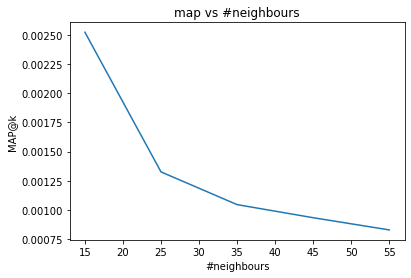

In [375]:
plt.title('map vs #neighbours')
plt.plot(neighbours[:5],m_avg_pre)
plt.xlabel('#neighbours')
plt.ylabel('MAP@k')
plt.show()

## 8 Eigen state algo for predicting ratings

Details about this algorithm can be found here https://goldberg.berkeley.edu/pubs/eigentaste.pdf.

This algorithm has the following steps:
1. Get the subset of items for which maximum users have given ratings. Let there be k such items then the resultant matrix will be of order n*k where n is the number of users

2. Standardize this n*k submatrix and apply PCA to it so that we can get our users in a 2 dim space which explains maximum variance

3. Get our users matrix which is n*k into 2-d using the top 2 eigen vectors

4. Cluster the users and get the average ratings for each of the non popular jokes for each cluster. Sort the ratings in decreasing order and recommend jokes based on that.

5. For a query user make them rate the popular jokes and then with the help of calculated eigen vectors project the user to 2-d plane.

6. Find the cluster to which the user belongs and recommend jokes.

In [396]:
'''Getting the popular jokes from our system i.e jokes with maximum number of ratings recieved'''
ratings.groupby('jokeId').count().head(10)

,userId,rating
jokeId,,
5,661,661
7,59122,59122
8,57720,57720
13,56333,56333
15,54932,54932
16,54150,54150
17,53357,53357
18,51587,51587
19,50699,50699


#### Getting submatrix of popular jokes and users ratings

In [430]:
'''jokes 7,8,13,14,15,16,17,18,19 are very popular and can be considered for our purpose'''
#creating a 53k*9 ratings matrix for the above jokes
#53k because we are considering only train users
subrating_matrix = []
for i in tqdm(train_users):
    subrating_matrix.append(ratings_matrix.toarray()[i][[6,7,12,13,14,15,16,17,18]])

subrating_matrix = np.array(subrating_matrix)
subrating_matrix.shape

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53218/53218 [09:07<00:00, 97.20it/s]


(53218, 9)

#### Standardizing the data

In [431]:
'''Standardizing the submatrix by subtracting mean and dividing by std'''
std = StandardScaler()
subrating_matrix= std.fit_transform(subrating_matrix)
subrating_matrix

array([[-1.31576517, -0.69033949, -0.50038671, ..., -0.64950583,
        -0.59444029, -0.67310881],
       [ 2.05546898,  0.50179504,  0.27648467, ..., -0.01149538,
        -0.44990699, -0.69761963],
       [-1.41452186, -0.55966857, -0.27967141, ..., -0.67832163,
        -0.66527098, -0.70398721],
       ...,
       [ 1.71552144,  0.23443296,  0.15739134, ..., -0.116038  ,
        -0.16646332, -0.23607189],
       [ 1.74288563,  0.41465997,  0.19368158, ..., -0.0541728 ,
        -0.10696917, -0.17245425],
       [-1.40890869,  6.17153164,  4.41487326, ...,  3.03888219,
         2.62419926,  2.45889703]])

#### Getting Eigen vectors of submatrix using PCA

In [432]:
'''Applying PCA to the submatrix to get our users vector in a 2-d space'''
pca = PCA(n_components=2)
pca.fit_transform(subrating_matrix)
pca.explained_variance_ratio_

array([0.64469935, 0.130484  ])

In [433]:
'''We got 76% approx varaince by taking 2 eigen vectors'''
eigen_vectors = pca.components_
eigen_vectors.shape

(2, 9)

#### Projecting Users into 2-d(eigen space)

In [434]:
'''Projecting our users from subratings matrix onto 2-d'''
subrating_matrix_2d = np.matmul(subrating_matrix,eigen_vectors.T)
subrating_matrix_2d.shape

(53218, 2)

In [518]:
subrating_matrix_2d[:,0:1]

array([[-1.5152364 ],
       [-0.19212644],
       [-1.62852553],
       ...,
       [ 0.03417018],
       [ 0.2388014 ],
       [ 9.19517743]])

In [547]:
print(len(list(filter(lambda x:x[0] >1  ,subrating_matrix_2d))))

6533


#### Plotting the users 

Text(0, 0.5, 'feature 2')

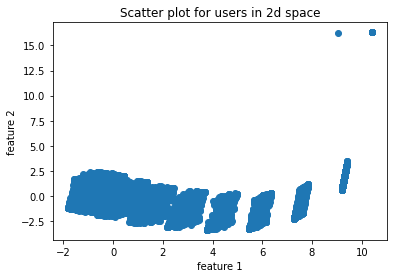

In [442]:
plt.title('Scatter plot for users in 2d space')
plt.scatter(subrating_matrix_2d[:,0:1],subrating_matrix_2d[:,1:])
plt.xlabel('feature 1')
plt.ylabel('feature 2')

#### Clustering the above users into 3 clusters

Clustering Users........


53218it [00:00, 516871.41it/s]


Getting Ratings for each clusters


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.99s/it]


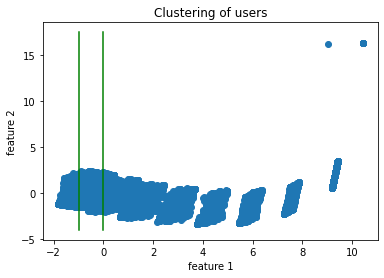

In [664]:
'''Clustering the above given users'''
'''Seeing the above plot we can divide our users into clusters depending on the feature 1 values
easily'''
#cluster 0 feature1 < -1
# cluster 1 : -1<feature1<0
#cluster 2: 0<feature1< 1
#cluster 3: 1<feature1
upper = 17.5
lower = -4
plt.title('Clustering of users')
plt.scatter(subrating_matrix_2d[:,0:1],subrating_matrix_2d[:,1:])
plt.plot([-1,-1],[lower,upper],color = 'green')
plt.plot([0,0],[lower,upper],color = 'green')
plt.xlabel('feature 1')
plt.ylabel('feature 2')


'''for each cluster we would store the mean of the non popular jokes rated by the users and will
store them in sorted order'''

print('Clustering Users........')
cluster_1 = defaultdict(list)
for userid,feature1 in tqdm(enumerate(subrating_matrix_2d[:,0:1])):
    if(feature1<-1): cluster_1[0].append(userid)
    elif(feature1>-1 and feature1<0): cluster_1[1].append(userid)
    else: cluster_1[2].append(userid)    
# for i in clusters.keys():
#     print(len(clusters[i]))
    
print('Getting Ratings for each clusters')
#getting non popular jokes
non_popular_jokes = list(range(0,6)) + [8,9,10,11] + list(range(19,150))  
#iterating over all clusters to get mean joke ratings
for cluster in tqdm(cluster_1.keys()):
    #list to store joke ratings for corresponding cluster
    joke_ratings_for_cluster = []
    #iterating over each joke to find its mean rating in the cluster
    for jokeid in non_popular_jokes:
        #getting the joke ratings
        joke_ratings = rating_matrix.toarray().T[jokeid]
        #getting the mean rating of the joke given by users in the cluster only
        joke_rating_cluster = [joke_ratings[user]
                           for user in cluster_1[cluster] if joke_ratings[user] != 99.0]
        if(len(joke_rating_cluster)!= 0):
            #getting average joke rating
            avg_joke_rating = np.sum(joke_rating_cluster)/len(joke_rating_cluster)
            #appending in the list (jokeid,average rating)
            joke_ratings_for_cluster.append((jokeid,avg_joke_rating))
    #sorting the ratings in decreasing order wrt ratings
    joke_ratings_for_cluster = sorted(joke_ratings_for_cluster,reverse=True,key=
                                     lambda x:x[1])
    cluster_1[cluster] = joke_ratings_for_cluster
    
    
    



In [661]:
clusters_1[2]

[(42, 9.156333333333334),
 (79, 8.989666666666666),
 (72, 8.989333333333333),
 (86, 7.638234567901233),
 (124, 7.591547904191618),
 (141, 7.538654545454544),
 (64, 7.518607407407408),
 (82, 7.407006666666666),
 (80, 7.369183908045978),
 (20, 7.333581632653061),
 (109, 7.306443877551021),
 (25, 7.2892976878612705),
 (101, 7.243434285714285),
 (26, 7.175),
 (148, 7.14721875),
 (144, 7.135505882352941),
 (92, 7.128503703703704),
 (135, 7.124625000000001),
 (106, 7.111324999999999),
 (65, 7.098935828877005),
 (131, 7.085475609756098),
 (27, 7.064413173652695),
 (71, 7.0560278884462155),
 (29, 7.015647540983606),
 (88, 7.006962593516209),
 (138, 6.9977590361445765),
 (48, 6.9881978609625675),
 (119, 6.97623404255319),
 (68, 6.972102661596958),
 (67, 6.967504504504504),
 (128, 6.9572088353413655),
 (126, 6.946741666666666),
 (97, 6.944454545454546),
 (85, 6.930223214285715),
 (121, 6.916253333333334),
 (116, 6.91120093457944),
 (52, 6.902829479768786),
 (83, 6.875037234042553),
 (66, 6.86373

#### Creating submatrix of our test users

In [573]:
subrating_matrix_test = create_test_users(test_users)
subrating_matrix_test.shape

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5914/5914 [01:01<00:00, 95.77it/s]


(5914, 9)

In [574]:
project_2d(subrating_matrix_test[0])

array([6.31480095, 7.00538954])

#### Getting predictions for test user

In [585]:
#getting some predictions
eigenstate_model(project_2d(subrating_matrix_test[890]),1)

[128, 104, 52, 71, 34, 103, 88, 31, 105, 126]

#### Calculating MAP@k for all test users

In [591]:
#converting test users into 2-d
subrating_matrix_test_2d = []
for user in tqdm(subrating_matrix_test):
    subrating_matrix_test_2d.append(project_2d(user))
#calculating MAP
MAP = calculate_map(subrating_matrix_test_2d,query_users_test)
print('MAP@k for eigenstate is: ',MAP)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5914/5914 [00:00<00:00, 298385.85it/s]
0it [00:00, ?it/s]/var/folders/rs/dnnfj5ys6x19tnzw7f1hbj0h0000gn/T/ipykernel_14882/1032139473.py:51: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if(user != []):
5914it [00:00, 173222.49it/s]

MAP@k for eigenstate is:  0.0054523273357431805


### Trying different number of clusters

Clustering Users........


53218it [00:00, 70921.40it/s]


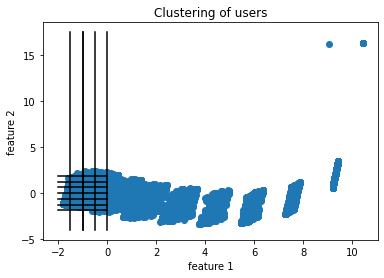

In [682]:
upper = 17.5
lower = -4
x_lower = -2
x_upper = 0
plt.title('Clustering of users')
plt.scatter(subrating_matrix_2d[:,0:1],subrating_matrix_2d[:,1:])
plt.plot([-1.5,-1.5],[lower,upper],color = 'black')
plt.plot([-1,-1],[lower,upper],color = 'black')
plt.plot([-0.5,-0.5],[lower,upper],color = 'black')
plt.plot([0,0],[lower,upper],color = 'black')
plt.plot([-1,-1],[lower,upper],color = 'black')
plt.plot([x_lower,x_upper],[1.875,1.875],color = 'black')
plt.plot([x_lower,x_upper],[1.25,1.25],color = 'black')
plt.plot([x_lower,x_upper],[0.625,0.625],color = 'black')
plt.plot([x_lower,x_upper],[0,0],color = 'black')
plt.plot([x_lower,x_upper],[-0.625,-0.625],color = 'black')
plt.plot([x_lower,x_upper],[-1.25,-1.25],color = 'black')
plt.plot([x_lower,x_upper],[-1.875,-1.875],color = 'black')
plt.xlabel('feature 1')
plt.ylabel('feature 2')


'''for each cluster we would store the mean of the non popular jokes rated by the users and will
store them in sorted order'''

print('Clustering Users........')
clusters = defaultdict(list)
for userid,tup in tqdm(enumerate(list(zip(subrating_matrix_2d[:,0:1],subrating_matrix_2d[:,1:])))):
    feature1 = tup[0]
    feature2 = tup[1]
    if(feature1<-1.5 and feature2>1.875): clusters[0].append(userid)
    elif(feature1>-1.5 and feature1<-1 and feature2>1.875): clusters[1].append(userid)
    elif(feature1>-1 and feature1<-0.5 and feature2>1.875): clusters[2].append(userid)
    elif(feature1>-0.5 and feature1<0 and feature2>1.875): clusters[3].append(userid)
        
    elif(feature1<-1.5 and feature2<1.875 and feature2>1.25): clusters[4].append(userid)
    elif(feature1>-1.5 and feature1<-1 and feature2<1.875 and feature2>1.25): clusters[5].append(userid)
    elif(feature1>-1 and feature1<-0.5 and feature2<1.875 and feature2>1.25): clusters[6].append(userid)
    elif(feature1>-0.5 and feature1<0 and feature2<1.875 and feature2>1.25): clusters[7].append(userid)
        
    elif(feature1<-1.5  and feature2<1.25 and feature2>0.625): clusters[8].append(userid)
    elif(feature1>-1.5 and feature1<-1  and feature2<1.25 and feature2>0.625): clusters[9].append(userid)
    elif(feature1>-1 and feature1<-0.5  and feature2<1.25 and feature2>0.625): clusters[10].append(userid)
    elif(feature1>-0.5 and feature1<0  and feature2<1.25 and feature2>0.625): clusters[11].append(userid)
    
    elif(feature1<-1.5  and feature2<0.625 and feature2>0): clusters[12].append(userid)
    elif(feature1>-1.5 and feature1<-1   and feature2<0.625 and feature2>0): clusters[13].append(userid)
    elif(feature1>-1 and feature1<-0.5   and feature2<0.625 and feature2>0): clusters[14].append(userid)
    elif(feature1>-0.5 and feature1<0   and feature2<0.625 and feature2>0): clusters[15].append(userid)
        
#     elif(feature1<-1.5   and feature2<0.625 and feature2>0): clusters[16].append(userid)
#     elif(feature1>-1.5 and feature1<-1   and feature2<0.625 and feature2>0): clusters[17].append(userid)
#     elif(feature1>-1 and feature1<-0.5   and feature2<0.625 and feature2>0): clusters[18].append(userid)
#     elif(feature1>-0.5 and feature1<0  and feature2<0.625 and feature2>0): clusters[19].append(userid)
        
    elif(feature1<-1.5   and feature2<0 and feature2>-0.625): clusters[16].append(userid)
    elif(feature1>-1.5 and feature1<-1  and feature2<0 and feature2>-0.625): clusters[17].append(userid)
    elif(feature1>-1 and feature1<-0.5  and feature2<0 and feature2>-0.625): clusters[18].append(userid)
    elif(feature1>-0.5 and feature1<0  and feature2<0 and feature2>-0.625): clusters[19].append(userid)
    
    elif(feature1<-1.5   and feature2<-0.625 and feature2>-1.25): clusters[20].append(userid)
    elif(feature1>-1.5 and feature1<-1   and feature2<-0.625 and feature2>-1.25): clusters[21].append(userid)
    elif(feature1>-1 and feature1<-0.5   and feature2<-0.625 and feature2>-1.25): clusters[22].append(userid)
    elif(feature1>-0.5 and feature1<0   and feature2<-0.625 and feature2>-1.25): clusters[23].append(userid)
        
    elif(feature1<-1.5   and feature2<-1.25 and feature2>-1.875): clusters[24].append(userid)
    elif(feature1>-1.5 and feature1<-1   and feature2<-1.25 and feature2>-1.875): clusters[25].append(userid)
    elif(feature1>-1 and feature1<-0.5  and feature2<-1.25 and feature2>-1.875): clusters[26].append(userid)
    elif(feature1>-0.5 and feature1<-0   and feature2<-1.25 and feature2>-1.875): clusters[27].append(userid)
        
    elif(feature1<-1.5   and feature2<-1.875 ): clusters[28].append(userid)
    elif(feature1>-1.5 and feature1<-1.875 and feature2<-1.875): clusters[29].append(userid)
    elif(feature1>-1 and feature1<-0.5 and feature2<-1.875): clusters[30].append(userid)
    elif(feature1>-0.5 and feature1<0 and feature2<-1.875): clusters[31].append(userid)
        
#     elif(feature1<-1.5 and feature2<-2.5): clusters[36].append(userid)
#     elif(feature1>-1.5 and feature1<-1 and feature2<-2.5): clusters[37].append(userid)
#     elif(feature1>-1 and feature1<-0.5 and feature2<-2.5): clusters[38].append(userid)
#     elif(feature1>-0.5 and feature1<0 and feature2<-2.5): clusters[39].append(userid) 
        
    else:  clusters[32].append(userid)   

In [683]:
#checking number of users in each cluster:
for key in clusters.keys():
    print('cluster {} has {} users'.format(key,len(clusters[key])))

cluster 20 has 1185 users
cluster 3 has 250 users
cluster 32 has 8417 users
cluster 10 has 6056 users
cluster 22 has 3905 users
cluster 14 has 7481 users
cluster 18 has 7796 users
cluster 11 has 2522 users
cluster 21 has 4207 users
cluster 6 has 1357 users
cluster 17 has 2801 users
cluster 19 has 1064 users
cluster 13 has 1008 users
cluster 25 has 448 users
cluster 15 has 1443 users
cluster 27 has 99 users
cluster 2 has 173 users
cluster 7 has 1232 users
cluster 23 has 539 users
cluster 24 has 81 users
cluster 16 has 92 users
cluster 26 has 226 users
cluster 5 has 179 users
cluster 9 has 590 users
cluster 12 has 18 users
cluster 31 has 9 users
cluster 8 has 9 users
cluster 1 has 14 users
cluster 4 has 12 users
cluster 30 has 5 users


In [684]:
print('Getting Ratings for each clusters')
#getting non popular jokes
non_popular_jokes = list(range(0,6)) + [8,9,10,11] + list(range(19,150))  
#iterating over all clusters to get mean joke ratings
for cluster in tqdm(clusters.keys()):
    #list to store joke ratings for corresponding cluster
    joke_ratings_for_cluster = []
    #iterating over each joke to find its mean rating in the cluster
    for jokeid in non_popular_jokes:
        #getting the joke ratings
        joke_ratings = rating_matrix.toarray().T[jokeid]
        #getting the mean rating of the joke given by users in the cluster only
        joke_rating_cluster = [joke_ratings[user]
                           for user in clusters[cluster] if joke_ratings[user] != 99.0]
        if(len(joke_rating_cluster)!= 0):
            #getting average joke rating
            avg_joke_rating = np.sum(joke_rating_cluster)/len(joke_rating_cluster)
            #appending in the list (jokeid,average rating)
            joke_ratings_for_cluster.append((jokeid,avg_joke_rating))
    #sorting the ratings in decreasing order wrt ratings
    joke_ratings_for_cluster = sorted(joke_ratings_for_cluster,reverse=True,key=
                                     lambda x:x[1])
    clusters[cluster] = joke_ratings_for_cluster


Getting Ratings for each clusters


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:43<00:00,  1.45s/it]


In [687]:
#checking cluster values
clusters[28]

[]

In [701]:
 '''Given a query user we will first assume or make the new user rate all the popular items.
then project our new user into 2-d plane , find its corresponding cluster,and recommend the jokes'''
def create_test_users(test_users):
    '''This function creates the submatrix of popular raings only for our test users'''
    subrating_matrix_test = []
    #getting the ratings for popuar jokes for test users
    for i in tqdm(test_users):
        subrating_matrix_test.append(ratings_matrix.toarray()[i][[6,7,12,13,14,15,16,17,18]])
    
    return np.array(subrating_matrix_test)

def project_2d(query_user):
    '''This function projects the query user onto the 2-d plane.
    query_user is a vector of ratings for popular jokes by this user'''
    
    return np.matmul(query_user,eigen_vectors.T)

def get_cluster_1(query_user):
    '''This function gives the cluster number to which the user belongs 
    when total clusters are 3'''
    
    if(query_user[0] < -1):
        return 0
    elif(query_user[0] >-1 and query_user[1]<0):
        return 1
    else:
        return 2

def get_cluster_2(query_user):
    '''This function gives the cluster number to which the user belongs 
    when total clusters are 33'''
    feature1 = query_user[0]
    feature2 = query_user[1]
    if(feature1<-1.5 and feature2>1.875): return 0
    elif(feature1>-1.5 and feature1<-1 and feature2>1.875): return 1
    elif(feature1>-1 and feature1<-0.5 and feature2>1.875): return 2
    elif(feature1>-0.5 and feature1<0 and feature2>1.875): return 3
        
    elif(feature1<-1.5 and feature2<1.875 and feature2>1.25): return 4
    elif(feature1>-1.5 and feature1<-1 and feature2<1.875 and feature2>1.25): return 5
    elif(feature1>-1 and feature1<-0.5 and feature2<1.875 and feature2>1.25): return 6
    elif(feature1>-0.5 and feature1<0 and feature2<1.875 and feature2>1.25): return 7
        
    elif(feature1<-1.5  and feature2<1.25 and feature2>0.625): return 8
    elif(feature1>-1.5 and feature1<-1  and feature2<1.25 and feature2>0.625): return 9
    elif(feature1>-1 and feature1<-0.5  and feature2<1.25 and feature2>0.625): return 10
    elif(feature1>-0.5 and feature1<0  and feature2<1.25 and feature2>0.625): return 11
    
    elif(feature1<-1.5  and feature2<0.625 and feature2>0): return 12
    elif(feature1>-1.5 and feature1<-1   and feature2<0.625 and feature2>0): return 13
    elif(feature1>-1 and feature1<-0.5   and feature2<0.625 and feature2>0): return 14
    elif(feature1>-0.5 and feature1<0   and feature2<0.625 and feature2>0): return 15
    
    elif(feature1<-1.5   and feature2<0 and feature2>-0.625): return 16
    elif(feature1>-1.5 and feature1<-1  and feature2<0 and feature2>-0.625): return 17
    elif(feature1>-1 and feature1<-0.5  and feature2<0 and feature2>-0.625): return 18
    elif(feature1>-0.5 and feature1<0  and feature2<0 and feature2>-0.625): return 19
    
    elif(feature1<-1.5   and feature2<-0.625 and feature2>-1.25): return 20
    elif(feature1>-1.5 and feature1<-1   and feature2<-0.625 and feature2>-1.25): return 21
    elif(feature1>-1 and feature1<-0.5   and feature2<-0.625 and feature2>-1.25): return 22
    elif(feature1>-0.5 and feature1<0   and feature2<-0.625 and feature2>-1.25): return 23
        
    elif(feature1<-1.5   and feature2<-1.25 and feature2>-1.875): return 24
    elif(feature1>-1.5 and feature1<-1   and feature2<-1.25 and feature2>-1.875): return 25
    elif(feature1>-1 and feature1<-0.5  and feature2<-1.25 and feature2>-1.875): return 26
    elif(feature1>-0.5 and feature1<-0   and feature2<-1.25 and feature2>-1.875): return 27
        
    elif(feature1<-1.5   and feature2<-1.875 ): return 28
    elif(feature1>-1.5 and feature1<-1.875 and feature2<-1.875): return 29
    elif(feature1>-1 and feature1<-0.5 and feature2<-1.875): return 30
    elif(feature1>-0.5 and feature1<0 and feature2<-1.875): return 31
        
    else:  return 32
    
    
def eigenstate_model(query_user,key):
    '''This function returns the recommendations based on the query user 
    belonging to its corresponding cluster. Query user is in 2-d'''
    
    #find the cluseter to which the user belongs
    if(key == 1):
        cluster = get_cluster_1(query_user)
        target_cluster = cluster_1
    else:
        cluster = get_cluster_2(query_user)
        target_cluster = clusters
    
    #get top 10 recommendations
    recommendations = target_cluster[cluster][:10]
    #checking if we get 10 recommendations or not 
    max_cluster = max(list(target_cluster.keys()))
    if(len(recommendations) < 10):
        #finding the nearest cluster with more recommendations
        curr_cluster = cluster+1
        #checking for the next cluster
        while(curr_cluster <= max_cluster):
            #if cluster has more than 10 recommendations we append the recommendaions and break
            if(len(target_cluster[curr_cluster]) > 10):
                recommendations = recommendations + target_cluster[curr_cluster]
                break
            curr_cluster += 1    
    return [tup[0]
        for tup in recommendations][:10]

def calculate_map(query_users_2d,query_users_test,key):
    '''This function returns the mean average precision@k for the given query users.
    query users are assumed to be in 2-d plane'''
    
    k = 10
    average_precision = 0
    relevant_items = []
    mean_avg_precision = 0
    total_users = len([user for user in query_users_train if user != []])
    #getting relevant jokes for the user
    for user in query_users_test:
        relevant_items.append([tup[0] for tup in user])
    
    
    #calculating precision@k
    for userid,user in tqdm(enumerate(query_users_2d)):
        if(user != []):
            #getting 10 recommednations for current user
            recommendations = eigenstate_model(user,key)
            #getting relevant jokes for this user
            relevant_items_user = relevant_items[userid]
            #getting number of relevant jokes for this user
            total_relevant_items = len(relevant_items_user)
            #iterating over k to calculate avg precision@k Ref:http://sdsawtelle.github.io/blog/output/mean-average-precision-MAP-for-recommender-systems.html
            for i in range(k):
                #checking if the kth item is relevant or not
                if(recommendations[i] in relevant_items_user):
                    #getting recommendations till i 
                    items_till_i = recommendations[:i]
                    #calculating precision till i recommendations
                    precision_i = len(list(filter(lambda x: x in relevant_items_user,items_till_i)))/k
                    #calcualting average precision over all values of k
                    average_precision = average_precision + precision_i
            if(total_relevant_items != 0):        
                average_precision = average_precision/total_relevant_items
                #calculating mean average precision over all users
                mean_avg_precision = mean_avg_precision + average_precision
    mean_avg_precision = mean_avg_precision/total_users
    return mean_avg_precision
    

In [700]:
#getting some predictions using cluster 1
eigenstate_model(project_2d(subrating_matrix_test[4000]),1)

0 [(128, 2.2496611349036404), (104, 2.234292357819905), (52, 2.182106666666667), (71, 2.1633668407310704), (34, 2.130231961517905), (103, 1.881149), (88, 1.850149644594089), (31, 1.829816430020284), (105, 1.7843405172413793), (126, 1.7503165584415583)]


[128, 104, 52, 71, 34, 103, 88, 31, 105, 126]

In [674]:
#converting test users into 2-d
subrating_matrix_test_2d = []
for user in tqdm(subrating_matrix_test):
    subrating_matrix_test_2d.append(project_2d(user))
#calculating MAP for cluster 1
MAP = calculate_map(subrating_matrix_test_2d,query_users_test,1)
print('MAP@k for eigenstate is: ',MAP)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5914/5914 [00:00<00:00, 330263.68it/s]
0it [00:00, ?it/s]/var/folders/rs/dnnfj5ys6x19tnzw7f1hbj0h0000gn/T/ipykernel_14882/675960215.py:130: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if(user != []):
5914it [00:00, 146764.53it/s]

MAP@k for eigenstate is:  0.0054523273357431805


In [704]:
#getting some predictions using cluster 2
eigenstate_model(project_2d(subrating_matrix_test[4]),2)

[42, 79, 72, 86, 124, 141, 64, 82, 80, 20]

In [705]:
#converting test users into 2-d
subrating_matrix_test_2d = []
for user in tqdm(subrating_matrix_test):
    subrating_matrix_test_2d.append(project_2d(user))
#calculating MAP for cluster 2
MAP = calculate_map(subrating_matrix_test_2d,query_users_test,2)
print('MAP@k for eigenstate is: ',MAP)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5914/5914 [00:00<00:00, 286449.72it/s]
0it [00:00, ?it/s]/var/folders/rs/dnnfj5ys6x19tnzw7f1hbj0h0000gn/T/ipykernel_14882/1593167429.py:129: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if(user != []):
5914it [00:00, 104404.34it/s]

MAP@k for eigenstate is:  0.0018333223093206774


### Surprise library models

In [1]:
models_evaluation_train = dict()
models_evaluation_test = dict()

In [2]:
from surprise import Reader
from surprise import Dataset

In [5]:
y_surprise = ratings['rating'].values

#### Spliting into train and test data

In [6]:
x_train_sur,x_test_sur,y_train_sur,y_test_sur = train_test_split(ratings,y_surprise,
                                                                test_size = 0.20)
print('train data shape ',x_train_sur.shape,y_train_sur.shape)
print('test data shape ',x_test_sur.shape,y_test_sur.shape)

train data shape  (1409151, 3) (1409151,)
test data shape  (352288, 3) (352288,)


In [7]:
x_test_sur

,userId,jokeId,rating
533687,20190,32,-1.812
1586494,57289,132,4.656
1428266,50864,131,-4.156
1196844,43614,138,-0.750
668124,28365,101,-8.094
...,...,...,...
1716004,62194,55,-8.375
1559840,56304,32,2.688
345725,13239,68,5.844
629549,25762,89,2.562


#### Transforming data to work with library

#### Transforming Train data

In [8]:
# It is to specify how to read the dataframe.
# for our dataframe, we don't have to specify anything extra..
reader = Reader(rating_scale=(1,5))

# create the traindata from the dataframe...
train_data = Dataset.load_from_df(x_train_sur, reader)

# build the trainset from traindata.., It is of dataset format from surprise library..
trainset = train_data.build_full_trainset() 

#### Transforming Test data

In [9]:
testset = list(zip(x_test_sur.userId.values,x_test_sur.jokeId.values,x_test_sur.rating.values))
testset[:3]

[(20190, 32, -1.812),
 (57289, 132, 4.656000000000001),
 (50864, 131, -4.156000000000001)]

#### Utility function for surprise models

In [10]:
import random

my_seed = 15
random.seed(my_seed)
np.random.seed(my_seed)

##########################################################
# get  (actual_list , predicted_list) ratings given list 
# of predictions (prediction is a class in Surprise).    
##########################################################
def get_ratings(predictions):
    actual = np.array([pred.r_ui for pred in predictions])
    pred = np.array([pred.est for pred in predictions])
    
    return actual, pred

################################################################
# get ''rmse'' and ''mape'' , given list of prediction objecs 
################################################################
def get_errors(predictions, print_them=False):

    actual, pred = get_ratings(predictions)
    rmse = np.sqrt(np.mean((pred - actual)**2))
    mape = np.mean(np.abs(pred - actual)/actual)

    return rmse, mape*100


def run_surprise(algo,trainset,testset,verbose=True):
    '''
    return train_dict, test_dict
    
        It returns two dictionaries, one for train and the other is for test
        Each of them have 3 key-value pairs, which specify ''rmse'', ''mape'', and ''predicted ratings''.

    '''
    start = datetime.now()
    # dictionaries that stores metrics for train and test..
    train = dict()
    test = dict()
    
    #Train the model with trainset
    st = datetime.now()
    print('Training the model...')
    algo.fit(trainset)
    
    # ---------------- Evaluating train data--------------------#
    
    print('Evaluating the model with train data..')
    # get the train predictions (list of prediction class inside Surprise)
    train_preds = algo.test(trainset.build_testset())
    # get predicted ratings from the train predictions..
    train_actual_ratings, train_pred_ratings = get_ratings(train_preds)
    # get ''rmse'' and ''mape'' from the train predictions.
    train_rmse, train_mape = get_errors(train_preds)
    print('time taken : {}'.format(datetime.now()-st))
    
    if verbose:
        print('-'*15)
        print('Train Data')
        print('-'*15)
        print("RMSE : {}\n\nMAPE : {}\n".format(train_rmse, train_mape))
    
    #store them in the train dictionary
    if verbose:
        print('adding train results in the dictionary..')
    train['rmse'] = train_rmse
    train['mape'] = train_mape
    train['predictions'] = train_pred_ratings
    
    #------------ Evaluating Test data---------------#
    st = datetime.now()
    print('\nEvaluating for test data...')
    # get the predictions( list of prediction classes) of test data
    test_preds = algo.test(testset)
    # get the predicted ratings from the list of predictions
    test_actual_ratings, test_pred_ratings = get_ratings(test_preds)
    # get error metrics from the predicted and actual ratings
    test_rmse, test_mape = get_errors(test_preds)
    print('time taken : {}'.format(datetime.now()-st))
    
    if verbose:
        print('-'*15)
        print('Test Data')
        print('-'*15)
        print("RMSE : {}\n\nMAPE : {}\n".format(test_rmse, test_mape))
    # store them in test dictionary
    if verbose:
        print('storing the test results in test dictionary...')
    test['rmse'] = test_rmse
    test['mape'] = test_mape
    test['predictions'] = test_pred_ratings
    
    print('\n'+'-'*45)
    print('Total time taken to run this algorithm :', datetime.now() - start)
    
    # return two dictionaries train and test
    return train, test

### Surprise Baseline model

In [14]:
from surprise import BaselineOnly 
from surprise import KNNBaseline
from surprise import SVD

In [12]:
# options are to specify.., how to compute those user and item biases
bsl_options = {'method': 'sgd',
               'learning_rate': .001
               }
bsl_algo = BaselineOnly(bsl_options=bsl_options)
# run this algorithm.., It will return the train and test results..
bsl_train_results, bsl_test_results = run_surprise(bsl_algo, trainset, testset, verbose=True)

models_evaluation_train['bsl_algo'] = bsl_train_results 
models_evaluation_test['bsl_algo'] = bsl_test_results

Training the model...
Estimating biases using sgd...
Evaluating the model with train data..


/var/folders/rs/dnnfj5ys6x19tnzw7f1hbj0h0000gn/T/ipykernel_5895/1518816048.py:24: RuntimeWarning: divide by zero encountered in true_divide
  mape = np.mean(np.abs(pred - actual)/actual)


time taken : 0:00:10.385320
---------------
Train Data
---------------
RMSE : 4.755202075338357

MAPE : inf

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.744580
---------------
Test Data
---------------
RMSE : 4.790628939194879

MAPE : inf

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:00:11.130084


### Surprise KNN baseline with. item-item similarity

In [13]:
sim_options = {'user_based' : False,
               'name': 'pearson_baseline',
               'shrinkage': 100,
               'min_support': 2
              } 
# we keep other parameters like regularization parameter and learning_rate as default values.
bsl_options = {'method': 'sgd'} 

knn_bsl_m = KNNBaseline(k=40, sim_options = sim_options, bsl_options = bsl_options)
knn_bsl_m_train_results, knn_bsl_m_test_results = run_surprise(knn_bsl_m, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['knn_bsl_m'] = knn_bsl_m_train_results 
models_evaluation_test['knn_bsl_m'] = knn_bsl_m_test_results


Training the model...
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Evaluating the model with train data..


/var/folders/rs/dnnfj5ys6x19tnzw7f1hbj0h0000gn/T/ipykernel_5895/1518816048.py:24: RuntimeWarning: divide by zero encountered in true_divide
  mape = np.mean(np.abs(pred - actual)/actual)


time taken : 0:00:55.056235
---------------
Train Data
---------------
RMSE : 4.169912143453415

MAPE : inf

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:14.373197
---------------
Test Data
---------------
RMSE : 4.68009829929424

MAPE : inf

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:01:09.429618


### Surprise Matrix Factorization with SVD

In [15]:
# initiallize the model
svd = SVD(n_factors=100, biased=True, random_state=15, verbose=True)
svd_train_results, svd_test_results = run_surprise(svd, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['svd'] = svd_train_results 
models_evaluation_test['svd'] = svd_test_results

Training the model...
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Evaluating the model with train data..


/var/folders/rs/dnnfj5ys6x19tnzw7f1hbj0h0000gn/T/ipykernel_5895/1518816048.py:24: RuntimeWarning: divide by zero encountered in true_divide
  mape = np.mean(np.abs(pred - actual)/actual)


time taken : 0:00:46.935910
---------------
Train Data
---------------
RMSE : 4.0440382665520715

MAPE : inf

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:01.058002
---------------
Test Data
---------------
RMSE : 4.784038049371951

MAPE : inf

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:00:47.994079


### Comparison between Models

In [11]:
print('MAP@k for Item-Item Simialrity Model using BOW representation is {}'.format(0.00007))
print('MAP@k for Item-Item Simialrity Model using TFIDF representation is {}'.format(0.00007))
print('MAP@k for Item-Item Simialrity Model using W2V representation is {}'.format(0.00065))
print('MAP@k for Collaborative Filtering Model using user Ratings as Vectors is {}'.format(0.0025))
print('Test RMSE and MAP@K for XGboost model: {},{}'.format(3.42,0.0234))
print('Test RMSE and MAP@K for LAsso model: {},{}'.format(4.64,0.00339))
print('Test RMSE and MAP@K for Ridge model: {},{}'.format(4.522,0.0053))
print('Test RMSE and MAP@K for Linear SVR model: {},{}'.format(4.57,0.00929))
print('Test RMSE and MAP@K for Decision Tree model: {},{}'.format(5.00,0.0046))
print('Test RMSE and MAP@K for LGBM model: {},{}'.format(3.84,0.0179))
print('Test RMSE and MAP@K for Ensemble model: {},{}'.format(3.471,0.0247))
print('Test RMSE and MAP@K for Ensemble model 2: {},{}'.format(3.359,0.0239))
print('MAP@k for Eigenstate Model is {}'.format(0.00545))
print('RMSE for Surprise Baseline is {}'.format(4.790))
print('RMSE for Surprise KNNBaseline with item item similarity is {}'.format(4.680))
print('RMSE for Surprise SVD model is {}'.format(4.784))

dic = {'Item-Item Simialrity Model using BOW representation':0.00007,
       'Item-Item Simialrity Model using TFIDF representation':0.00007,
       'Item-Item Simialrity Model using W2V representation': 0.00065,
       'Collaborative Filtering Model':0.0025,
       'XGboost model':0.0234,
       'LAsso model':0.00339,
       'Ridge model':0.0053,
       'Linear SVR model':0.00929,
       'Decision Tree model': 0.0046,
       'LGBM model': 0.0179,
       'Ensemble model': 0.0267,
       'Eigenstate Model':0.00545
      }
results = pd.DataFrame.from_dict(dic,orient='index',columns=['MAP@K'])
results

MAP@k for Item-Item Simialrity Model using BOW representation is 7e-05
MAP@k for Item-Item Simialrity Model using TFIDF representation is 7e-05
MAP@k for Item-Item Simialrity Model using W2V representation is 0.00065
MAP@k for Collaborative Filtering Model using user Ratings as Vectors is 0.0025
Test RMSE and MAP@K for XGboost model: 3.42,0.0234
Test RMSE and MAP@K for LAsso model: 4.64,0.00339
Test RMSE and MAP@K for Ridge model: 4.522,0.0053
Test RMSE and MAP@K for Linear SVR model: 4.57,0.00929
Test RMSE and MAP@K for Decision Tree model: 5.0,0.0046
Test RMSE and MAP@K for LGBM model: 3.84,0.0179
Test RMSE and MAP@K for Ensemble model: 3.471,0.0247
Test RMSE and MAP@K for Ensemble model 2: 3.359,0.0239
MAP@k for Eigenstate Model is 0.00545
RMSE for Surprise Baseline is 4.79
RMSE for Surprise KNNBaseline with item item similarity is 4.68
RMSE for Surprise SVD model is 4.784


,MAP@K
Item-Item Simialrity Model using BOW representation,0.00007
Item-Item Simialrity Model using TFIDF representation,0.00007
Item-Item Simialrity Model using W2V representation,0.00065
Collaborative Filtering Model,0.00250
XGboost model,0.02340
LAsso model,0.00339
Ridge model,0.00530
Linear SVR model,0.00929
Decision Tree model,0.00460
LGBM model,0.01790
